# Advanced-Lane-Finding

## Calibrate Camera

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### extract object points and image points for camera calibration.

In [2]:
# read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)

    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # if corners found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

### calibrate, calculate distortion coefficients, and test undistortion on an image!

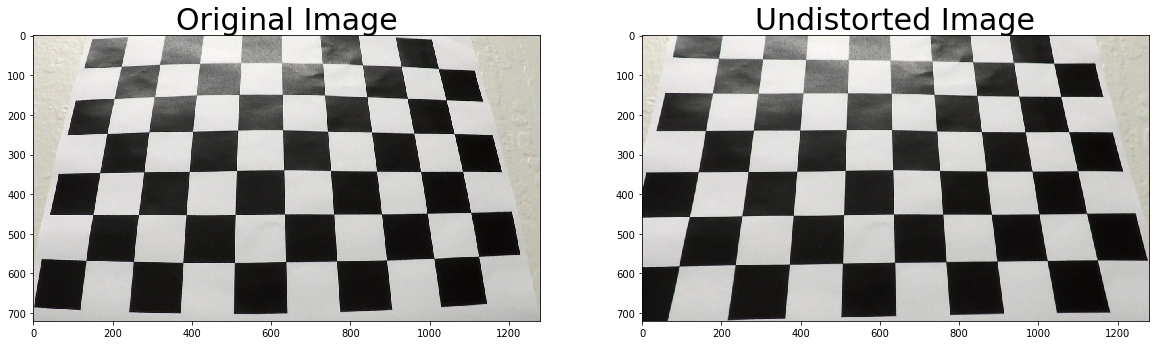

In [3]:
import pickle

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

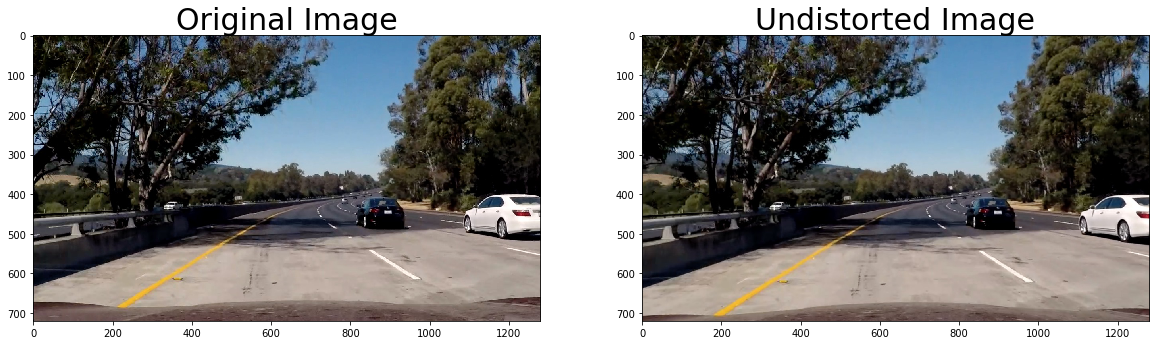

In [4]:
# read an image of the driving lane
lane_img = mpimg.imread('test_images/test5.jpg')

# undistort the image with the coefficients calculated before
undist_lane = cv2.undistort(lane_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(lane_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_lane)
ax2.set_title('Undistorted Image', fontsize=30)

## Color and Gradient

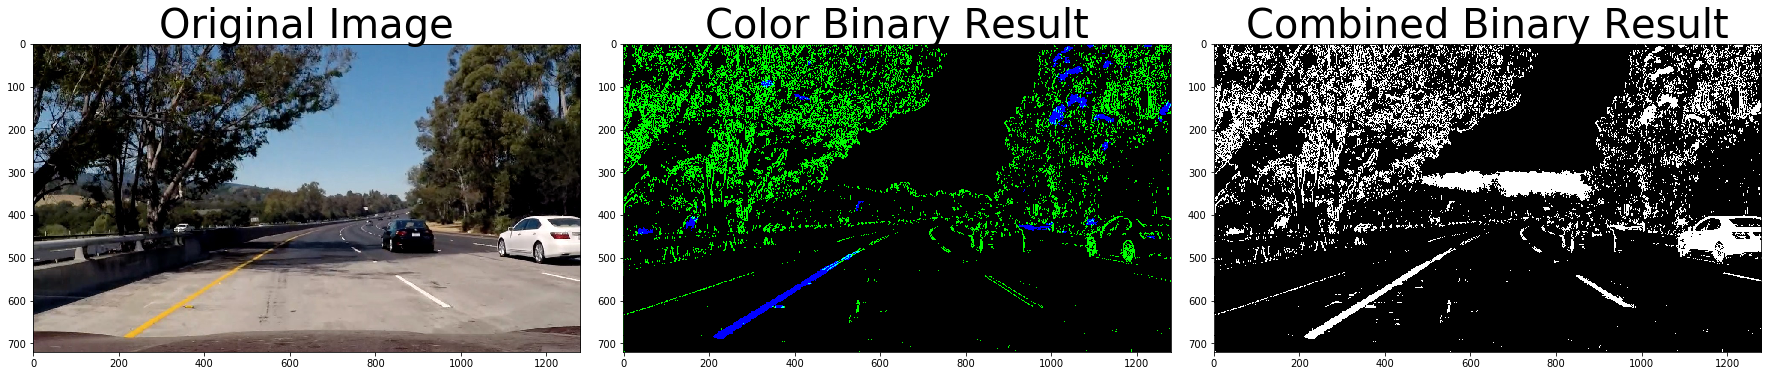

In [5]:
def color_gradient(img, s_thresh=(120, 255),l_thresh=(195, 255), b_thresh=(150, 255), sx_thresh=(20, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    #s_channel = hls[:,:,2]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
    b_channel = lab[:,:,2]
    
    
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, b_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    return color_binary, combined_binary
    
color_bin, combined_bin = color_gradient(lane_img)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(lane_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_bin)
ax2.set_title('Color Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(combined_bin, cmap='gray')
ax3.set_title('Combined Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

In [6]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

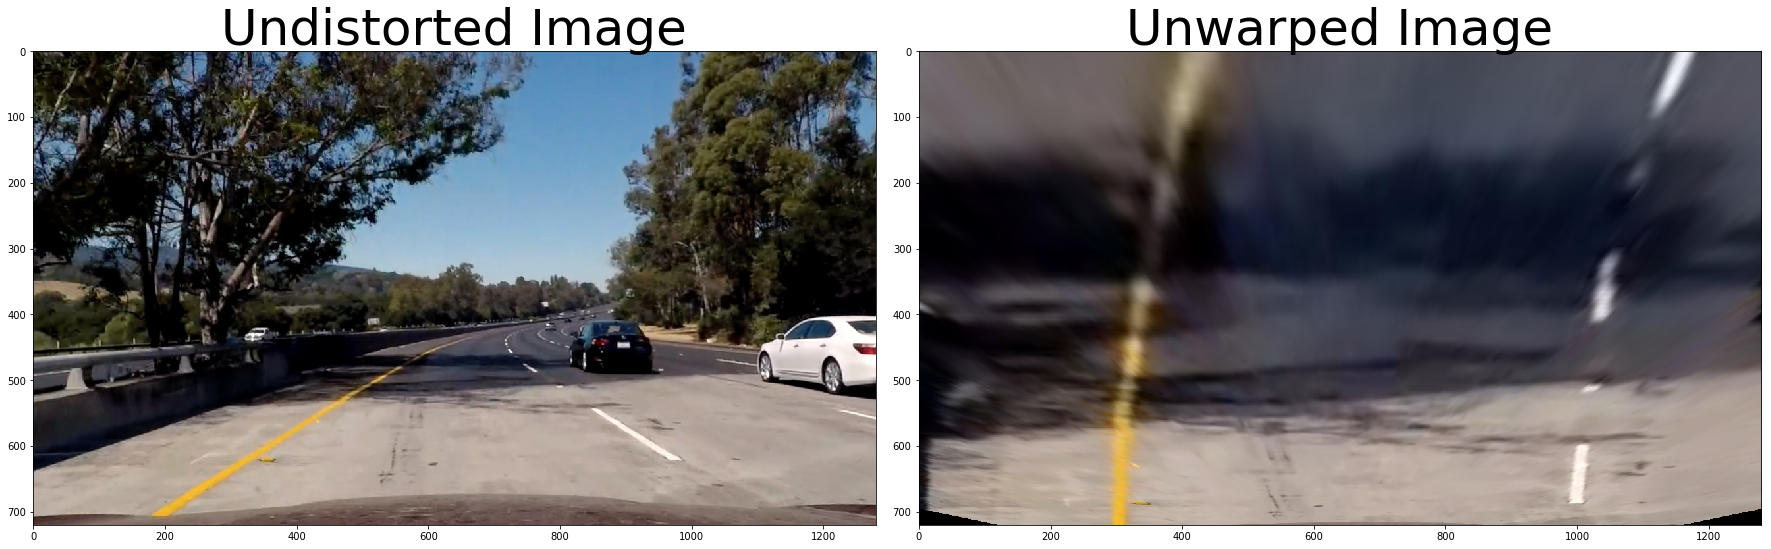

In [7]:
#src = np.float32([[540, 470],[750, 470],[1130, 690],[200, 690]])
#dst = np.float32([[200, 0],[1080, 0],[1080, 720],[200, 720]])
w,h = 1280,720

#src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
#dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

src = np.float32([[ (244, 684), (589, 454), (691, 454), (1036, 684)]])

dst = np.float32([[( 320, 720), (320, 0), (960, 0), (960, 720)]])

lane_img_undist = cv2.undistort(lane_img, mtx, dist, None, mtx)

top_down, perspective_M, Minv = warp(lane_img_undist, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(lane_img_undist)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### thresholded warped image

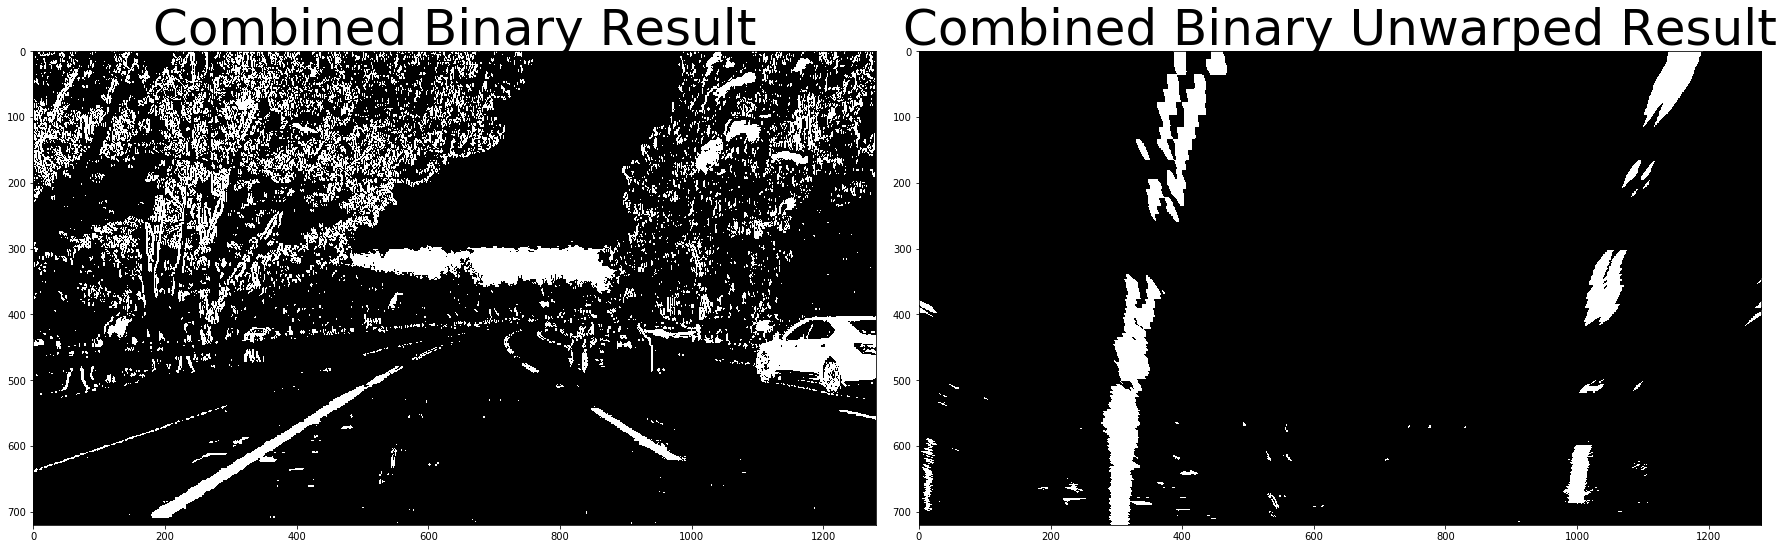

In [8]:
undistorted_color_bin, undistorted_combined_bin = color_gradient(lane_img_undist)
top_down_combined, perspective_M, Minv = warp(undistorted_combined_bin, src, dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_combined_bin, cmap='gray')
ax1.set_title('Combined Binary Result', fontsize=50)
ax2.imshow(top_down_combined, cmap='gray')
ax2.set_title('Combined Binary Unwarped Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Locate the Lane Lines 

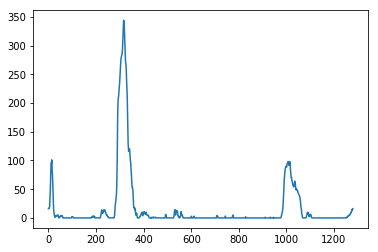

In [9]:
histogram = np.sum(top_down_combined[top_down_combined.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [10]:
def sliding_window_fit(binary_warped, draw=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the WindowsErrorws one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(draw):
        # Generate x and y values for plotting
        ploty = np.linspace(0, top_down_combined.shape[0]-1, top_down_combined.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

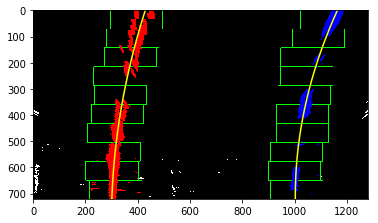

In [11]:
left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_fit(top_down_combined)

### Skip the sliding windows step once you know where the lines are

In [12]:
def skip_sliding_window(binary_warped, left_fit, right_fit, draw=True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    if(draw):
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

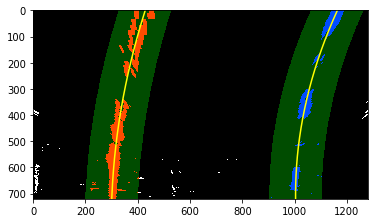

In [13]:
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = skip_sliding_window(top_down_combined, left_fit, right_fit)

## Measuring Curvature

In [14]:
def measure_curvature(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    h = img.shape[0]
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
     # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # Calculate Distance from center
    camera_position = img.shape[1]/2
    print(camera_position)
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    print(lane_center_position)
    center_dist = (camera_position - lane_center_position) * xm_per_pix
    print(center_dist, 'm')
    return left_curverad, right_curverad, center_dist

In [15]:
left_curverad, right_curverad, center_dist = measure_curvature(top_down_combined, left_fit, right_fit, left_lane_inds, right_lane_inds)

832.297385572 m 515.485047991 m
640.0
651.873188524
-0.0627582822002 m


In [16]:
def draw(warped, undist, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

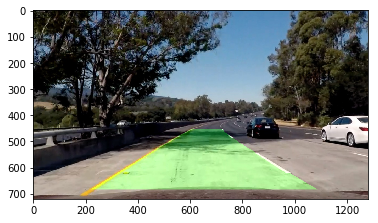

In [17]:
result = draw(top_down_combined, lane_img_undist, Minv, left_fit, right_fit)
plt.imshow(result)

In [18]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + '(m)'
    cv2.putText(new_img, text, (40,70), font, 2, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is ' + '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 2, (255,255,255), 2, cv2.LINE_AA)
    return new_img

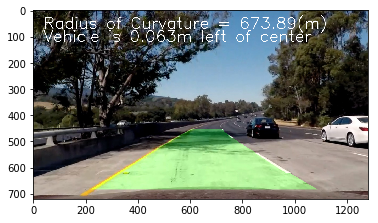

In [19]:
img_result_data = draw_data(result, (left_curverad+right_curverad)/2, center_dist)
plt.imshow(img_result_data)

# Pipeline (video)

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [21]:
class MyDetector(object):
    frame_number = 0
    left_fit = None
    right_fit = None
    left_lane_inds = None
    right_lane_inds = None

    def process_frame(self, img):
        lane_img_undist = cv2.undistort(img, mtx, dist, None, mtx)
        undistorted_color_bin, undistorted_combined_bin = color_gradient(lane_img_undist)
        top_down_combined, perspective_M, Minv = warp(undistorted_combined_bin, src, dst)
        if self.frame_number <= 0:
            self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds = sliding_window_fit(top_down_combined, draw=False)
        else:    
            self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds = skip_sliding_window(top_down_combined, self.left_fit, self.right_fit, draw=False)
            
        left_curverad, right_curverad, center_dist = measure_curvature(top_down_combined, self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds)
        result = draw(top_down_combined, lane_img_undist, Minv, self.left_fit, self.right_fit)
        result_data = draw_data(result, (left_curverad+right_curverad)/2, center_dist)
        self.frame_number += 1
        return result_data    

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
detector = MyDetector()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(40,44)
processed_video = video_input.fl_image(detector.process_frame)
%time processed_video.write_videofile(video_output, audio=False)

552.17106447 m 513.918638225 m
640.0
709.450701245
-0.367096563721 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

558.215337568 m 513.918638225 m
640.0
709.586494314
-0.367814327088 m


  0%|                                                                                 | 1/1261 [00:00<05:33,  3.78it/s]

509.57095905 m 653.565097102 m
640.0
712.036981527
-0.380766902359 m


  0%|▏                                                                                | 2/1261 [00:00<05:37,  3.73it/s]

506.678245801 m 844.454548967 m
640.0
713.616411296
-0.389115316848 m


  0%|▏                                                                                | 3/1261 [00:00<06:04,  3.46it/s]

514.262350892 m 924.830067258 m
640.0
714.839226276
-0.395578767461 m


  0%|▎                                                                                | 4/1261 [00:01<05:48,  3.60it/s]

513.459129013 m 789.288401657 m
640.0
714.71124508
-0.394902295422 m


  0%|▎                                                                                | 5/1261 [00:01<05:38,  3.71it/s]

511.38018432 m 705.199918072 m
640.0
714.83931525
-0.395579237749 m


  0%|▍                                                                                | 6/1261 [00:01<05:28,  3.82it/s]

550.100515078 m 832.04899091 m
640.0
717.714091596
-0.41077448415 m


  1%|▍                                                                                | 7/1261 [00:01<05:22,  3.88it/s]

546.330943248 m 941.474281015 m
640.0
721.005383936
-0.42817131509 m


  1%|▌                                                                                | 8/1261 [00:02<05:17,  3.94it/s]

584.440363664 m 1011.64306155 m
640.0
720.516624676
-0.42558787329 m


  1%|▌                                                                                | 9/1261 [00:02<05:09,  4.05it/s]

612.02653002 m 543.922662197 m
640.0
714.105912917
-0.391702682563 m


  1%|▋                                                                               | 10/1261 [00:02<05:04,  4.11it/s]

711.564221538 m 538.935386173 m
640.0
715.562023983
-0.399399269622 m


  1%|▋                                                                               | 11/1261 [00:02<05:02,  4.14it/s]

749.016839513 m 543.845120502 m
640.0
714.270046477
-0.392570245663 m


  1%|▊                                                                               | 12/1261 [00:03<05:06,  4.08it/s]

906.917796917 m 588.16579122 m
640.0
716.466527231
-0.404180215365 m


  1%|▊                                                                               | 13/1261 [00:03<05:03,  4.11it/s]

794.514995549 m 743.364351727 m
640.0
717.587739907
-0.410106625225 m


  1%|▉                                                                               | 14/1261 [00:03<05:11,  4.00it/s]

733.969109379 m 934.880494631 m
640.0
717.275778066
-0.408457684064 m


  1%|▉                                                                               | 15/1261 [00:03<05:21,  3.87it/s]

690.873411922 m 765.565944871 m
640.0
713.248462375
-0.387170443983 m


  1%|█                                                                               | 16/1261 [00:04<05:19,  3.90it/s]

710.125471135 m 698.932891524 m
640.0
712.142483221
-0.381324554168 m


  1%|█                                                                               | 17/1261 [00:04<05:19,  3.89it/s]

706.540783243 m 770.13087573 m
640.0
711.475973606
-0.377801574774 m


  1%|█▏                                                                              | 18/1261 [00:04<05:09,  4.01it/s]

704.480201803 m 798.529319597 m
640.0
710.261288513
-0.371381096427 m


  2%|█▏                                                                              | 19/1261 [00:04<05:09,  4.01it/s]

715.141358784 m 887.580932897 m
640.0
710.056843044
-0.370300456091 m


  2%|█▎                                                                              | 20/1261 [00:05<05:05,  4.07it/s]

749.390680756 m 1032.63179254 m
640.0
711.328365927
-0.377021362757 m


  2%|█▎                                                                              | 21/1261 [00:05<05:02,  4.10it/s]

733.873381738 m 988.549450285 m
640.0
709.110465432
-0.365298174427 m


  2%|█▍                                                                              | 22/1261 [00:05<05:02,  4.09it/s]

765.263500926 m 757.373777232 m
640.0
705.417416212
-0.345777771405 m


  2%|█▍                                                                              | 23/1261 [00:05<05:00,  4.12it/s]

692.653725417 m 441.252560239 m
640.0
697.467948623
-0.303759157008 m


  2%|█▌                                                                              | 24/1261 [00:06<05:00,  4.11it/s]

639.909264205 m 463.1100156 m
640.0
698.494392521
-0.309184646183 m


  2%|█▌                                                                              | 25/1261 [00:06<05:00,  4.11it/s]

711.002710784 m 480.57749118 m
640.0
699.380543388
-0.313868586481 m


  2%|█▋                                                                              | 26/1261 [00:06<05:03,  4.06it/s]

646.495049357 m 520.393981522 m
640.0
699.572967004
-0.314885682734 m


  2%|█▋                                                                              | 27/1261 [00:06<05:04,  4.06it/s]

645.823478412 m 552.314388929 m
640.0
699.943239221
-0.316842835884 m


  2%|█▊                                                                              | 28/1261 [00:07<05:03,  4.07it/s]

634.309470863 m 673.300221532 m
640.0
701.914761126
-0.327263737381 m


  2%|█▊                                                                              | 29/1261 [00:07<05:03,  4.05it/s]

558.606702643 m 794.436584192 m
640.0
701.881898312
-0.327090033935 m


  2%|█▉                                                                              | 30/1261 [00:07<05:00,  4.09it/s]

527.891146554 m 647.586172347 m
640.0
701.428404388
-0.324692994621 m


  2%|█▉                                                                              | 31/1261 [00:07<05:02,  4.06it/s]

476.754028525 m 649.161765643 m
640.0
700.97839866
-0.322314392919 m


  3%|██                                                                              | 32/1261 [00:08<05:02,  4.06it/s]

464.527151509 m 761.753601667 m
640.0
703.286192432
-0.334512731426 m


  3%|██                                                                              | 33/1261 [00:08<04:59,  4.10it/s]

440.238626865 m 537.743932331 m
640.0
698.860066851
-0.311117496211 m


  3%|██▏                                                                             | 34/1261 [00:08<04:59,  4.10it/s]

427.458140685 m 393.394423462 m
640.0
694.560049352
-0.288388832289 m


  3%|██▏                                                                             | 35/1261 [00:08<05:01,  4.06it/s]

405.263051914 m 367.210920375 m
640.0
695.171889697
-0.291622845541 m


  3%|██▎                                                                             | 36/1261 [00:08<04:59,  4.09it/s]

389.373655936 m 431.556619052 m
640.0
698.438040731
-0.308886786721 m


  3%|██▎                                                                             | 37/1261 [00:09<04:58,  4.10it/s]

388.408150187 m 484.579701265 m
640.0
701.49140696
-0.325026008218 m


  3%|██▍                                                                             | 38/1261 [00:09<04:59,  4.08it/s]

386.349426669 m 561.87055392 m
640.0
703.566651433
-0.335995157572 m


  3%|██▍                                                                             | 39/1261 [00:09<04:58,  4.09it/s]

382.754747485 m 536.933434392 m
640.0
702.836019628
-0.332133246606 m


  3%|██▌                                                                             | 40/1261 [00:09<04:58,  4.09it/s]

394.232954214 m 524.015409317 m
640.0
703.435483097
-0.335301839225 m


  3%|██▌                                                                             | 41/1261 [00:10<04:55,  4.13it/s]

412.602510947 m 502.170928023 m
640.0
704.79044812
-0.342463797203 m


  3%|██▋                                                                             | 42/1261 [00:10<04:56,  4.11it/s]

430.904575675 m 501.385898726 m
640.0
706.387127924
-0.350903390458 m


  3%|██▋                                                                             | 43/1261 [00:10<05:12,  3.90it/s]

446.894886186 m 504.68352505 m
640.0
706.391546797
-0.350926747357 m


  3%|██▊                                                                             | 44/1261 [00:11<05:11,  3.90it/s]

459.80333033 m 601.623599446 m
640.0
708.692159606
-0.363087129343 m


  4%|██▊                                                                             | 45/1261 [00:11<05:14,  3.87it/s]

481.8788916 m 642.118891357 m
640.0
709.782227273
-0.368848915583 m


  4%|██▉                                                                             | 46/1261 [00:11<05:15,  3.85it/s]

493.256946792 m 568.60512261 m
640.0
707.405951109
-0.356288598717 m


  4%|██▉                                                                             | 47/1261 [00:11<05:33,  3.64it/s]

529.513080034 m 363.423993203 m
640.0
700.642602872
-0.320539472323 m


  4%|███                                                                             | 48/1261 [00:12<05:19,  3.79it/s]

575.762164001 m 378.874431408 m
640.0
702.841144799
-0.332160336793 m


  4%|███                                                                             | 49/1261 [00:12<05:15,  3.84it/s]

593.047559128 m 394.971968861 m
640.0
704.849546835
-0.342776176129 m


  4%|███▏                                                                            | 50/1261 [00:12<05:22,  3.75it/s]

651.336987367 m 454.439875731 m
640.0
707.414115391
-0.35633175278 m


  4%|███▏                                                                            | 51/1261 [00:13<08:51,  2.28it/s]

655.664575563 m 559.829632157 m
640.0
710.072711858
-0.370384334104 m


  4%|███▎                                                                            | 52/1261 [00:14<11:27,  1.76it/s]

667.033595507 m 651.263816113 m
640.0
709.785677636
-0.368867153219 m


  4%|███▎                                                                            | 53/1261 [00:15<13:08,  1.53it/s]

652.597917108 m 558.426411861 m
640.0
707.283448851
-0.355641086784 m


  4%|███▍                                                                            | 54/1261 [00:16<14:18,  1.41it/s]

709.10253429 m 561.307580148 m
640.0
707.52188934
-0.356901415085 m


  4%|███▍                                                                            | 55/1261 [00:16<14:58,  1.34it/s]

730.257113597 m 591.851574965 m
640.0
707.258164568
-0.355507441286 m


  4%|███▌                                                                            | 56/1261 [00:17<13:14,  1.52it/s]

695.256279178 m 748.261384023 m
640.0
708.302374464
-0.36102683645 m


  5%|███▌                                                                            | 57/1261 [00:17<10:44,  1.87it/s]

683.488215316 m 938.158398786 m
640.0
710.757689808
-0.374004931845 m


  5%|███▋                                                                            | 58/1261 [00:17<09:04,  2.21it/s]

615.566038958 m 470.600362111 m
640.0
699.670454168
-0.315400972029 m


  5%|███▋                                                                            | 59/1261 [00:18<07:51,  2.55it/s]

611.076502106 m 524.770358507 m
640.0
700.110779577
-0.317728406336 m


  5%|███▊                                                                            | 60/1261 [00:18<06:58,  2.87it/s]

616.825602126 m 706.109253385 m
640.0
703.115693606
-0.333611523348 m


  5%|███▊                                                                            | 61/1261 [00:18<06:18,  3.17it/s]

590.378986451 m 840.555747664 m
640.0
703.401161591
-0.335120425555 m


  5%|███▉                                                                            | 62/1261 [00:18<05:58,  3.35it/s]

617.068192914 m 777.398355252 m
640.0
700.65505582
-0.32060529505 m


  5%|███▉                                                                            | 63/1261 [00:19<05:40,  3.52it/s]

585.447650836 m 619.095423898 m
640.0
696.858458241
-0.300537564988 m


  5%|████                                                                            | 64/1261 [00:19<05:29,  3.63it/s]

615.291475793 m 676.833908345 m
640.0
695.893207459
-0.295435525139 m


  5%|████                                                                            | 65/1261 [00:19<05:20,  3.74it/s]

664.54192146 m 674.907608628 m
640.0
695.406764884
-0.292864328675 m


  5%|████▏                                                                           | 66/1261 [00:19<05:13,  3.81it/s]

662.824691987 m 605.690997832 m
640.0
693.585937997
-0.283239957982 m


  5%|████▎                                                                           | 67/1261 [00:20<05:13,  3.81it/s]

692.746444499 m 610.466766991 m
640.0
692.762119591
-0.278885489265 m


  5%|████▎                                                                           | 68/1261 [00:20<05:07,  3.87it/s]

683.951646351 m 428.606265401 m
640.0
687.80586608
-0.252688149282 m


  5%|████▍                                                                           | 69/1261 [00:20<05:06,  3.89it/s]

790.077030311 m 391.442487143 m
640.0
683.174233165
-0.228206661017 m


  6%|████▍                                                                           | 70/1261 [00:20<05:01,  3.95it/s]

764.124372181 m 351.566032441 m
640.0
678.338977618
-0.202648881695 m


  6%|████▌                                                                           | 71/1261 [00:21<05:06,  3.88it/s]

796.253574186 m 360.157354795 m
640.0
678.874361693
-0.205478768948 m


  6%|████▌                                                                           | 72/1261 [00:21<05:01,  3.94it/s]

818.984447206 m 393.889603913 m
640.0
681.315609056
-0.218382505009 m


  6%|████▋                                                                           | 73/1261 [00:21<05:01,  3.94it/s]

829.402160716 m 472.818803757 m
640.0
684.24042667
-0.233842255255 m


  6%|████▋                                                                           | 74/1261 [00:21<05:03,  3.91it/s]

858.750177353 m 517.164415822 m
640.0
685.068323014
-0.238218278789 m


  6%|████▊                                                                           | 75/1261 [00:22<05:06,  3.86it/s]

946.783053642 m 583.853317606 m
640.0
687.373550805
-0.250403054253 m


  6%|████▊                                                                           | 76/1261 [00:22<05:05,  3.88it/s]

1078.50808028 m 572.180857448 m
640.0
686.512367252
-0.245851084045 m


  6%|████▉                                                                           | 77/1261 [00:22<05:05,  3.87it/s]

1043.89065741 m 649.459074127 m
640.0
686.587728046
-0.24624941967 m


  6%|████▉                                                                           | 78/1261 [00:22<05:05,  3.87it/s]

1072.15064131 m 671.528843653 m
640.0
685.577613405
-0.240910242285 m


  6%|█████                                                                           | 79/1261 [00:23<05:04,  3.89it/s]

1139.08930625 m 721.850315952 m
640.0
685.124844727
-0.238517036415 m


  6%|█████                                                                           | 80/1261 [00:23<05:03,  3.89it/s]

1003.06397223 m 646.528532476 m
640.0
682.621858866
-0.22528696829 m


  6%|█████▏                                                                          | 81/1261 [00:23<05:02,  3.90it/s]

917.074542091 m 686.913862941 m
640.0
681.274377971
-0.218164569278 m


  7%|█████▏                                                                          | 82/1261 [00:23<05:05,  3.86it/s]

849.65270148 m 968.377752543 m
640.0
685.044993184
-0.238094963973 m


  7%|█████▎                                                                          | 83/1261 [00:24<05:06,  3.85it/s]

866.247251945 m 919.818107115 m
640.0
683.178414101
-0.228228760248 m


  7%|█████▎                                                                          | 84/1261 [00:24<05:06,  3.85it/s]

803.635202871 m 1192.62198272 m
640.0
683.949895508
-0.23230659054 m


  7%|█████▍                                                                          | 85/1261 [00:25<07:12,  2.72it/s]

724.648395126 m 675.429707732 m
640.0
677.941064487
-0.200545626572 m


  7%|█████▍                                                                          | 86/1261 [00:25<10:17,  1.90it/s]

616.897703974 m 477.595304753 m
640.0
673.47631022
-0.176946211161 m


  7%|█████▌                                                                          | 87/1261 [00:26<13:02,  1.50it/s]

590.642973296 m 606.298178336 m
640.0
676.543591124
-0.193158981653 m


  7%|█████▌                                                                          | 88/1261 [00:27<14:22,  1.36it/s]

541.779705453 m 728.275506133 m
640.0
678.364097122
-0.202781656216 m


  7%|█████▋                                                                          | 89/1261 [00:28<16:26,  1.19it/s]

504.58398523 m 678.153629645 m
640.0
678.186372056
-0.201842252296 m


  7%|█████▋                                                                          | 90/1261 [00:29<14:10,  1.38it/s]

504.584745265 m 606.404179606 m
640.0
676.8067831
-0.194550139243 m


  7%|█████▊                                                                          | 91/1261 [00:29<12:08,  1.61it/s]

532.151346282 m 626.786745905 m
640.0
677.814507603
-0.199876683043 m


  7%|█████▊                                                                          | 92/1261 [00:30<09:57,  1.96it/s]

515.160689638 m 670.57280478 m
640.0
678.837057396
-0.205281589094 m


  7%|█████▉                                                                          | 93/1261 [00:30<08:31,  2.29it/s]

520.006395991 m 543.80513461 m
640.0
677.76497974
-0.199614892913 m


  7%|█████▉                                                                          | 94/1261 [00:30<07:25,  2.62it/s]

525.762558697 m 565.362896071 m
640.0
676.443289962
-0.19262881837 m


  8%|██████                                                                          | 95/1261 [00:30<06:42,  2.90it/s]

526.426630094 m 394.641054588 m
640.0
668.438626153
-0.150318452523 m


  8%|██████                                                                          | 96/1261 [00:31<06:12,  3.13it/s]

546.34476342 m 381.354767998 m
640.0
669.080111924
-0.153709163025 m


  8%|██████▏                                                                         | 97/1261 [00:31<06:00,  3.23it/s]

567.652066972 m 408.823123457 m
640.0
672.151248664
-0.169942314368 m


  8%|██████▏                                                                         | 98/1261 [00:31<05:39,  3.43it/s]

556.656356771 m 433.80932162 m
640.0
674.609519678
-0.182936032584 m


  8%|██████▎                                                                         | 99/1261 [00:31<05:26,  3.56it/s]

567.444919678 m 494.992134067 m
640.0
677.088940683
-0.196041543608 m


  8%|██████▎                                                                        | 100/1261 [00:32<05:15,  3.68it/s]

544.059299288 m 563.8122801 m
640.0
679.5485969
-0.209042583613 m


  8%|██████▎                                                                        | 101/1261 [00:32<05:14,  3.69it/s]

513.499739929 m 618.910387218 m
640.0
680.010834457
-0.211485839274 m


  8%|██████▍                                                                        | 102/1261 [00:32<05:08,  3.76it/s]

525.942109327 m 642.821685126 m
640.0
681.362003933
-0.218627735076 m


  8%|██████▍                                                                        | 103/1261 [00:32<05:09,  3.75it/s]

519.758144969 m 579.449609634 m
640.0
681.04942208
-0.216975516708 m


  8%|██████▌                                                                        | 104/1261 [00:33<05:08,  3.75it/s]

562.08816305 m 611.736056554 m
640.0
682.697138114
-0.22568487289 m


  8%|██████▌                                                                        | 105/1261 [00:33<05:07,  3.76it/s]

555.881176417 m 572.442937852 m
640.0
683.230452488
-0.228503820292 m


  8%|██████▋                                                                        | 106/1261 [00:33<05:02,  3.82it/s]

574.565087735 m 589.316715484 m
640.0
685.052120906
-0.238132639073 m


  8%|██████▋                                                                        | 107/1261 [00:33<05:01,  3.82it/s]

509.350022065 m 596.058020175 m
640.0
685.626372641
-0.241167969674 m


  9%|██████▊                                                                        | 108/1261 [00:34<04:57,  3.87it/s]

520.32689209 m 587.151313469 m
640.0
685.728109964
-0.241705724098 m


  9%|██████▊                                                                        | 109/1261 [00:34<04:56,  3.88it/s]

501.442728911 m 472.509711231 m
640.0
683.055752799
-0.22758040765 m


  9%|██████▉                                                                        | 110/1261 [00:34<04:53,  3.92it/s]

511.762834124 m 364.511734075 m
640.0
680.281944679
-0.212918850448 m


  9%|██████▉                                                                        | 111/1261 [00:34<04:55,  3.89it/s]

533.814275618 m 400.068788728 m
640.0
683.292309903
-0.228830780915 m


  9%|███████                                                                        | 112/1261 [00:35<04:51,  3.94it/s]

494.796881981 m 398.951778608 m
640.0
684.8401197
-0.23701206127 m


  9%|███████                                                                        | 113/1261 [00:35<04:57,  3.85it/s]

496.732441991 m 443.749662627 m
640.0
688.678785292
-0.257302150827 m


  9%|███████▏                                                                       | 114/1261 [00:35<05:09,  3.71it/s]

462.71162024 m 516.172491426 m
640.0
691.503903255
-0.272234917207 m


  9%|███████▏                                                                       | 115/1261 [00:36<05:14,  3.64it/s]

466.092065371 m 483.767177534 m
640.0
691.294406494
-0.271127577184 m


  9%|███████▎                                                                       | 116/1261 [00:36<05:06,  3.73it/s]

461.732018904 m 487.944094888 m
640.0
691.843797009
-0.274031498478 m


  9%|███████▎                                                                       | 117/1261 [00:36<05:05,  3.75it/s]

473.250650818 m 484.434600346 m
640.0
692.679459832
-0.2784485734 m


  9%|███████▍                                                                       | 118/1261 [00:37<07:43,  2.46it/s]

459.006589265 m 478.512340878 m
640.0
693.803575939
-0.284390329965 m


  9%|███████▍                                                                       | 119/1261 [00:38<10:47,  1.77it/s]

437.803955997 m 417.341648373 m
640.0
693.645189509
-0.283553144547 m


 10%|███████▌                                                                       | 120/1261 [00:39<11:57,  1.59it/s]

453.870153674 m 330.475896091 m
640.0
687.942566925
-0.253410710891 m


 10%|███████▌                                                                       | 121/1261 [00:39<13:13,  1.44it/s]

462.195576384 m 314.523500639 m
640.0
688.955260728
-0.25876352099 m


 10%|███████▋                                                                       | 122/1261 [00:40<13:59,  1.36it/s]

450.206394595 m 388.54130288 m
640.0
695.858439235
-0.295251750242 m


 10%|███████▋                                                                       | 123/1261 [00:41<12:54,  1.47it/s]

442.275438713 m 442.761251278 m
640.0
698.817367654
-0.310891800458 m


 10%|███████▊                                                                       | 124/1261 [00:41<10:29,  1.81it/s]

438.638651885 m 500.814649861 m
640.0
702.005587876
-0.327743821631 m


 10%|███████▊                                                                       | 125/1261 [00:41<08:49,  2.15it/s]

473.167459459 m 500.930297455 m
640.0
702.59889158
-0.330879855495 m


 10%|███████▉                                                                       | 126/1261 [00:42<07:36,  2.48it/s]

465.790417183 m 557.428208014 m
640.0
704.654185399
-0.341743551393 m


 10%|███████▉                                                                       | 127/1261 [00:42<06:51,  2.76it/s]

479.922082443 m 558.315777951 m
640.0
704.65152623
-0.341729495786 m


 10%|████████                                                                       | 128/1261 [00:42<06:18,  3.00it/s]

457.433156378 m 502.782527483 m
640.0
704.223928547
-0.339469336605 m


 10%|████████                                                                       | 129/1261 [00:42<05:54,  3.19it/s]

496.222280527 m 541.989402971 m
640.0
704.738191952
-0.342187586034 m


 10%|████████▏                                                                      | 130/1261 [00:43<05:40,  3.32it/s]

496.697673841 m 478.674110718 m
640.0
704.311523776
-0.339932339959 m


 10%|████████▏                                                                      | 131/1261 [00:43<05:24,  3.48it/s]

500.68824904 m 429.818474132 m
640.0
703.717587638
-0.336792963231 m


 10%|████████▎                                                                      | 132/1261 [00:43<05:12,  3.61it/s]

515.381549825 m 415.11352751 m
640.0
703.696215065
-0.336679993915 m


 11%|████████▎                                                                      | 133/1261 [00:43<05:04,  3.71it/s]

533.48645959 m 422.949257746 m
640.0
704.214667821
-0.339420387053 m


 11%|████████▍                                                                      | 134/1261 [00:44<05:02,  3.73it/s]

536.459469019 m 453.384624649 m
640.0
706.230127149
-0.350073529214 m


 11%|████████▍                                                                      | 135/1261 [00:44<04:59,  3.76it/s]

592.705105741 m 478.572380857 m
640.0
708.168265795
-0.360317976345 m


 11%|████████▌                                                                      | 136/1261 [00:44<04:58,  3.76it/s]

600.048280661 m 519.48215773 m
640.0
709.194372005
-0.365741680595 m


 11%|████████▌                                                                      | 137/1261 [00:44<04:56,  3.79it/s]

626.539655566 m 602.608405255 m
640.0
710.756636177
-0.373999362652 m


 11%|████████▋                                                                      | 138/1261 [00:45<04:53,  3.83it/s]

665.623156276 m 715.760829781 m
640.0
712.318711534
-0.382256046679 m


 11%|████████▋                                                                      | 139/1261 [00:45<04:58,  3.76it/s]

689.178884445 m 806.395733048 m
640.0
712.292330772
-0.382116605508 m


 11%|████████▊                                                                      | 140/1261 [00:45<04:53,  3.82it/s]

665.687892118 m 945.350593304 m
640.0
712.211369894
-0.381688669441 m


 11%|████████▊                                                                      | 141/1261 [00:45<04:54,  3.81it/s]

691.784643669 m 869.740657741 m
640.0
710.585403106
-0.37309427356 m


 11%|████████▉                                                                      | 142/1261 [00:46<04:48,  3.88it/s]

677.909197444 m 688.688099153 m
640.0
708.877932469
-0.364069071623 m


 11%|████████▉                                                                      | 143/1261 [00:46<04:45,  3.92it/s]

656.284417454 m 694.837111765 m
640.0
707.235094162
-0.355385497715 m


 11%|█████████                                                                      | 144/1261 [00:46<04:47,  3.89it/s]

671.134469245 m 594.924446375 m
640.0
705.178325349
-0.344514005417 m


 11%|█████████                                                                      | 145/1261 [00:46<04:48,  3.86it/s]

671.431696269 m 377.977977277 m
640.0
695.302464216
-0.292313025144 m


 12%|█████████▏                                                                     | 146/1261 [00:47<04:46,  3.89it/s]

677.089679577 m 398.620906076 m
640.0
696.760661234
-0.300020637949 m


 12%|█████████▏                                                                     | 147/1261 [00:47<04:47,  3.87it/s]

609.893948264 m 476.66756593 m
640.0
702.869995595
-0.332312833857 m


 12%|█████████▎                                                                     | 148/1261 [00:47<04:47,  3.87it/s]

588.269189286 m 563.778277302 m
640.0
705.501762828
-0.346223603519 m


 12%|█████████▎                                                                     | 149/1261 [00:48<04:45,  3.89it/s]

596.892863719 m 618.714055242 m
640.0
705.950101173
-0.348593391913 m


 12%|█████████▍                                                                     | 150/1261 [00:48<04:45,  3.90it/s]

641.318667013 m 648.542559718 m
640.0
706.149392922
-0.349646791159 m


 12%|█████████▍                                                                     | 151/1261 [00:48<04:44,  3.91it/s]

684.221249205 m 702.082953421 m
640.0
705.979790664
-0.348750322084 m


 12%|█████████▌                                                                     | 152/1261 [00:49<07:02,  2.62it/s]

627.281994348 m 623.210070195 m
640.0
703.730091561
-0.336859055395 m


 12%|█████████▌                                                                     | 153/1261 [00:49<09:15,  1.99it/s]

632.521264185 m 667.837208463 m
640.0
704.013172695
-0.338355341387 m


 12%|█████████▋                                                                     | 154/1261 [00:50<11:15,  1.64it/s]

661.631248581 m 735.223668841 m
640.0
704.513735708
-0.341001174454 m


 12%|█████████▋                                                                     | 155/1261 [00:51<12:24,  1.49it/s]

611.863738824 m 706.708127743 m
640.0
702.943704014
-0.332702435501 m


 12%|█████████▊                                                                     | 156/1261 [00:52<13:13,  1.39it/s]

613.998743839 m 800.770846551 m
640.0
703.299725002
-0.334584260726 m


 12%|█████████▊                                                                     | 157/1261 [00:53<13:02,  1.41it/s]

576.411458209 m 458.16795176 m
640.0
696.332553329
-0.297757781883 m


 13%|█████████▉                                                                     | 158/1261 [00:53<10:32,  1.74it/s]

562.312397889 m 423.702741425 m
640.0
692.096736513
-0.275368464425 m


 13%|█████████▉                                                                     | 159/1261 [00:53<08:51,  2.07it/s]

531.796385424 m 445.749277622 m
640.0
692.867250027
-0.279441178713 m


 13%|██████████                                                                     | 160/1261 [00:53<07:40,  2.39it/s]

556.351924823 m 486.723284002 m
640.0
695.241530865
-0.291990948859 m


 13%|██████████                                                                     | 161/1261 [00:54<06:47,  2.70it/s]

555.425964459 m 526.848102018 m
640.0
696.049859919
-0.296263545288 m


 13%|██████████▏                                                                    | 162/1261 [00:54<06:06,  3.00it/s]

567.559400317 m 559.906508919 m
640.0
696.481739347
-0.29854633655 m


 13%|██████████▏                                                                    | 163/1261 [00:54<05:39,  3.23it/s]

564.087143284 m 699.171545358 m
640.0
699.118240088
-0.312482126181 m


 13%|██████████▎                                                                    | 164/1261 [00:55<05:32,  3.30it/s]

563.819348261 m 515.976007283 m
640.0
695.410242107
-0.292882708278 m


 13%|██████████▎                                                                    | 165/1261 [00:55<05:15,  3.47it/s]

567.035813404 m 530.888522531 m
640.0
694.924842942
-0.29031702698 m


 13%|██████████▍                                                                    | 166/1261 [00:55<05:05,  3.59it/s]

520.209489571 m 437.521286638 m
640.0
693.505370502
-0.282814101226 m


 13%|██████████▍                                                                    | 167/1261 [00:55<04:58,  3.66it/s]

590.84867843 m 540.398637825 m
640.0
695.232618886
-0.291943842683 m


 13%|██████████▌                                                                    | 168/1261 [00:56<05:00,  3.63it/s]

594.406455843 m 494.548650234 m
640.0
693.912622642
-0.284966719677 m


 13%|██████████▌                                                                    | 169/1261 [00:56<04:56,  3.68it/s]

656.347251821 m 519.888163178 m
640.0
692.614784833
-0.278106719833 m


 13%|██████████▋                                                                    | 170/1261 [00:56<04:48,  3.78it/s]

648.599776218 m 288.762921001 m
640.0
674.337275918
-0.181497029854 m


 14%|██████████▋                                                                    | 171/1261 [00:56<04:48,  3.78it/s]

630.953900058 m 245.172262889 m
640.0
669.887889132
-0.157978842554 m


 14%|██████████▊                                                                    | 172/1261 [00:57<04:48,  3.78it/s]

592.698353492 m 265.34525828 m
640.0
675.528536216
-0.187793691429 m


 14%|██████████▊                                                                    | 173/1261 [00:57<04:46,  3.79it/s]

529.655408254 m 309.915539907 m
640.0
680.833866154
-0.215836149671 m


 14%|██████████▉                                                                    | 174/1261 [00:57<04:42,  3.85it/s]

504.858386252 m 331.055660075 m
640.0
682.707751074
-0.225740969963 m


 14%|██████████▉                                                                    | 175/1261 [00:57<04:39,  3.88it/s]

492.260348485 m 311.395747607 m
640.0
681.738003451
-0.220615161098 m


 14%|███████████                                                                    | 176/1261 [00:58<04:39,  3.88it/s]

515.995402124 m 351.539650957 m
640.0
683.222556378
-0.228462083711 m


 14%|███████████                                                                    | 177/1261 [00:58<04:38,  3.90it/s]

517.100126773 m 347.760528428 m
640.0
684.188855885
-0.233569666822 m


 14%|███████████▏                                                                   | 178/1261 [00:58<04:36,  3.91it/s]

505.636940225 m 332.72020069 m
640.0
684.967050161
-0.237682979425 m


 14%|███████████▏                                                                   | 179/1261 [00:58<04:38,  3.88it/s]

512.933981355 m 365.26658572 m
640.0
687.371295299
-0.250391132296 m


 14%|███████████▎                                                                   | 180/1261 [00:59<04:37,  3.89it/s]

454.392216342 m 385.434053504 m
640.0
687.85439778
-0.252944673981 m


 14%|███████████▎                                                                   | 181/1261 [00:59<04:37,  3.90it/s]

466.776277841 m 414.43200063 m
640.0
689.043350552
-0.259229138631 m


 14%|███████████▍                                                                   | 182/1261 [00:59<04:34,  3.94it/s]

419.027273522 m 329.965864546 m
640.0
685.867688957
-0.242443498771 m


 15%|███████████▍                                                                   | 183/1261 [00:59<04:36,  3.90it/s]

400.095634342 m 358.806445053 m
640.0
688.496724536
-0.256339829693 m


 15%|███████████▌                                                                   | 184/1261 [01:00<04:37,  3.88it/s]

368.199306639 m 438.074296424 m
640.0
692.657343076
-0.278331670545 m


 15%|███████████▌                                                                   | 185/1261 [01:00<04:34,  3.92it/s]

341.13759784 m 379.798962161 m
640.0
690.170236321
-0.265185534841 m


 15%|███████████▋                                                                   | 186/1261 [01:00<05:59,  2.99it/s]

350.719864831 m 414.155797461 m
640.0
691.808836354
-0.27384670644 m


 15%|███████████▋                                                                   | 187/1261 [01:01<08:55,  2.01it/s]

347.260697288 m 354.248443935 m
640.0
689.693154987
-0.262663819217 m


 15%|███████████▊                                                                   | 188/1261 [01:02<10:30,  1.70it/s]

355.938633234 m 383.888624354 m
640.0
692.017558139
-0.274949950165 m


 15%|███████████▊                                                                   | 189/1261 [01:03<12:27,  1.43it/s]

360.917705686 m 316.063994547 m
640.0
690.090957685
-0.264766490619 m


 15%|███████████▉                                                                   | 190/1261 [01:04<14:07,  1.26it/s]

358.120366642 m 321.936165093 m
640.0
691.949639818
-0.274590953323 m


 15%|███████████▉                                                                   | 191/1261 [01:05<13:26,  1.33it/s]

362.843207959 m 343.501614874 m
640.0
693.960902622
-0.285221913861 m


 15%|████████████                                                                   | 192/1261 [01:05<10:58,  1.62it/s]

364.318357044 m 344.08821565 m
640.0
695.468426698
-0.293190255403 m


 15%|████████████                                                                   | 193/1261 [01:05<09:16,  1.92it/s]

387.377622501 m 360.078012708 m
640.0
696.21005678
-0.297110300122 m


 15%|████████████▏                                                                  | 194/1261 [01:06<07:55,  2.24it/s]

389.946839398 m 358.817400003 m
640.0
694.616635805
-0.288687932114 m


 15%|████████████▏                                                                  | 195/1261 [01:06<07:00,  2.54it/s]

465.785639401 m 326.041242396 m
640.0
689.596210668
-0.262151399245 m


 16%|████████████▎                                                                  | 196/1261 [01:06<06:11,  2.86it/s]

527.090315045 m 384.303891164 m
640.0
692.521819009
-0.277615329049 m


 16%|████████████▎                                                                  | 197/1261 [01:06<05:40,  3.12it/s]

578.691572311 m 507.255757367 m
640.0
695.975174959
-0.295868781927 m


 16%|████████████▍                                                                  | 198/1261 [01:07<05:18,  3.34it/s]

633.595967299 m 792.719531419 m
640.0
700.78116559
-0.321271875259 m


 16%|████████████▍                                                                  | 199/1261 [01:07<05:07,  3.45it/s]

629.118570195 m 424.381576591 m
640.0
693.440152191
-0.282469375866 m


 16%|████████████▌                                                                  | 200/1261 [01:07<04:55,  3.59it/s]

657.636885373 m 430.580902358 m
640.0
692.821498595
-0.279199349717 m


 16%|████████████▌                                                                  | 201/1261 [01:07<04:56,  3.58it/s]

602.641529299 m 490.409147777 m
640.0
693.773144715
-0.284229479209 m


 16%|████████████▋                                                                  | 202/1261 [01:08<04:55,  3.59it/s]

556.780140479 m 581.898923035 m
640.0
694.101334148
-0.28596419478 m


 16%|████████████▋                                                                  | 203/1261 [01:08<04:53,  3.61it/s]

580.257122341 m 616.811214157 m
640.0
694.615698797
-0.288682979354 m


 16%|████████████▊                                                                  | 204/1261 [01:08<04:46,  3.69it/s]

539.54619472 m 491.460821039 m
640.0
692.210116611
-0.275967759232 m


 16%|████████████▊                                                                  | 205/1261 [01:08<04:42,  3.74it/s]

509.940674774 m 514.362629919 m
640.0
692.000029864
-0.274857300711 m


 16%|████████████▉                                                                  | 206/1261 [01:09<04:41,  3.75it/s]

460.925639496 m 415.174869086 m
640.0
689.789304745
-0.263172039365 m


 16%|████████████▉                                                                  | 207/1261 [01:09<04:41,  3.75it/s]

435.846446242 m 349.107246818 m
640.0
683.889574255
-0.231987749631 m


 16%|█████████████                                                                  | 208/1261 [01:09<04:37,  3.79it/s]

460.695106093 m 371.644078019 m
640.0
687.077525883
-0.248838351093 m


 17%|█████████████                                                                  | 209/1261 [01:10<04:38,  3.78it/s]

464.542074157 m 395.045895832 m
640.0
687.922008899
-0.253302047039 m


 17%|█████████████▏                                                                 | 210/1261 [01:10<04:36,  3.80it/s]

483.536117627 m 417.250760116 m
640.0
688.025180444
-0.253847382349 m


 17%|█████████████▏                                                                 | 211/1261 [01:10<04:36,  3.80it/s]

476.875647688 m 467.283157414 m
640.0
691.214299422
-0.270704154085 m


 17%|█████████████▎                                                                 | 212/1261 [01:10<04:31,  3.86it/s]

481.865222362 m 551.222116411 m
640.0
693.130771366
-0.280834077218 m


 17%|█████████████▎                                                                 | 213/1261 [01:11<04:32,  3.84it/s]

468.185036784 m 679.421897485 m
640.0
694.039630601
-0.285638047461 m


 17%|█████████████▍                                                                 | 214/1261 [01:11<04:31,  3.85it/s]

469.710573446 m 723.464319098 m
640.0
692.763279959
-0.278891622638 m


 17%|█████████████▍                                                                 | 215/1261 [01:11<04:33,  3.82it/s]

483.269337125 m 688.672221042 m
640.0
691.5213169
-0.272326960756 m


 17%|█████████████▌                                                                 | 216/1261 [01:11<04:32,  3.83it/s]

489.016672374 m 684.057974346 m
640.0
690.133845244
-0.264993182004 m


 17%|█████████████▌                                                                 | 217/1261 [01:12<04:31,  3.84it/s]

511.31480997 m 739.163675939 m
640.0
689.382662801
-0.261022646234 m


 17%|█████████████▋                                                                 | 218/1261 [01:12<04:28,  3.88it/s]

506.249526026 m 651.024187298 m
640.0
688.205918797
-0.25480271364 m


 17%|█████████████▋                                                                 | 219/1261 [01:12<05:48,  2.99it/s]

540.694765003 m 777.778684229 m
640.0
688.088315319
-0.254181095258 m


 17%|█████████████▊                                                                 | 220/1261 [01:13<07:57,  2.18it/s]

545.54514498 m 584.13426422 m
640.0
684.164764323
-0.233442325708 m


 18%|█████████████▊                                                                 | 221/1261 [01:14<10:20,  1.68it/s]

583.861410392 m 452.203215646 m
640.0
680.867452905
-0.216013679641 m


 18%|█████████████▉                                                                 | 222/1261 [01:15<11:28,  1.51it/s]

592.013191857 m 440.644026846 m
640.0
680.667242694
-0.214955425669 m


 18%|█████████████▉                                                                 | 223/1261 [01:16<12:12,  1.42it/s]

576.461367836 m 551.387602651 m
640.0
684.774088133
-0.236663037277 m


 18%|██████████████                                                                 | 224/1261 [01:16<12:25,  1.39it/s]

591.232665586 m 602.192106731 m
640.0
684.734063293
-0.236451477404 m


 18%|██████████████                                                                 | 225/1261 [01:17<10:23,  1.66it/s]

601.846731322 m 713.040272326 m
640.0
685.691667257
-0.24151309836 m


 18%|██████████████▏                                                                | 226/1261 [01:17<08:40,  1.99it/s]

642.595497011 m 682.248011472 m
640.0
684.068900665
-0.232935617799 m


 18%|██████████████▏                                                                | 227/1261 [01:17<07:22,  2.33it/s]

669.566757408 m 649.489187794 m
640.0
682.197896225
-0.223046022903 m


 18%|██████████████▎                                                                | 228/1261 [01:18<06:26,  2.67it/s]

660.851719519 m 602.560865981 m
640.0
680.164266412
-0.21229683675 m


 18%|██████████████▎                                                                | 229/1261 [01:18<05:48,  2.96it/s]

712.009750989 m 595.209380292 m
640.0
678.36672496
-0.202795546219 m


 18%|██████████████▍                                                                | 230/1261 [01:18<05:21,  3.21it/s]

685.485562875 m 578.105296403 m
640.0
676.825862448
-0.194650987226 m


 18%|██████████████▍                                                                | 231/1261 [01:18<05:05,  3.37it/s]

687.10045783 m 539.669194949 m
640.0
672.849706161
-0.173634161136 m


 18%|██████████████▌                                                                | 232/1261 [01:19<04:52,  3.52it/s]

702.00372603 m 361.965786907 m
640.0
662.530754589
-0.1190911314 m


 18%|██████████████▌                                                                | 233/1261 [01:19<04:45,  3.60it/s]

685.023345944 m 348.142980037 m
640.0
661.557586908
-0.113947245085 m


 19%|██████████████▋                                                                | 234/1261 [01:19<04:37,  3.70it/s]

662.145929031 m 341.222162103 m
640.0
661.242381703
-0.112281160429 m


 19%|██████████████▋                                                                | 235/1261 [01:19<04:32,  3.76it/s]

611.217951229 m 406.281873632 m
640.0
666.360720679
-0.139335237872 m


 19%|██████████████▊                                                                | 236/1261 [01:20<04:27,  3.83it/s]

592.754076717 m 438.574631893 m
640.0
667.075935854
-0.143115660942 m


 19%|██████████████▊                                                                | 237/1261 [01:20<04:29,  3.80it/s]

558.150087427 m 427.111367261 m
640.0
666.181005282
-0.138385313634 m


 19%|██████████████▉                                                                | 238/1261 [01:20<04:27,  3.82it/s]

537.732684661 m 413.092178707 m
640.0
665.032943841
-0.132316988876 m


 19%|██████████████▉                                                                | 239/1261 [01:20<04:26,  3.84it/s]

538.209514592 m 417.580332367 m
640.0
665.086089835
-0.132597903414 m


 19%|███████████████                                                                | 240/1261 [01:21<04:18,  3.96it/s]

555.152533588 m 406.929978185 m
640.0
664.418645605
-0.129069983912 m


 19%|███████████████                                                                | 241/1261 [01:21<04:26,  3.82it/s]

570.186687236 m 433.89185348 m
640.0
664.539089415
-0.12970661548 m


 19%|███████████████▏                                                               | 242/1261 [01:21<04:24,  3.86it/s]

535.882501609 m 359.84698648 m
640.0
662.408405805
-0.118444430685 m


 19%|███████████████▏                                                               | 243/1261 [01:21<04:28,  3.79it/s]

540.928289092 m 351.329846836 m
640.0
659.373136525
-0.102400864487 m


 19%|███████████████▎                                                               | 244/1261 [01:22<04:22,  3.87it/s]

534.067520377 m 366.925178813 m
640.0
659.526261846
-0.103210241185 m


 19%|███████████████▎                                                               | 245/1261 [01:22<04:23,  3.86it/s]

497.235225341 m 436.915976658 m
640.0
662.095704286
-0.116791579796 m


 20%|███████████████▍                                                               | 246/1261 [01:22<04:19,  3.92it/s]

522.812101571 m 468.13140915 m
640.0
662.682133014
-0.119891274505 m


 20%|███████████████▍                                                               | 247/1261 [01:22<04:23,  3.85it/s]

499.639675397 m 414.908714197 m
640.0
660.321206765
-0.107412092901 m


 20%|███████████████▌                                                               | 248/1261 [01:23<04:22,  3.86it/s]

520.092406135 m 480.275494666 m
640.0
662.102773326
-0.116828944723 m


 20%|███████████████▌                                                               | 249/1261 [01:23<04:20,  3.89it/s]

517.205403686 m 449.647922274 m
640.0
660.453924372
-0.108113600254 m


 20%|███████████████▋                                                               | 250/1261 [01:23<04:16,  3.94it/s]

540.801964363 m 458.448339377 m
640.0
660.498508951
-0.108349261599 m


 20%|███████████████▋                                                               | 251/1261 [01:23<04:21,  3.87it/s]

544.230453406 m 483.771430197 m
640.0
660.647623256
-0.10913743721 m


 20%|███████████████▊                                                               | 252/1261 [01:24<04:17,  3.91it/s]

567.771276368 m 463.738337517 m
640.0
660.625268799
-0.109019277935 m


 20%|███████████████▊                                                               | 253/1261 [01:24<04:18,  3.90it/s]

603.706801437 m 472.627436291 m
640.0
661.104439087
-0.111552035172 m


 20%|███████████████▉                                                               | 254/1261 [01:25<06:40,  2.52it/s]

591.859551096 m 388.685203185 m
640.0
659.261071566
-0.101808521136 m


 20%|███████████████▉                                                               | 255/1261 [01:25<08:31,  1.96it/s]

609.671226209 m 353.193538773 m
640.0
655.784367023
-0.0834316542628 m


 20%|████████████████                                                               | 256/1261 [01:26<10:14,  1.63it/s]

597.959836482 m 332.786879053 m
640.0
651.799873395
-0.0623707593748 m


 20%|████████████████                                                               | 257/1261 [01:27<11:11,  1.49it/s]

572.068993224 m 396.273474789 m
640.0
656.74303401
-0.0884988940548 m


 20%|████████████████▏                                                              | 258/1261 [01:28<11:57,  1.40it/s]

583.760838915 m 435.126579834 m
640.0
658.77387846
-0.0992333575737 m


 21%|████████████████▏                                                              | 259/1261 [01:29<11:50,  1.41it/s]

589.004215825 m 479.215738219 m
640.0
662.317172646
-0.117962198273 m


 21%|████████████████▎                                                              | 260/1261 [01:29<09:29,  1.76it/s]

620.126122626 m 539.529473352 m
640.0
663.927354218
-0.126473158011 m


 21%|████████████████▎                                                              | 261/1261 [01:29<07:55,  2.11it/s]

607.604518554 m 536.391479628 m
640.0
664.999305245
-0.132139184865 m


 21%|████████████████▍                                                              | 262/1261 [01:29<06:53,  2.41it/s]

641.449271122 m 491.814580519 m
640.0
664.836253462
-0.131277339728 m


 21%|████████████████▍                                                              | 263/1261 [01:30<06:02,  2.75it/s]

626.489844082 m 498.483184296 m
640.0
664.513869568
-0.129573310571 m


 21%|████████████████▌                                                              | 264/1261 [01:30<05:26,  3.05it/s]

655.946497211 m 518.095068365 m
640.0
665.357534146
-0.134032680489 m


 21%|████████████████▌                                                              | 265/1261 [01:30<05:03,  3.28it/s]

661.206641601 m 562.092016324 m
640.0
665.952508653
-0.137177545738 m


 21%|████████████████▋                                                              | 266/1261 [01:30<05:01,  3.30it/s]

611.193291466 m 558.590143338 m
640.0
666.076704791
-0.137834011039 m


 21%|████████████████▋                                                              | 267/1261 [01:31<04:50,  3.42it/s]

630.148661881 m 571.15052596 m
640.0
666.269509862
-0.138853123558 m


 21%|████████████████▊                                                              | 268/1261 [01:31<04:35,  3.60it/s]

629.797976794 m 533.101724694 m
640.0
665.300952756
-0.133733607427 m


 21%|████████████████▊                                                              | 269/1261 [01:31<04:27,  3.71it/s]

664.28677453 m 418.53303725 m
640.0
660.363505972
-0.107635674422 m


 21%|████████████████▉                                                              | 270/1261 [01:31<04:23,  3.76it/s]

631.156636353 m 480.83755468 m
640.0
664.399166914
-0.128967025118 m


 21%|████████████████▉                                                              | 271/1261 [01:32<04:22,  3.78it/s]

618.416521324 m 652.807654329 m
640.0
670.890405106
-0.163277855559 m


 22%|█████████████████                                                              | 272/1261 [01:32<04:16,  3.85it/s]

654.139851673 m 750.464561085 m
640.0
672.427586018
-0.171402954666 m


 22%|█████████████████                                                              | 273/1261 [01:32<04:14,  3.88it/s]

639.0964506 m 688.88879575 m
640.0
672.461231217
-0.171580793574 m


 22%|█████████████████▏                                                             | 274/1261 [01:32<04:14,  3.88it/s]

652.336257186 m 695.46836811 m
640.0
672.586299183
-0.172241867109 m


 22%|█████████████████▏                                                             | 275/1261 [01:33<04:10,  3.93it/s]

709.373042932 m 736.470804021 m
640.0
673.779095473
-0.178546647502 m


 22%|█████████████████▎                                                             | 276/1261 [01:33<04:06,  4.00it/s]

780.539621319 m 790.188084962 m
640.0
674.534258068
-0.182538221219 m


 22%|█████████████████▎                                                             | 277/1261 [01:33<04:05,  4.01it/s]

795.07052579 m 801.669530537 m
640.0
674.759269763
-0.183727568746 m


 22%|█████████████████▍                                                             | 278/1261 [01:33<04:06,  3.99it/s]

815.073596567 m 581.276738886 m
640.0
673.426944741
-0.176685279344 m


 22%|█████████████████▍                                                             | 279/1261 [01:34<04:06,  3.98it/s]

827.144831536 m 553.770717723 m
640.0
672.2433815
-0.170429302216 m


 22%|█████████████████▌                                                             | 280/1261 [01:34<04:07,  3.96it/s]

909.915254245 m 469.48056343 m
640.0
669.318572513
-0.154969597569 m


 22%|█████████████████▌                                                             | 281/1261 [01:34<04:14,  3.86it/s]

865.579014379 m 576.001937642 m
640.0
674.518682747
-0.182455894518 m


 22%|█████████████████▋                                                             | 282/1261 [01:34<04:09,  3.93it/s]

957.923548409 m 645.414186148 m
640.0
676.889594392
-0.194987856073 m


 22%|█████████████████▋                                                             | 283/1261 [01:35<04:09,  3.92it/s]

930.13160035 m 703.995570346 m
640.0
679.442977429
-0.208484309267 m


 23%|█████████████████▊                                                             | 284/1261 [01:35<04:04,  3.99it/s]

995.674098672 m 796.610086844 m
640.0
681.375928767
-0.218701337767 m


 23%|█████████████████▊                                                             | 285/1261 [01:35<04:07,  3.94it/s]

1053.88648434 m 938.366324595 m
640.0
683.628212761
-0.230606267451 m


 23%|█████████████████▉                                                             | 286/1261 [01:36<04:04,  3.98it/s]

1126.60107049 m 971.313546578 m
640.0
683.939357508
-0.232250889684 m


 23%|█████████████████▉                                                             | 287/1261 [01:36<04:09,  3.90it/s]

1099.67993846 m 1184.91856091 m
640.0
685.038873262
-0.238062615816 m


 23%|██████████████████                                                             | 288/1261 [01:36<04:12,  3.85it/s]

1057.46271238 m 811.412827177 m
640.0
683.913230807
-0.23211279141 m


 23%|██████████████████                                                             | 289/1261 [01:37<06:56,  2.33it/s]

1103.81907888 m 858.069882778 m
640.0
685.110573371
-0.238441602104 m


 23%|██████████████████▏                                                            | 290/1261 [01:38<08:59,  1.80it/s]

1039.03519946 m 744.873202656 m
640.0
684.776479284
-0.236675676215 m


 23%|██████████████████▏                                                            | 291/1261 [01:39<10:59,  1.47it/s]

1053.48794673 m 603.073163937 m
640.0
682.873731315
-0.226618294091 m


 23%|██████████████████▎                                                            | 292/1261 [01:40<11:47,  1.37it/s]

1153.83688556 m 488.062048114 m
640.0
678.838681786
-0.205290175152 m


 23%|██████████████████▎                                                            | 293/1261 [01:40<12:46,  1.26it/s]

1223.50882811 m 574.198941367 m
640.0
683.27063009
-0.228716187621 m


 23%|██████████████████▍                                                            | 294/1261 [01:41<12:57,  1.24it/s]

1105.04855738 m 684.889137796 m
640.0
685.961210898
-0.242937829033 m


 23%|██████████████████▍                                                            | 295/1261 [01:42<12:41,  1.27it/s]

1225.54771475 m 892.536465007 m
640.0
689.890531762
-0.263707096458 m


 23%|██████████████████▌                                                            | 296/1261 [01:42<10:07,  1.59it/s]

1164.43823181 m 1048.60988614 m
640.0
689.803135432
-0.263245144426 m


 24%|██████████████████▌                                                            | 297/1261 [01:43<08:15,  1.95it/s]

1333.75232198 m 1369.27577224 m
640.0
691.750532303
-0.273538527888 m


 24%|██████████████████▋                                                            | 298/1261 [01:43<06:57,  2.30it/s]

1552.41940608 m 1245.68751512 m
640.0
690.908944852
-0.269090137074 m


 24%|██████████████████▋                                                            | 299/1261 [01:43<06:06,  2.62it/s]

1390.53576715 m 1176.18975758 m
640.0
690.02705412
-0.264428714636 m


 24%|██████████████████▊                                                            | 300/1261 [01:43<05:30,  2.91it/s]

1799.39709599 m 1224.7929226 m
640.0
690.590726306
-0.267408124759 m


 24%|██████████████████▊                                                            | 301/1261 [01:44<05:03,  3.16it/s]

1777.7392544 m 1302.82994507 m
640.0
690.660823822
-0.2677786402 m


 24%|██████████████████▉                                                            | 302/1261 [01:44<04:43,  3.38it/s]

1620.67047174 m 1634.25046602 m
640.0
690.703099625
-0.268002098018 m


 24%|██████████████████▉                                                            | 303/1261 [01:44<04:30,  3.54it/s]

1653.83235862 m 1824.25492046 m
640.0
691.136759608
-0.270294300784 m


 24%|███████████████████                                                            | 304/1261 [01:44<04:21,  3.66it/s]

1984.54654815 m 4903.26387679 m
640.0
696.20481889
-0.297082614134 m


 24%|███████████████████                                                            | 305/1261 [01:45<04:16,  3.73it/s]

1943.63078081 m 1484.38643753 m
640.0
690.789215256
-0.268457280637 m


 24%|███████████████████▏                                                           | 306/1261 [01:45<04:11,  3.79it/s]

2308.77989207 m 1868.37491754 m
640.0
692.410994739
-0.27702954362 m


 24%|███████████████████▏                                                           | 307/1261 [01:45<04:10,  3.82it/s]

2308.55923885 m 6653.82457525 m
640.0
695.829129587
-0.295096827818 m


 24%|███████████████████▎                                                           | 308/1261 [01:45<04:09,  3.82it/s]

2993.43115774 m 8767.82289827 m
640.0
695.897960764
-0.295460649751 m


 25%|███████████████████▎                                                           | 309/1261 [01:46<04:06,  3.86it/s]

3207.35817555 m 21308.1127802 m
640.0
696.008092747
-0.296042775948 m


 25%|███████████████████▍                                                           | 310/1261 [01:46<04:05,  3.87it/s]

3853.71141125 m 5277.08333848 m
640.0
694.077045648
-0.285835812713 m


 25%|███████████████████▍                                                           | 311/1261 [01:46<04:00,  3.95it/s]

4328.92698409 m 4897.15904211 m
640.0
693.307396927
-0.281767669473 m


 25%|███████████████████▌                                                           | 312/1261 [01:46<04:02,  3.91it/s]

5860.3369198 m 1463.17211807 m
640.0
691.558993918
-0.27252611071 m


 25%|███████████████████▌                                                           | 313/1261 [01:47<04:00,  3.94it/s]

10356.2129093 m 1461.68629552 m
640.0
691.538315192
-0.272416808873 m


 25%|███████████████████▋                                                           | 314/1261 [01:47<04:00,  3.94it/s]

13799.5398262 m 1394.63475211 m
640.0
691.434941939
-0.271870407393 m


 25%|███████████████████▋                                                           | 315/1261 [01:47<03:59,  3.95it/s]

36379.1747104 m 1240.39707888 m
640.0
689.483775176
-0.26155709736 m


 25%|███████████████████▊                                                           | 316/1261 [01:47<04:02,  3.89it/s]

545644.304584 m 785.090621008 m
640.0
683.051980185
-0.227560466693 m


 25%|███████████████████▊                                                           | 317/1261 [01:48<04:01,  3.91it/s]

16067.5534001 m 1262.26214796 m
640.0
687.867665467
-0.253014803181 m


 25%|███████████████████▉                                                           | 318/1261 [01:48<04:01,  3.90it/s]

101138.432351 m 1384.28588854 m
640.0
688.581752958
-0.256789265637 m


 25%|███████████████████▉                                                           | 319/1261 [01:48<05:36,  2.80it/s]

27096.6231853 m 1382.22454486 m
640.0
689.723995263
-0.262826832106 m


 25%|████████████████████                                                           | 320/1261 [01:49<07:49,  2.01it/s]

9616.44188525 m 1470.57460462 m
640.0
691.05076179
-0.269839740892 m


 25%|████████████████████                                                           | 321/1261 [01:50<09:14,  1.69it/s]

7777.80381153 m 1637.20081034 m
640.0
691.995362543
-0.274832630585 m


 26%|████████████████████▏                                                          | 322/1261 [01:51<10:21,  1.51it/s]

13753.7667324 m 1577.34118054 m
640.0
691.435231644
-0.27187193869 m


 26%|████████████████████▏                                                          | 323/1261 [01:52<11:15,  1.39it/s]

9013.32398571 m 1638.88659636 m
640.0
691.866487684
-0.274151434901 m


 26%|████████████████████▎                                                          | 324/1261 [01:53<11:34,  1.35it/s]

23267.3715996 m 2309.96086765 m
640.0
692.681236048
-0.278457961968 m


 26%|████████████████████▎                                                          | 325/1261 [01:53<09:15,  1.68it/s]

11572.1984041 m 1809.59905152 m
640.0
692.275616079
-0.276313970705 m


 26%|████████████████████▍                                                          | 326/1261 [01:53<07:40,  2.03it/s]

37542.9599025 m 1881.66173636 m
640.0
691.931502404
-0.274495084135 m


 26%|████████████████████▍                                                          | 327/1261 [01:53<06:32,  2.38it/s]

24524.9809693 m 1576.34065414 m
640.0
691.285017789
-0.27107795117 m


 26%|████████████████████▌                                                          | 328/1261 [01:54<05:43,  2.71it/s]

59313.4118075 m 1739.96712866 m
640.0
691.642654958
-0.272968319066 m


 26%|████████████████████▌                                                          | 329/1261 [01:54<05:10,  3.00it/s]

19603.3092173 m 1285.62556532 m
640.0
690.764475179
-0.268326511662 m


 26%|████████████████████▋                                                          | 330/1261 [01:54<04:48,  3.23it/s]

17452.3455058 m 2693.28542856 m
640.0
694.275628675
-0.286885465853 m


 26%|████████████████████▋                                                          | 331/1261 [01:54<04:30,  3.44it/s]

15326.2473864 m 6387.47599464 m
640.0
694.979873735
-0.290607904028 m


 26%|████████████████████▊                                                          | 332/1261 [01:55<04:20,  3.57it/s]

38288.8141111 m 10272.5263939 m
640.0
693.751597077
-0.284115584551 m


 26%|████████████████████▊                                                          | 333/1261 [01:55<04:14,  3.65it/s]

39666.3832991 m 6692.06574494 m
640.0
693.310013107
-0.281781497852 m


 26%|████████████████████▉                                                          | 334/1261 [01:55<04:09,  3.71it/s]

445669.617611 m 5965.47509333 m
640.0
693.607255517
-0.283352636304 m


 27%|████████████████████▉                                                          | 335/1261 [01:55<04:05,  3.77it/s]

88541.7694246 m 7013.43516167 m
640.0
694.499593876
-0.288069281918 m


 27%|█████████████████████                                                          | 336/1261 [01:56<04:01,  3.82it/s]

11727.5659472 m 16327.5519498 m
640.0
695.66820502
-0.294246226534 m


 27%|█████████████████████                                                          | 337/1261 [01:56<03:58,  3.87it/s]

5887.31479299 m 6089.27744445 m
640.0
695.570444231
-0.293729490936 m


 27%|█████████████████████▏                                                         | 338/1261 [01:56<03:59,  3.85it/s]

8992.60848591 m 5636.31594857 m
640.0
694.940912199
-0.29040196448 m


 27%|█████████████████████▏                                                         | 339/1261 [01:56<04:01,  3.82it/s]

10794.0343111 m 1940.50619477 m
640.0
693.339167939
-0.281935601963 m


 27%|█████████████████████▎                                                         | 340/1261 [01:57<04:02,  3.79it/s]

24435.763358 m 1747.70147162 m
640.0
690.924523243
-0.26917248 m


 27%|█████████████████████▎                                                         | 341/1261 [01:57<03:58,  3.86it/s]

20550.9881121 m 12048.1153717 m
640.0
696.267229514
-0.297412498862 m


 27%|█████████████████████▍                                                         | 342/1261 [01:57<03:55,  3.90it/s]

29285.8677965 m 11486.1074629 m
640.0
695.13432659
-0.291424297692 m


 27%|█████████████████████▍                                                         | 343/1261 [01:57<03:56,  3.88it/s]

81668.6391441 m 10250.6940327 m
640.0
695.181429804
-0.291673271822 m


 27%|█████████████████████▌                                                         | 344/1261 [01:58<03:54,  3.92it/s]

20873.8854506 m 76570.4457493 m
640.0
695.588625636
-0.293825592647 m


 27%|█████████████████████▌                                                         | 345/1261 [01:58<03:52,  3.94it/s]

8387.77422572 m 10371.9625001 m
640.0
695.656007265
-0.294181752688 m


 27%|█████████████████████▋                                                         | 346/1261 [01:58<03:50,  3.97it/s]

6524.7866264 m 77253.4606973 m
640.0
695.087461174
-0.291176580493 m


 28%|█████████████████████▋                                                         | 347/1261 [01:58<03:52,  3.93it/s]

6241.08849781 m 24107.4414946 m
640.0
695.32838961
-0.292450059367 m


 28%|█████████████████████▊                                                         | 348/1261 [01:59<03:55,  3.87it/s]

4618.26368368 m 14999.1964468 m
640.0
694.430555035
-0.287704362326 m


 28%|█████████████████████▊                                                         | 349/1261 [01:59<03:52,  3.93it/s]

4235.64172889 m 5671.84583525 m
640.0
693.64362951
-0.283544898839 m


 28%|█████████████████████▉                                                         | 350/1261 [01:59<03:51,  3.93it/s]

3257.41348868 m 4298.85253333 m
640.0
692.759635496
-0.278872359052 m


 28%|█████████████████████▉                                                         | 351/1261 [01:59<03:48,  3.98it/s]

2474.03252053 m 2851.77616759 m
640.0
691.458860599
-0.271996834595 m


 28%|██████████████████████                                                         | 352/1261 [02:00<03:50,  3.94it/s]

2354.30563668 m 2392.16478789 m
640.0
689.456104747
-0.261410839376 m


 28%|██████████████████████                                                         | 353/1261 [02:00<03:48,  3.98it/s]

3178.25813729 m 1080.90635739 m
640.0
686.249644353
-0.244462405867 m


 28%|██████████████████████▏                                                        | 354/1261 [02:01<06:32,  2.31it/s]

2776.4175324 m 1218.55991054 m
640.0
687.554002004
-0.251356867736 m


 28%|██████████████████████▏                                                        | 355/1261 [02:02<08:06,  1.86it/s]

5779.16595317 m 1485.10492525 m
640.0
690.350168219
-0.266136603443 m


 28%|██████████████████████▎                                                        | 356/1261 [02:02<09:32,  1.58it/s]

12764.8453138 m 3870.74959546 m
640.0
694.373364336
-0.287402068632 m


 28%|██████████████████████▎                                                        | 357/1261 [02:03<10:25,  1.44it/s]

62508.4375407 m 4380.66788255 m
640.0
695.782889124
-0.294852413944 m


 28%|██████████████████████▍                                                        | 358/1261 [02:04<11:00,  1.37it/s]

5128.47893294 m 4625.23628641 m
640.0
697.295190683
-0.302846007895 m


 28%|██████████████████████▍                                                        | 359/1261 [02:05<11:22,  1.32it/s]

3013.92945197 m 3827.75122952 m
640.0
697.800975938
-0.305519444244 m


 29%|██████████████████████▌                                                        | 360/1261 [02:06<11:44,  1.28it/s]

2314.1409342 m 4407.28129852 m
640.0
699.058740929
-0.312167630622 m


 29%|██████████████████████▌                                                        | 361/1261 [02:06<10:03,  1.49it/s]

1757.5117127 m 2885.95282728 m
640.0
698.640442748
-0.309956625953 m


 29%|██████████████████████▋                                                        | 362/1261 [02:06<08:10,  1.83it/s]

1360.14321971 m 1784.97113213 m
640.0
699.120269476
-0.312492852944 m


 29%|██████████████████████▋                                                        | 363/1261 [02:07<06:48,  2.20it/s]

1180.04542937 m 1785.76059949 m
640.0
699.318484317
-0.313540559959 m


 29%|██████████████████████▊                                                        | 364/1261 [02:07<05:58,  2.51it/s]

1163.35046556 m 1923.75101398 m
640.0
698.907236824
-0.31136682321 m


 29%|██████████████████████▊                                                        | 365/1261 [02:07<05:18,  2.82it/s]

1123.59580666 m 4699.27957448 m
640.0
701.99777388
-0.32770251908 m


 29%|██████████████████████▉                                                        | 366/1261 [02:07<04:57,  3.01it/s]

1118.12366099 m 4169.29049687 m
640.0
700.83155594
-0.321538224256 m


 29%|██████████████████████▉                                                        | 367/1261 [02:08<04:41,  3.18it/s]

1243.9359928 m 6942.31870458 m
640.0
700.289901339
-0.318675192793 m


 29%|███████████████████████                                                        | 368/1261 [02:08<04:27,  3.34it/s]

1272.09176111 m 6013.22515764 m
640.0
700.460568821
-0.31957729234 m


 29%|███████████████████████                                                        | 369/1261 [02:08<04:14,  3.50it/s]

1509.36380638 m 11249.5048573 m
640.0
698.798490743
-0.310792022498 m


 29%|███████████████████████▏                                                       | 370/1261 [02:09<04:06,  3.62it/s]

2042.28533308 m 22025.3888241 m
640.0
696.488036228
-0.298579620062 m


 29%|███████████████████████▏                                                       | 371/1261 [02:09<03:59,  3.71it/s]

2003.7791987 m 8825.29684829 m
640.0
695.371098819
-0.292675808042 m


 30%|███████████████████████▎                                                       | 372/1261 [02:09<03:56,  3.76it/s]

2454.41900944 m 42306.47639 m
640.0
693.671217829
-0.28369072281 m


 30%|███████████████████████▎                                                       | 373/1261 [02:09<03:52,  3.82it/s]

4647.59958556 m 13786.1334418 m
640.0
690.932556336
-0.269214940631 m


 30%|███████████████████████▍                                                       | 374/1261 [02:10<03:52,  3.81it/s]

4974.96353465 m 5822.03010591 m
640.0
689.068577903
-0.259362483199 m


 30%|███████████████████████▍                                                       | 375/1261 [02:10<03:47,  3.89it/s]

93524.5361661 m 2999.87550598 m
640.0
686.513180704
-0.24585538372 m


 30%|███████████████████████▌                                                       | 376/1261 [02:10<03:48,  3.88it/s]

9869.73609158 m 4678.60335125 m
640.0
685.482974335
-0.240410007199 m


 30%|███████████████████████▌                                                       | 377/1261 [02:10<03:51,  3.81it/s]

5436.06352286 m 22051.7579062 m
640.0
687.431631179
-0.25071005052 m


 30%|███████████████████████▋                                                       | 378/1261 [02:11<03:52,  3.80it/s]

3562.53421125 m 10655.1748324 m
640.0
686.173194501
-0.244058313792 m


 30%|███████████████████████▋                                                       | 379/1261 [02:11<03:47,  3.87it/s]

3085.81336423 m 12084.167344 m
640.0
687.563973958
-0.251409576633 m


 30%|███████████████████████▊                                                       | 380/1261 [02:11<03:44,  3.92it/s]

3437.92097231 m 63322.8470303 m
640.0
688.715663372
-0.257497077825 m


 30%|███████████████████████▊                                                       | 381/1261 [02:11<03:46,  3.89it/s]

3363.26037877 m 9313.26700001 m
640.0
689.324766509
-0.260716622976 m


 30%|███████████████████████▉                                                       | 382/1261 [02:12<03:45,  3.90it/s]

3076.74566908 m 4360.01212961 m
640.0
690.129651549
-0.264971015328 m


 30%|███████████████████████▉                                                       | 383/1261 [02:12<03:44,  3.90it/s]

3054.94132076 m 8002.74573569 m
640.0
689.642567126
-0.262396426239 m


 30%|████████████████████████                                                       | 384/1261 [02:12<05:26,  2.69it/s]

3056.89564875 m 13542.3948504 m
640.0
690.448706923
-0.266657450879 m


 31%|████████████████████████                                                       | 385/1261 [02:13<07:22,  1.98it/s]

3643.70543689 m 36546.1870492 m
640.0
690.343824038
-0.266103069918 m


 31%|████████████████████████▏                                                      | 386/1261 [02:14<08:46,  1.66it/s]

3546.79772487 m 20024.6965306 m
640.0
690.588710848
-0.267397471624 m


 31%|████████████████████████▏                                                      | 387/1261 [02:15<09:52,  1.47it/s]

3183.15823086 m 13261.9509021 m
640.0
691.755961001
-0.273567222436 m


 31%|████████████████████████▎                                                      | 388/1261 [02:16<10:34,  1.38it/s]

3073.67716378 m 6556.79283387 m
640.0
691.652508236
-0.273020400675 m


 31%|████████████████████████▎                                                      | 389/1261 [02:17<10:58,  1.32it/s]

3066.43169937 m 3117.17086003 m
640.0
692.53102164
-0.277663971527 m


 31%|████████████████████████▍                                                      | 390/1261 [02:17<11:19,  1.28it/s]

3624.07360124 m 4314.13613197 m
640.0
688.567877806
-0.256715925545 m


 31%|████████████████████████▍                                                      | 391/1261 [02:18<10:30,  1.38it/s]

3537.07953082 m 3013.08434412 m
640.0
687.986018548
-0.253640383753 m


 31%|████████████████████████▌                                                      | 392/1261 [02:18<08:30,  1.70it/s]

3637.06775818 m 5929.15788376 m
640.0
688.941531989
-0.258690954799 m


 31%|████████████████████████▌                                                      | 393/1261 [02:19<07:02,  2.05it/s]

2734.62783316 m 20016.1545445 m
640.0
688.737958008
-0.257614920897 m


 31%|████████████████████████▋                                                      | 394/1261 [02:19<06:00,  2.41it/s]

3471.24194743 m 6351.01560396 m
640.0
689.877090975
-0.263636052296 m


 31%|████████████████████████▋                                                      | 395/1261 [02:19<05:23,  2.67it/s]

4614.49592637 m 3638.64948633 m
640.0
689.567491492
-0.261999597886 m


 31%|████████████████████████▊                                                      | 396/1261 [02:19<04:55,  2.93it/s]

6676.78168423 m 3250.14934269 m
640.0
689.708340566
-0.262744085848 m


 31%|████████████████████████▊                                                      | 397/1261 [02:20<04:31,  3.18it/s]

5598.0676067 m 2371.77033498 m
640.0
689.304769611
-0.260610925085 m


 32%|████████████████████████▉                                                      | 398/1261 [02:20<04:15,  3.37it/s]

4511.13567012 m 2236.06833488 m
640.0
688.783886021
-0.257857683256 m


 32%|████████████████████████▉                                                      | 399/1261 [02:20<04:02,  3.55it/s]

4250.18986151 m 2442.11167415 m
640.0
688.262199413
-0.255100196899 m


 32%|█████████████████████████                                                      | 400/1261 [02:20<03:59,  3.60it/s]

6275.57734504 m 6771.59996167 m
640.0
686.487160706
-0.245717849444 m


 32%|█████████████████████████                                                      | 401/1261 [02:21<03:55,  3.65it/s]

5460.86932327 m 4066.01924714 m
640.0
686.958591833
-0.248209699686 m


 32%|█████████████████████████▏                                                     | 402/1261 [02:21<03:48,  3.76it/s]

12718.0532513 m 4340.62568288 m
640.0
686.500538631
-0.245788561333 m


 32%|█████████████████████████▏                                                     | 403/1261 [02:21<03:42,  3.85it/s]

21960.6396258 m 105639.259678 m
640.0
684.210475763
-0.233683943319 m


 32%|█████████████████████████▎                                                     | 404/1261 [02:21<03:43,  3.83it/s]

18338.0384232 m 2601.22183198 m
640.0
681.654676121
-0.220174716637 m


 32%|█████████████████████████▎                                                     | 405/1261 [02:22<03:41,  3.87it/s]

13809.6256702 m 3138.96667465 m
640.0
681.925295041
-0.221605130928 m


 32%|█████████████████████████▍                                                     | 406/1261 [02:22<03:42,  3.85it/s]

8952.67232575 m 4900.08526082 m
640.0
682.000703063
-0.222003716192 m


 32%|█████████████████████████▍                                                     | 407/1261 [02:22<03:38,  3.91it/s]

9496.14301063 m 15826.2175967 m
640.0
681.781937083
-0.220847381722 m


 32%|█████████████████████████▌                                                     | 408/1261 [02:22<03:39,  3.89it/s]

15575.6842707 m 40876.2154757 m
640.0
681.46437003
-0.219168813014 m


 32%|█████████████████████████▌                                                     | 409/1261 [02:23<03:38,  3.89it/s]

272023.545546 m 3756.38909259 m
640.0
681.351157658
-0.218570404763 m


 33%|█████████████████████████▋                                                     | 410/1261 [02:23<03:38,  3.90it/s]

205326.550872 m 3060.37286656 m
640.0
680.678183715
-0.215013256782 m


 33%|█████████████████████████▋                                                     | 411/1261 [02:23<03:38,  3.88it/s]

10815.8647298 m 4064.34459432 m
640.0
679.32184674
-0.207844047053 m


 33%|█████████████████████████▊                                                     | 412/1261 [02:24<03:39,  3.87it/s]

8133.44976533 m 4486.71192595 m
640.0
678.835463142
-0.205273162323 m


 33%|█████████████████████████▊                                                     | 413/1261 [02:24<03:38,  3.88it/s]

5096.47323745 m 2861.54483941 m
640.0
678.823024291
-0.205207414111 m


 33%|█████████████████████████▉                                                     | 414/1261 [02:24<04:11,  3.37it/s]

4161.05984006 m 12142.3075267 m
640.0
673.549559474
-0.17733338579 m


 33%|█████████████████████████▉                                                     | 415/1261 [02:25<06:17,  2.24it/s]

4373.73663969 m 15903.7940167 m
640.0
673.248560445
-0.175742390926 m


 33%|██████████████████████████                                                     | 416/1261 [02:26<08:45,  1.61it/s]

4467.65304574 m 3151.91337179 m
640.0
671.7891454
-0.168028339969 m


 33%|██████████████████████████                                                     | 417/1261 [02:27<10:33,  1.33it/s]

3457.9180287 m 4308.0299329 m
640.0
671.815030244
-0.168165159859 m


 33%|██████████████████████████▏                                                    | 418/1261 [02:28<11:49,  1.19it/s]

4798.52715556 m 38200.3738051 m
640.0
673.78179804
-0.178560932497 m


 33%|██████████████████████████▏                                                    | 419/1261 [02:29<10:33,  1.33it/s]

2852.02838677 m 8845.9031339 m
640.0
673.634687
-0.177783345574 m


 33%|██████████████████████████▎                                                    | 420/1261 [02:29<08:30,  1.65it/s]

3152.75130535 m 4082.85191289 m
640.0
673.758928435
-0.178440050299 m


 33%|██████████████████████████▍                                                    | 421/1261 [02:29<07:02,  1.99it/s]

2441.68210253 m 2944.44294056 m
640.0
673.124500359
-0.175086644757 m


 33%|██████████████████████████▍                                                    | 422/1261 [02:29<06:07,  2.28it/s]

2652.69181806 m 9626.49523505 m
640.0
671.491883861
-0.16645710041 m


 34%|██████████████████████████▌                                                    | 423/1261 [02:30<05:34,  2.50it/s]

3005.72919328 m 5776.21705528 m
640.0
671.216753665
-0.165002840801 m


 34%|██████████████████████████▌                                                    | 424/1261 [02:30<05:12,  2.68it/s]

2916.62747706 m 4109.98778128 m
640.0
671.092906262
-0.164348218816 m


 34%|██████████████████████████▋                                                    | 425/1261 [02:30<04:45,  2.92it/s]

4008.93076914 m 3655.71874491 m
640.0
670.874166751
-0.163192024254 m


 34%|██████████████████████████▋                                                    | 426/1261 [02:31<04:35,  3.03it/s]

2957.37677767 m 17990.3789698 m
640.0
667.382086882
-0.144733887805 m


 34%|██████████████████████████▊                                                    | 427/1261 [02:31<04:19,  3.21it/s]

5987.33104193 m 2325.35643037 m
640.0
665.059599699
-0.132457884126 m


 34%|██████████████████████████▊                                                    | 428/1261 [02:31<04:05,  3.39it/s]

18510.6067953 m 2648.17968648 m
640.0
665.688327482
-0.13578115955 m


 34%|██████████████████████████▉                                                    | 429/1261 [02:31<03:56,  3.52it/s]

738051.566478 m 3049.49265661 m
640.0
665.187645261
-0.133134696379 m


 34%|██████████████████████████▉                                                    | 430/1261 [02:32<03:50,  3.61it/s]

12485.4693183 m 3814.9894639 m
640.0
665.188989727
-0.133141802841 m


 34%|███████████████████████████                                                    | 431/1261 [02:32<03:45,  3.68it/s]

42375.4361594 m 9275.54130104 m
640.0
665.926856149
-0.13704195393 m


 34%|███████████████████████████                                                    | 432/1261 [02:32<03:40,  3.76it/s]

15083.1396578 m 7555.32111322 m
640.0
665.86007891
-0.136688988522 m


 34%|███████████████████████████▏                                                   | 433/1261 [02:32<03:36,  3.82it/s]

7239.4500894 m 17444.312907 m
640.0
666.549319915
-0.140332119553 m


 34%|███████████████████████████▏                                                   | 434/1261 [02:33<03:33,  3.88it/s]

4559.38649082 m 13255.7224256 m
640.0
666.499314193
-0.140067803589 m


 34%|███████████████████████████▎                                                   | 435/1261 [02:33<03:33,  3.86it/s]

3780.47660287 m 11931.8805759 m
640.0
665.19230904
-0.133159347785 m


 35%|███████████████████████████▎                                                   | 436/1261 [02:33<03:33,  3.86it/s]

3246.37588112 m 12320.8998634 m
640.0
665.155535485
-0.132964973279 m


 35%|███████████████████████████▍                                                   | 437/1261 [02:33<03:33,  3.86it/s]

4196.96235596 m 2613.36898716 m
640.0
660.689826298
-0.109360510434 m


 35%|███████████████████████████▍                                                   | 438/1261 [02:34<03:32,  3.87it/s]

3144.8096611 m 1466.03525406 m
640.0
659.41221633
-0.102607429175 m


 35%|███████████████████████████▌                                                   | 439/1261 [02:34<03:34,  3.83it/s]

2960.85906267 m 2580.52217015 m
640.0
661.828303813
-0.115378177299 m


 35%|███████████████████████████▌                                                   | 440/1261 [02:34<03:33,  3.85it/s]

3054.49661658 m 2622.95459541 m
640.0
662.045131812
-0.116524268148 m


 35%|███████████████████████████▋                                                   | 441/1261 [02:35<04:09,  3.29it/s]

3642.73302412 m 4638.84885249 m
640.0
662.133285588
-0.116990223821 m


 35%|███████████████████████████▋                                                   | 442/1261 [02:35<06:21,  2.14it/s]

2671.15183522 m 2986.99172494 m
640.0
661.100105733
-0.111529130301 m


 35%|███████████████████████████▊                                                   | 443/1261 [02:36<07:50,  1.74it/s]

2850.56869841 m 7160.23568391 m
640.0
661.121750334
-0.111643537477 m


 35%|███████████████████████████▊                                                   | 444/1261 [02:37<08:47,  1.55it/s]

2495.69420177 m 25127.981853 m
640.0
660.693451135
-0.109379670283 m


 35%|███████████████████████████▉                                                   | 445/1261 [02:38<09:24,  1.44it/s]

2498.31405706 m 5556.31309441 m
640.0
659.389299096
-0.102486295224 m


 35%|███████████████████████████▉                                                   | 446/1261 [02:39<09:58,  1.36it/s]

2838.56084556 m 4299.38079951 m
640.0
657.785371899
-0.0940083943217 m


 35%|████████████████████████████                                                   | 447/1261 [02:40<10:09,  1.34it/s]

4314.34027704 m 4397.14648941 m
640.0
656.412478035
-0.0867516696133 m


 36%|████████████████████████████                                                   | 448/1261 [02:40<10:27,  1.30it/s]

3535.81180529 m 1325.53487458 m
640.0
651.567890381
-0.0611445634408 m


 36%|████████████████████████████▏                                                  | 449/1261 [02:41<08:32,  1.58it/s]

5374.15472248 m 1236.56359152 m
640.0
650.453982071
-0.055256762377 m


 36%|████████████████████████████▏                                                  | 450/1261 [02:41<06:58,  1.94it/s]

4565.85950488 m 1398.85436094 m
640.0
651.702524023
-0.061856198409 m


 36%|████████████████████████████▎                                                  | 451/1261 [02:41<05:51,  2.30it/s]

5061.2169193 m 2868.63415197 m
640.0
655.108564309
-0.0798595542062 m


 36%|████████████████████████████▎                                                  | 452/1261 [02:41<05:07,  2.63it/s]

6312.598025 m 2575.45483343 m
640.0
655.121323615
-0.0799269962528 m


 36%|████████████████████████████▍                                                  | 453/1261 [02:42<04:35,  2.93it/s]

56335.9735859 m 22741.6327686 m
640.0
658.217463434
-0.0962923067218 m


 36%|████████████████████████████▍                                                  | 454/1261 [02:42<04:11,  3.21it/s]

9072.61886955 m 7554.01134287 m
640.0
658.278130968
-0.0966129779711 m


 36%|████████████████████████████▌                                                  | 455/1261 [02:42<03:56,  3.40it/s]

7150.74975145 m 12560.7614362 m
640.0
658.039587542
-0.0953521055782 m


 36%|████████████████████████████▌                                                  | 456/1261 [02:42<03:48,  3.53it/s]

9380.08288527 m 8540.61011634 m
640.0
657.801030343
-0.0940911603861 m


 36%|████████████████████████████▋                                                  | 457/1261 [02:43<03:40,  3.65it/s]

7009.019167 m 36076.0729347 m
640.0
658.583568348
-0.0982274326946 m


 36%|████████████████████████████▋                                                  | 458/1261 [02:43<03:33,  3.77it/s]

2936.08157385 m 8015.56822629 m
640.0
658.773285822
-0.0992302250593 m


 36%|████████████████████████████▊                                                  | 459/1261 [02:43<03:29,  3.83it/s]

2805.81087342 m 5176.79625823 m
640.0
659.244309954
-0.101719924041 m


 36%|████████████████████████████▊                                                  | 460/1261 [02:43<03:30,  3.81it/s]

2377.56300588 m 3918.23926312 m
640.0
661.125502633
-0.111663371061 m


 37%|████████████████████████████▉                                                  | 461/1261 [02:44<03:30,  3.79it/s]

2231.25663391 m 4872.41238692 m
640.0
659.962751158
-0.105517398979 m


 37%|████████████████████████████▉                                                  | 462/1261 [02:44<03:27,  3.85it/s]

2167.12411688 m 5991.52652461 m
640.0
659.969491361
-0.105553025764 m


 37%|█████████████████████████████                                                  | 463/1261 [02:44<03:31,  3.77it/s]

2044.11985976 m 6223.14304774 m
640.0
660.101829332
-0.106252526467 m


 37%|█████████████████████████████                                                  | 464/1261 [02:45<03:34,  3.72it/s]

2344.61548641 m 2985.40714385 m
640.0
661.726997722
-0.114842702243 m


 37%|█████████████████████████████▏                                                 | 465/1261 [02:45<03:30,  3.78it/s]

2308.13617331 m 1938.48561441 m
640.0
663.269584703
-0.12299637629 m


 37%|█████████████████████████████▏                                                 | 466/1261 [02:45<03:26,  3.85it/s]

2380.78702085 m 1915.23257725 m
640.0
662.720715129
-0.12009520854 m


 37%|█████████████████████████████▎                                                 | 467/1261 [02:45<03:29,  3.80it/s]

3120.69757581 m 1575.21004276 m
640.0
663.320761274
-0.12326688102 m


 37%|█████████████████████████████▎                                                 | 468/1261 [02:46<03:29,  3.79it/s]

3746.79125373 m 1718.2085024 m
640.0
663.321273484
-0.123269588414 m


 37%|█████████████████████████████▍                                                 | 469/1261 [02:46<03:26,  3.83it/s]

4778.47428182 m 1817.11384218 m
640.0
663.618556118
-0.124840939482 m


 37%|█████████████████████████████▍                                                 | 470/1261 [02:46<03:20,  3.94it/s]

5926.37057464 m 2484.61337998 m
640.0
662.716911163
-0.120075101862 m


 37%|█████████████████████████████▌                                                 | 471/1261 [02:46<03:22,  3.91it/s]

8428.7077202 m 2490.89166878 m
640.0
662.802822753
-0.120529205982 m


 37%|█████████████████████████████▌                                                 | 472/1261 [02:47<03:22,  3.90it/s]

20591.7827989 m 70591.7422937 m
640.0
659.547712601
-0.103323623746 m


 38%|█████████████████████████████▋                                                 | 473/1261 [02:47<03:20,  3.92it/s]

24782.3837396 m 3549.87312367 m
640.0
657.701494227
-0.093565040913 m


 38%|█████████████████████████████▋                                                 | 474/1261 [02:47<03:18,  3.96it/s]

12939.3455893 m 4807.934976 m
640.0
658.719371464
-0.0989452491656 m


 38%|█████████████████████████████▊                                                 | 475/1261 [02:47<03:19,  3.94it/s]

10068.4599717 m 2902.9494571 m
640.0
660.095424005
-0.106218669742 m


 38%|█████████████████████████████▊                                                 | 476/1261 [02:48<03:19,  3.93it/s]

11870.6341717 m 2258.51092449 m
640.0
659.692556978
-0.104089229739 m


 38%|█████████████████████████████▉                                                 | 477/1261 [02:48<03:21,  3.89it/s]

8915.68238959 m 2967.73425477 m
640.0
661.753209728
-0.114981251417 m


 38%|█████████████████████████████▉                                                 | 478/1261 [02:49<05:00,  2.61it/s]

4676.4285872 m 4639.64222359 m
640.0
663.630032339
-0.124901599505 m


 38%|██████████████████████████████                                                 | 479/1261 [02:49<06:46,  1.92it/s]

5076.94709798 m 6288.83908695 m
640.0
664.15730437
-0.127688608811 m


 38%|██████████████████████████████                                                 | 480/1261 [02:50<07:50,  1.66it/s]

4676.30018894 m 36974.2370439 m
640.0
665.509067265
-0.13483364126 m


 38%|██████████████████████████████▏                                                | 481/1261 [02:51<08:34,  1.51it/s]

3557.94162424 m 19240.9564288 m
640.0
665.500946056
-0.134790714867 m


 38%|██████████████████████████████▏                                                | 482/1261 [02:52<09:19,  1.39it/s]

4311.71405733 m 8044.13274513 m
640.0
665.735544163
-0.136030733434 m


 38%|██████████████████████████████▎                                                | 483/1261 [02:53<09:39,  1.34it/s]

8317.34665854 m 157505.044351 m
640.0
664.279694975
-0.128335530582 m


 38%|██████████████████████████████▎                                                | 484/1261 [02:53<09:55,  1.31it/s]

35325.2887533 m 3852.69527158 m
640.0
661.612183745
-0.114235828366 m


 38%|██████████████████████████████▍                                                | 485/1261 [02:54<09:29,  1.36it/s]

84661.9172567 m 5658.99293339 m
640.0
665.549803102
-0.135048959254 m


 39%|██████████████████████████████▍                                                | 486/1261 [02:54<07:34,  1.70it/s]

53759.1187956 m 6046.06636805 m
640.0
663.082319827
-0.122006547658 m


 39%|██████████████████████████████▌                                                | 487/1261 [02:55<06:18,  2.05it/s]

22316.164533 m 1538.96501215 m
640.0
660.644546128
-0.109121172393 m


 39%|██████████████████████████████▌                                                | 488/1261 [02:55<05:25,  2.38it/s]

113452.786799 m 2191.50765299 m
640.0
662.978620527
-0.121458422788 m


 39%|██████████████████████████████▋                                                | 489/1261 [02:55<04:44,  2.72it/s]

10392.9856515 m 3467.19878225 m
640.0
664.787195883
-0.131018035382 m


 39%|██████████████████████████████▋                                                | 490/1261 [02:55<04:15,  3.02it/s]

14239.0787696 m 9843.29991597 m
640.0
666.330414868
-0.139175050015 m


 39%|██████████████████████████████▊                                                | 491/1261 [02:56<03:57,  3.24it/s]

21902.3835741 m 9137.90668741 m
640.0
666.499811117
-0.140070430188 m


 39%|██████████████████████████████▊                                                | 492/1261 [02:56<03:46,  3.40it/s]

19667.3247045 m 34785.6709691 m
640.0
667.459774631
-0.14514452305 m


 39%|██████████████████████████████▉                                                | 493/1261 [02:56<03:34,  3.57it/s]

22937.6655943 m 24506.1978582 m
640.0
667.200865939
-0.143776005678 m


 39%|██████████████████████████████▉                                                | 494/1261 [02:56<03:29,  3.66it/s]

14632.6709323 m 12257.3849043 m
640.0
666.849252587
-0.141917477962 m


 39%|███████████████████████████████                                                | 495/1261 [02:57<03:24,  3.75it/s]

13561.2275721 m 3796.30746829 m
640.0
664.986545066
-0.132071738205 m


 39%|███████████████████████████████                                                | 496/1261 [02:57<03:21,  3.80it/s]

7904.49145548 m 4700.91883659 m
640.0
669.287282473
-0.154804207355 m


 39%|███████████████████████████████▏                                               | 497/1261 [02:57<03:18,  3.85it/s]

7538.24963312 m 16315.9468562 m
640.0
667.7308094
-0.1465771354 m


 39%|███████████████████████████████▏                                               | 498/1261 [02:57<03:17,  3.87it/s]

4945.6249513 m 37018.7525983 m
640.0
665.870480711
-0.136743969472 m


 40%|███████████████████████████████▎                                               | 499/1261 [02:58<03:13,  3.93it/s]

6027.76666951 m 8961.11927827 m
640.0
667.023696834
-0.142839540409 m


 40%|███████████████████████████████▎                                               | 500/1261 [02:58<03:14,  3.90it/s]

4761.05545926 m 37247.9122165 m
640.0
666.896900229
-0.142169329781 m


 40%|███████████████████████████████▍                                               | 501/1261 [02:58<03:20,  3.80it/s]

10392.9696754 m 27383.5392823 m
640.0
668.6504903
-0.151438305871 m


 40%|███████████████████████████████▍                                               | 502/1261 [02:58<03:25,  3.70it/s]

6294.12567853 m 6454.14641972 m
640.0
668.991544103
-0.153241018832 m


 40%|███████████████████████████████▌                                               | 503/1261 [02:59<03:20,  3.78it/s]

8823.8294455 m 5435.50788022 m
640.0
669.105144917
-0.153841480274 m


 40%|███████████████████████████████▌                                               | 504/1261 [02:59<03:17,  3.83it/s]

6388.79468869 m 14342.8683744 m
640.0
670.135134066
-0.159285708637 m


 40%|███████████████████████████████▋                                               | 505/1261 [02:59<03:15,  3.87it/s]

9709.2514571 m 6136.10627904 m
640.0
671.047819268
-0.164109901847 m


 40%|███████████████████████████████▋                                               | 506/1261 [02:59<03:16,  3.85it/s]

13162.9959997 m 4757.26984862 m
640.0
671.513539522
-0.166571566043 m


 40%|███████████████████████████████▊                                               | 507/1261 [03:00<03:12,  3.91it/s]

8604.40244651 m 2715.96939304 m
640.0
671.97164962
-0.168993005135 m


 40%|███████████████████████████████▊                                               | 508/1261 [03:00<03:46,  3.33it/s]

8496.72687945 m 2886.53712726 m
640.0
671.756076145
-0.16785354534 m


 40%|███████████████████████████████▉                                               | 509/1261 [03:01<05:51,  2.14it/s]

4540.35040484 m 3512.34080229 m
640.0
664.633934897
-0.130207941598 m


 40%|███████████████████████████████▉                                               | 510/1261 [03:02<07:16,  1.72it/s]

3644.69684411 m 5776.49718025 m
640.0
668.036999498
-0.148195568777 m


 41%|████████████████████████████████                                               | 511/1261 [03:03<08:00,  1.56it/s]

6139.89602676 m 19586.7535534 m
640.0
666.852306074
-0.141933617822 m


 41%|████████████████████████████████                                               | 512/1261 [03:03<08:37,  1.45it/s]

18352.8062539 m 1216.12449731 m
640.0
661.616216414
-0.114257143902 m


 41%|████████████████████████████████▏                                              | 513/1261 [03:04<08:56,  1.39it/s]

10968.463698 m 1788.14578542 m
640.0
665.000931978
-0.132147783312 m


 41%|████████████████████████████████▏                                              | 514/1261 [03:05<09:17,  1.34it/s]

9408.7417636 m 2143.62756835 m
640.0
666.393505711
-0.139508530188 m


 41%|████████████████████████████████▎                                              | 515/1261 [03:06<09:35,  1.30it/s]

6331.81893613 m 2474.65671416 m
640.0
666.883144216
-0.142096619425 m


 41%|████████████████████████████████▎                                              | 516/1261 [03:06<07:56,  1.56it/s]

6209.42751367 m 3689.18140605 m
640.0
668.195741001
-0.149034631005 m


 41%|████████████████████████████████▍                                              | 517/1261 [03:06<06:31,  1.90it/s]

8007.46614898 m 4703.44365828 m
640.0
667.766586864
-0.146766244854 m


 41%|████████████████████████████████▍                                              | 518/1261 [03:07<05:29,  2.25it/s]

8866.00996121 m 9606.55602166 m
640.0
668.570685292
-0.1510164794 m


 41%|████████████████████████████████▌                                              | 519/1261 [03:07<04:45,  2.60it/s]

24880.2386484 m 7778.75440919 m
640.0
670.247431228
-0.159879279346 m


 41%|████████████████████████████████▌                                              | 520/1261 [03:07<04:17,  2.88it/s]

16656.3562977 m 5639.39788423 m
640.0
672.183761964
-0.170114170384 m


 41%|████████████████████████████████▋                                              | 521/1261 [03:07<03:58,  3.10it/s]

14693.5695274 m 1639.23551985 m
640.0
665.19317478
-0.133163923835 m


 41%|████████████████████████████████▋                                              | 522/1261 [03:08<03:42,  3.32it/s]

134599.953382 m 3681.88782878 m
640.0
668.254427059
-0.149344828741 m


 41%|████████████████████████████████▊                                              | 523/1261 [03:08<03:30,  3.51it/s]

17462.5251699 m 8506.47496289 m
640.0
668.453517577
-0.150397164335 m


 42%|████████████████████████████████▊                                              | 524/1261 [03:08<03:22,  3.63it/s]

8331.8063738 m 3541.6551714 m
640.0
666.149790648
-0.138220321997 m


 42%|████████████████████████████████▉                                              | 525/1261 [03:08<03:17,  3.73it/s]

51511.0959248 m 2071.02391124 m
640.0
665.564780162
-0.135128123713 m


 42%|████████████████████████████████▉                                              | 526/1261 [03:09<03:15,  3.75it/s]

7160.81545984 m 3200.05780584 m
640.0
666.437484931
-0.139740991776 m


 42%|█████████████████████████████████                                              | 527/1261 [03:09<03:12,  3.82it/s]

4322.48885858 m 4677.44960482 m
640.0
665.913664672
-0.136972227553 m


 42%|█████████████████████████████████                                              | 528/1261 [03:09<03:12,  3.80it/s]

5044.32825134 m 3462.20860932 m
640.0
666.277160538
-0.138893562842 m


 42%|█████████████████████████████████▏                                             | 529/1261 [03:09<03:11,  3.83it/s]

6704.7244242 m 2229.29896595 m
640.0
668.115382853
-0.148609880794 m


 42%|█████████████████████████████████▏                                             | 530/1261 [03:10<03:11,  3.83it/s]

6489.08176505 m 1030.52200873 m
640.0
666.05763156
-0.137733195388 m


 42%|█████████████████████████████████▎                                             | 531/1261 [03:10<03:10,  3.84it/s]

1430.31451328 m 24265.0602555 m
640.0
668.372018013
-0.149966380926 m


 42%|█████████████████████████████████▎                                             | 532/1261 [03:10<03:11,  3.81it/s]

1454.85018093 m 881.315243198 m
640.0
683.640107731
-0.230669140863 m


 42%|█████████████████████████████████▍                                             | 533/1261 [03:11<03:08,  3.86it/s]

2117.43154173 m 502.504447001 m
640.0
692.745981497
-0.278800187913 m


 42%|█████████████████████████████████▍                                             | 534/1261 [03:11<03:10,  3.83it/s]

1375.75825499 m 421.70905789 m
640.0
694.267255679
-0.286841208589 m


 42%|█████████████████████████████████▌                                             | 535/1261 [03:11<03:06,  3.89it/s]

1616.78161728 m 490.612194431 m
640.0
691.324766109
-0.271288049431 m


 43%|█████████████████████████████████▌                                             | 536/1261 [03:11<03:08,  3.85it/s]

1184.59145162 m 557.52055839 m
640.0
686.047914655
-0.243396120318 m


 43%|█████████████████████████████████▋                                             | 537/1261 [03:12<03:09,  3.82it/s]

861.740614013 m 503.864649938 m
640.0
683.25539215
-0.22863564422 m


 43%|█████████████████████████████████▋                                             | 538/1261 [03:12<03:16,  3.68it/s]

1044.0955881 m 531.871632612 m
640.0
680.968064054
-0.216545481427 m


 43%|█████████████████████████████████▊                                             | 539/1261 [03:12<03:15,  3.70it/s]

816.932765791 m 721.56453456 m
640.0
674.927699028
-0.184617837718 m


 43%|█████████████████████████████████▊                                             | 540/1261 [03:12<03:13,  3.73it/s]

963.648584416 m 1136.60852394 m
640.0
672.488978779
-0.171727459263 m


 43%|█████████████████████████████████▉                                             | 541/1261 [03:13<03:10,  3.79it/s]

1259.81623344 m 1111.97235163 m
640.0
673.331259422
-0.176179514086 m


 43%|█████████████████████████████████▉                                             | 542/1261 [03:13<03:10,  3.77it/s]

1532.26317274 m 731.51924973 m
640.0
675.83487385
-0.189412904637 m


 43%|██████████████████████████████████                                             | 543/1261 [03:13<03:09,  3.80it/s]

3116.71986842 m 2132.25239124 m
640.0
673.246909241
-0.175733663129 m


 43%|██████████████████████████████████                                             | 544/1261 [03:14<03:43,  3.20it/s]

9206.4340597 m 3497.35317267 m
640.0
671.29725978
-0.165428373123 m


 43%|██████████████████████████████████▏                                            | 545/1261 [03:14<05:38,  2.11it/s]

3644.74148209 m 7726.63302505 m
640.0
668.208417876
-0.149101637346 m


 43%|██████████████████████████████████▏                                            | 546/1261 [03:15<07:13,  1.65it/s]

2744.45022783 m 19957.6752013 m
640.0
664.952534011
-0.131891965487 m


 43%|██████████████████████████████████▎                                            | 547/1261 [03:16<07:56,  1.50it/s]

1766.49301384 m 2680.73685214 m
640.0
661.331842905
-0.112754026782 m


 43%|██████████████████████████████████▎                                            | 548/1261 [03:17<08:48,  1.35it/s]

6962.77730771 m 3240.88636032 m
640.0
664.8729919
-0.131471528612 m


 44%|██████████████████████████████████▍                                            | 549/1261 [03:18<09:18,  1.28it/s]

5058.88866767 m 2172.52885848 m
640.0
662.786230237
-0.120441502681 m


 44%|██████████████████████████████████▍                                            | 550/1261 [03:19<09:32,  1.24it/s]

4409.33590312 m 2422.1148548 m
640.0
667.138816048
-0.143448027682 m


 44%|██████████████████████████████████▌                                            | 551/1261 [03:20<09:08,  1.29it/s]

1484.38241227 m 2646.11736372 m
640.0
668.519755961
-0.150747281506 m


 44%|██████████████████████████████████▌                                            | 552/1261 [03:20<07:19,  1.61it/s]

1377.33006493 m 1529.16136926 m
640.0
665.565350206
-0.135131136803 m


 44%|██████████████████████████████████▋                                            | 553/1261 [03:20<06:03,  1.95it/s]

1738.86322084 m 983.350344572 m
640.0
662.343517345
-0.118101448823 m


 44%|██████████████████████████████████▋                                            | 554/1261 [03:20<05:18,  2.22it/s]

1652.9264525 m 844.202311744 m
640.0
661.255988976
-0.112353084589 m


 44%|██████████████████████████████████▊                                            | 555/1261 [03:21<04:43,  2.49it/s]

1152.41728243 m 7911.03199136 m
640.0
668.568173347
-0.151003201979 m


 44%|██████████████████████████████████▊                                            | 556/1261 [03:21<04:19,  2.72it/s]

1745.02564235 m 2509.21108834 m
640.0
664.715507989
-0.130639113657 m


 44%|██████████████████████████████████▉                                            | 557/1261 [03:21<04:00,  2.92it/s]

7472.74525653 m 2850.23449735 m
640.0
661.44604762
-0.113357680279 m


 44%|██████████████████████████████████▉                                            | 558/1261 [03:22<03:52,  3.03it/s]

3210.75146986 m 2993.11728252 m
640.0
667.429010949
-0.144981915019 m


 44%|███████████████████████████████████                                            | 559/1261 [03:22<03:42,  3.15it/s]

5539.78308788 m 2305.12316834 m
640.0
671.346057957
-0.165686306342 m


 44%|███████████████████████████████████                                            | 560/1261 [03:22<03:35,  3.25it/s]

4952.59214216 m 2668.58029672 m
640.0
671.240223979
-0.165126898176 m


 44%|███████████████████████████████████▏                                           | 561/1261 [03:22<03:33,  3.27it/s]

6114.45281588 m 3350.61373648 m
640.0
671.361528281
-0.165768078054 m


 45%|███████████████████████████████████▏                                           | 562/1261 [03:23<03:31,  3.31it/s]

14496.1816967 m 1254.13323052 m
640.0
673.817568758
-0.17875000629 m


 45%|███████████████████████████████████▎                                           | 563/1261 [03:23<03:24,  3.41it/s]

19896.7689549 m 5189.08498696 m
640.0
674.63800843
-0.183086615989 m


 45%|███████████████████████████████████▎                                           | 564/1261 [03:23<03:17,  3.52it/s]

2769.63569905 m 2175.85184628 m
640.0
678.711036341
-0.204615477802 m


 45%|███████████████████████████████████▍                                           | 565/1261 [03:23<03:12,  3.61it/s]

5763.52704277 m 822.558561685 m
640.0
667.303967945
-0.144320973422 m


 45%|███████████████████████████████████▍                                           | 566/1261 [03:24<03:08,  3.69it/s]

7797.12502344 m 898.441402514 m
640.0
664.401954073
-0.128981757242 m


 45%|███████████████████████████████████▌                                           | 567/1261 [03:24<03:05,  3.74it/s]

4581.5022923 m 1156.31236335 m
640.0
668.278579572
-0.149472492025 m


 45%|███████████████████████████████████▌                                           | 568/1261 [03:24<03:05,  3.74it/s]

2425.39436444 m 907.000959843 m
640.0
670.47894491
-0.161102994524 m


 45%|███████████████████████████████████▋                                           | 569/1261 [03:25<03:03,  3.78it/s]

4926.09576736 m 924.74137367 m
640.0
671.886485398
-0.168542851389 m


 45%|███████████████████████████████████▋                                           | 570/1261 [03:25<03:00,  3.82it/s]

4048.35587015 m 1078.1979911 m
640.0
672.417645127
-0.171350409957 m


 45%|███████████████████████████████████▊                                           | 571/1261 [03:25<02:56,  3.90it/s]

3845.20320986 m 1231.57498069 m
640.0
673.260213816
-0.175803987313 m


 45%|███████████████████████████████████▊                                           | 572/1261 [03:25<02:56,  3.90it/s]

3341.10342648 m 1428.06586369 m
640.0
674.628364324
-0.183035639998 m


 45%|███████████████████████████████████▉                                           | 573/1261 [03:26<04:14,  2.70it/s]

6208.76373677 m 1854.27169934 m
640.0
677.468410409
-0.19804731216 m


 46%|███████████████████████████████████▉                                           | 574/1261 [03:27<05:53,  1.94it/s]

29847.9696576 m 1336.51822185 m
640.0
678.004835332
-0.200882701042 m


 46%|████████████████████████████████████                                           | 575/1261 [03:28<06:46,  1.69it/s]

7523.17795129 m 1836.75605458 m
640.0
681.300053295
-0.218300281701 m


 46%|████████████████████████████████████                                           | 576/1261 [03:28<07:35,  1.51it/s]

5096.37670887 m 11033.797913 m
640.0
685.942145233
-0.242837053372 m


 46%|████████████████████████████████████▏                                          | 577/1261 [03:29<07:52,  1.45it/s]

18591.9794845 m 32383.3689662 m
640.0
685.252137278
-0.239189868468 m


 46%|████████████████████████████████████▏                                          | 578/1261 [03:30<08:20,  1.37it/s]

4419.1871433 m 31026.5498504 m
640.0
682.497173748
-0.224627918383 m


 46%|████████████████████████████████████▎                                          | 579/1261 [03:31<08:33,  1.33it/s]

153635.946901 m 6116.49641317 m
640.0
684.027051358
-0.232714414323 m


 46%|████████████████████████████████████▎                                          | 580/1261 [03:31<08:19,  1.36it/s]

6948.20298935 m 2235.30801064 m
640.0
687.130334303
-0.249117481315 m


 46%|████████████████████████████████████▍                                          | 581/1261 [03:32<06:46,  1.67it/s]

4110.48206464 m 1374.12056329 m
640.0
686.2065989
-0.244234879899 m


 46%|████████████████████████████████████▍                                          | 582/1261 [03:32<05:43,  1.98it/s]

16112.8428959 m 1121.59489731 m
640.0
684.492312334
-0.235173650907 m


 46%|████████████████████████████████████▌                                          | 583/1261 [03:32<04:52,  2.32it/s]

1647.6672514 m 1037.62446355 m
640.0
682.948951591
-0.227015886979 m


 46%|████████████████████████████████████▌                                          | 584/1261 [03:33<04:15,  2.65it/s]

2388.74876029 m 1033.17800412 m
640.0
679.936637013
-0.211093652782 m


 46%|████████████████████████████████████▋                                          | 585/1261 [03:33<03:48,  2.96it/s]

825.253548159 m 934.929466221 m
640.0
681.009098868
-0.21676237973 m


 46%|████████████████████████████████████▋                                          | 586/1261 [03:33<03:32,  3.18it/s]

965.172095182 m 971.612483605 m
640.0
679.934006166
-0.211079746876 m


 47%|████████████████████████████████████▊                                          | 587/1261 [03:33<03:19,  3.39it/s]

634.856209545 m 758.325455168 m
640.0
681.972010895
-0.221852057587 m


 47%|████████████████████████████████████▊                                          | 588/1261 [03:34<03:09,  3.55it/s]

590.906004414 m 556.877864744 m
640.0
685.833584534
-0.242263232536 m


 47%|████████████████████████████████████▉                                          | 589/1261 [03:34<03:02,  3.69it/s]

1247.14990197 m 741.618607108 m
640.0
680.951172811
-0.216456199142 m


 47%|████████████████████████████████████▉                                          | 590/1261 [03:34<02:57,  3.79it/s]

1294.52103858 m 789.575659706 m
640.0
677.275375947
-0.19702698715 m


 47%|█████████████████████████████████████                                          | 591/1261 [03:34<02:55,  3.82it/s]

1040.7774716 m 734.01518433 m
640.0
675.268092421
-0.18641705994 m


 47%|█████████████████████████████████████                                          | 592/1261 [03:35<02:53,  3.86it/s]

1005.31816343 m 1323.81875084 m
640.0
669.288305445
-0.154809614495 m


 47%|█████████████████████████████████████▏                                         | 593/1261 [03:35<02:49,  3.94it/s]

2383.76664804 m 4534.10343259 m
640.0
666.893029616
-0.14214887083 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:35<02:48,  3.96it/s]

1129.91484967 m 2264.05139587 m
640.0
669.132591419
-0.153986554642 m


 47%|█████████████████████████████████████▎                                         | 595/1261 [03:35<02:48,  3.96it/s]

1123.39588564 m 2426.9709955 m
640.0
669.924712737
-0.158173481609 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:36<02:45,  4.03it/s]

1496.08906031 m 2755.86330267 m
640.0
670.03141287
-0.15873746803 m


 47%|█████████████████████████████████████▍                                         | 597/1261 [03:36<02:43,  4.07it/s]

1729.65941223 m 2486.89593523 m
640.0
668.046602694
-0.148246328525 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:36<02:43,  4.06it/s]

2196.10889569 m 2687.46845776 m
640.0
666.160141272
-0.138275032439 m


 48%|█████████████████████████████████████▌                                         | 599/1261 [03:36<02:45,  4.01it/s]

2414.44897277 m 2333.76320265 m
640.0
666.643774208
-0.140831377958 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:37<02:44,  4.02it/s]

3725.61501943 m 57102.207007 m
640.0
661.617808564
-0.114265559551 m


 48%|█████████████████████████████████████▋                                         | 601/1261 [03:37<02:45,  3.99it/s]

4011.94670428 m 9759.45681245 m
640.0
663.98343615
-0.12676959108 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:37<02:44,  4.02it/s]

2717.25083944 m 1463.49617732 m
640.0
668.214317117
-0.149132819048 m


 48%|█████████████████████████████████████▊                                         | 603/1261 [03:37<02:49,  3.89it/s]

1329.77318086 m 826.103425712 m
640.0
672.48750744
-0.171719682185 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:38<04:32,  2.41it/s]

635.947168752 m 525.76446725 m
640.0
677.111130181
-0.196158830956 m


 48%|█████████████████████████████████████▉                                         | 605/1261 [03:39<06:15,  1.75it/s]

495.157375556 m 453.012303554 m
640.0
675.045695253
-0.18524153205 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:40<07:20,  1.49it/s]

498.98466935 m 519.44102338 m
640.0
668.691699181
-0.15165612424 m


 48%|██████████████████████████████████████                                         | 607/1261 [03:41<07:49,  1.39it/s]

558.072537484 m 536.993582971 m
640.0
663.220711024
-0.122738043986 m


 48%|██████████████████████████████████████                                         | 608/1261 [03:42<08:35,  1.27it/s]

518.236400046 m 555.275107246 m
640.0
661.847892281
-0.115481716342 m


 48%|██████████████████████████████████████▏                                        | 609/1261 [03:43<09:01,  1.21it/s]

549.918461778 m 555.91286735 m
640.0
658.320050648
-0.0968345534245 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:43<08:56,  1.21it/s]

544.112074 m 553.097586268 m
640.0
655.856346635
-0.0838121179257 m


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:44<07:07,  1.52it/s]

474.043323565 m 459.26389213 m
640.0
659.875713549
-0.105057343043 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:44<05:48,  1.86it/s]

448.306600624 m 419.483521904 m
640.0
658.122079831
-0.095788136248 m


 49%|██████████████████████████████████████▍                                        | 613/1261 [03:44<04:53,  2.21it/s]

431.31163243 m 427.228125061 m
640.0
655.935636731
-0.0842312227194 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:44<04:17,  2.51it/s]

432.732919939 m 416.927242804 m
640.0
654.777622694
-0.078110291383 m


 49%|██████████████████████████████████████▌                                        | 615/1261 [03:45<03:49,  2.81it/s]

417.431935431 m 695.251687944 m
640.0
638.386910209
0.0085263317513 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:45<03:30,  3.07it/s]

399.759536118 m 1418.19152796 m
640.0
627.050734054
0.0684461200011 m


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:45<03:18,  3.25it/s]

424.498540789 m 1001.42861982 m
640.0
631.090209656
0.0470946061065 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:46<03:10,  3.38it/s]

407.347116365 m 725.881534917 m
640.0
632.956338478
0.0372307823289 m


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:46<03:05,  3.46it/s]

422.314614306 m 793.937958773 m
640.0
632.538189135
0.0394410002853 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:46<02:59,  3.57it/s]

431.071986622 m 810.767916122 m
640.0
632.542665715
0.0394173383645 m


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:46<02:54,  3.68it/s]

423.018365293 m 857.874322614 m
640.0
636.297224411
0.0195718138293 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:47<02:51,  3.73it/s]

444.742002756 m 940.444484867 m
640.0
638.984298633
0.00536870722731 m


 49%|███████████████████████████████████████                                        | 623/1261 [03:47<02:51,  3.72it/s]

449.277969299 m 876.849729618 m
640.0
640.622412987
-0.00328989721456 m


 49%|███████████████████████████████████████                                        | 624/1261 [03:47<02:48,  3.78it/s]

396.674936334 m 693.284080524 m
640.0
644.102565967
-0.0216849915379 m


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:47<02:52,  3.69it/s]

397.181700228 m 694.215617899 m
640.0
647.073103896
-0.0373864063058 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:48<02:53,  3.65it/s]

424.22402705 m 652.916729929 m
640.0
648.480432583
-0.0448251436535 m


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:48<02:51,  3.70it/s]

424.908226406 m 545.036915536 m
640.0
652.05436604
-0.0637159347834 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:48<02:47,  3.77it/s]

493.15459831 m 497.487428989 m
640.0
657.984704351
-0.0950620087146 m


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:48<02:49,  3.73it/s]

564.121520621 m 699.483022812 m
640.0
655.97190835
-0.0844229441357 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:49<02:46,  3.78it/s]

674.852824049 m 590.895693083 m
640.0
658.732425114
-0.0990142470295 m


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:49<02:45,  3.80it/s]

776.679827578 m 614.967663659 m
640.0
657.558404074
-0.0928087072477 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:49<02:46,  3.79it/s]

848.044781337 m 814.848050493 m
640.0
653.043908013
-0.068946370926 m


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:50<03:51,  2.71it/s]

797.239646177 m 795.702610447 m
640.0
653.078990874
-0.0691318089045 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:51<05:17,  1.97it/s]

737.624389009 m 565.78884394 m
640.0
655.252021702
-0.0806178289947 m


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:52<06:24,  1.63it/s]

701.957264093 m 481.296465838 m
640.0
656.595564403
-0.0877194118449 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:52<06:56,  1.50it/s]

603.38706717 m 425.402612707 m
640.0
659.347447651
-0.102265080442 m


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:53<07:55,  1.31it/s]

633.241656502 m 436.346725498 m
640.0
660.938027287
-0.110672429944 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:54<08:08,  1.28it/s]

726.841456876 m 481.93777978 m
640.0
662.342722301
-0.118097246446 m


 51%|████████████████████████████████████████                                       | 639/1261 [03:55<08:12,  1.26it/s]

930.358204836 m 610.594234972 m
640.0
662.569056855
-0.119293586236 m


 51%|████████████████████████████████████████                                       | 640/1261 [03:56<07:27,  1.39it/s]

997.042480524 m 605.462814247 m
640.0
667.149733968
-0.143505736687 m


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:56<05:59,  1.72it/s]

1074.86355613 m 587.233364899 m
640.0
670.269729703
-0.159997142714 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:56<04:58,  2.08it/s]

1120.74111156 m 582.763733236 m
640.0
670.099252667
-0.159096049814 m


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:56<04:16,  2.41it/s]

1026.81689962 m 788.519489038 m
640.0
668.405397982
-0.150142817905 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:57<03:47,  2.71it/s]

912.962201385 m 681.988186596 m
640.0
671.214753696
-0.164992269538 m


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:57<03:27,  2.97it/s]

727.167707123 m 543.847157793 m
640.0
676.040525192
-0.190499918871 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:57<03:11,  3.22it/s]

654.838364053 m 557.152549611 m
640.0
677.322340933
-0.197275230645 m


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:57<03:02,  3.37it/s]

673.586148798 m 587.006380912 m
640.0
677.389058736
-0.197627881891 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:58<02:54,  3.52it/s]

642.268640219 m 609.305829066 m
640.0
677.3979569
-0.197674915042 m


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:58<02:50,  3.59it/s]

724.884114268 m 664.252893117 m
640.0
676.693823986
-0.193953069639 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:58<02:43,  3.73it/s]

667.628111376 m 643.883115835 m
640.0
678.297928774
-0.202431909232 m


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:58<02:42,  3.75it/s]

669.616681158 m 665.530874463 m
640.0
678.259457676
-0.202228562 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:59<02:41,  3.76it/s]

594.846821931 m 734.163526168 m
640.0
678.975701852
-0.206014424075 m


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:59<02:46,  3.65it/s]

565.759773213 m 819.514655404 m
640.0
678.798331623
-0.20507689572 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:59<02:44,  3.69it/s]

546.021122985 m 799.972543786 m
640.0
680.061893372
-0.211755722107 m


 52%|█████████████████████████████████████████                                      | 655/1261 [03:59<02:47,  3.61it/s]

528.243766153 m 868.848278895 m
640.0
680.608590915
-0.214645409123 m


 52%|█████████████████████████████████████████                                      | 656/1261 [04:00<02:44,  3.68it/s]

530.40996178 m 756.620321584 m
640.0
682.962997083
-0.227090127439 m


 52%|█████████████████████████████████████████▏                                     | 657/1261 [04:00<02:44,  3.67it/s]

513.119149054 m 747.531039004 m
640.0
683.583142163
-0.230368037148 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [04:00<02:43,  3.69it/s]

508.431810492 m 707.6480706 m
640.0
684.048498365
-0.232827777073 m


 52%|█████████████████████████████████████████▎                                     | 659/1261 [04:01<02:42,  3.69it/s]

523.298070868 m 706.12011849 m
640.0
682.910406711
-0.226812149757 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [04:01<02:42,  3.70it/s]

528.927778194 m 750.735440944 m
640.0
682.86812836
-0.226588678473 m


 52%|█████████████████████████████████████████▍                                     | 661/1261 [04:01<02:42,  3.70it/s]

572.767703702 m 811.71927551 m
640.0
682.032734391
-0.222173024636 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [04:01<02:42,  3.70it/s]

584.164097861 m 858.527804076 m
640.0
681.634531973
-0.22006824043 m


 53%|█████████████████████████████████████████▌                                     | 663/1261 [04:02<02:49,  3.52it/s]

598.943702178 m 922.877343625 m
640.0
681.698593879
-0.220406853363 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [04:02<02:51,  3.48it/s]

625.324892768 m 790.393506636 m
640.0
682.85587596
-0.226523915788 m


 53%|█████████████████████████████████████████▋                                     | 665/1261 [04:02<02:50,  3.50it/s]

655.716230467 m 809.47664321 m
640.0
682.182675087
-0.222965568317 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [04:02<02:47,  3.55it/s]

663.061677167 m 784.054855216 m
640.0
683.343591177
-0.22910183908 m


 53%|█████████████████████████████████████████▊                                     | 667/1261 [04:03<02:49,  3.51it/s]

690.775798959 m 960.163518959 m
640.0
682.338037381
-0.223786769011 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [04:04<04:43,  2.09it/s]

772.798532966 m 914.934795445 m
640.0
683.663894763
-0.23079487232 m


 53%|█████████████████████████████████████████▉                                     | 669/1261 [04:05<05:54,  1.67it/s]

824.433770005 m 847.900151022 m
640.0
684.209469891
-0.233678626567 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [04:05<06:43,  1.46it/s]

833.324127149 m 862.165491868 m
640.0
684.403792048
-0.234705757967 m


 53%|██████████████████████████████████████████                                     | 671/1261 [04:06<07:25,  1.32it/s]

787.640359047 m 704.548250504 m
640.0
686.211191569
-0.244259155437 m


 53%|██████████████████████████████████████████                                     | 672/1261 [04:07<07:55,  1.24it/s]

866.953876369 m 677.703190658 m
640.0
685.793837891
-0.242053143137 m


 53%|██████████████████████████████████████████▏                                    | 673/1261 [04:08<08:10,  1.20it/s]

879.785832151 m 679.118004079 m
640.0
686.216311475
-0.244286217795 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [04:09<07:44,  1.26it/s]

911.119712559 m 734.5383392 m
640.0
685.440147123
-0.240183634792 m


 54%|██████████████████████████████████████████▎                                    | 675/1261 [04:09<06:09,  1.59it/s]

961.635889177 m 708.703397662 m
640.0
685.93286382
-0.242787994478 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [04:09<05:04,  1.92it/s]

887.463188164 m 724.608082155 m
640.0
686.726134659
-0.246980997481 m


 54%|██████████████████████████████████████████▍                                    | 677/1261 [04:10<04:16,  2.27it/s]

901.127014877 m 668.661938193 m
640.0
688.493118291
-0.256320768112 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [04:10<03:44,  2.59it/s]

896.233159222 m 699.573884462 m
640.0
688.348234164
-0.255554952008 m


 54%|██████████████████████████████████████████▌                                    | 679/1261 [04:10<03:22,  2.87it/s]

934.117787199 m 774.911701362 m
640.0
687.009384448
-0.248478174938 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [04:10<03:08,  3.08it/s]

849.360815002 m 834.41903991 m
640.0
687.523507759
-0.251195683868 m


 54%|██████████████████████████████████████████▋                                    | 681/1261 [04:11<02:53,  3.34it/s]

839.348119074 m 723.137713394 m
640.0
689.409120935
-0.261162496371 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [04:11<02:45,  3.51it/s]

845.007764499 m 743.173570167 m
640.0
689.565944575
-0.261991421323 m


 54%|██████████████████████████████████████████▊                                    | 683/1261 [04:11<02:43,  3.54it/s]

744.999227703 m 752.042912395 m
640.0
689.961123044
-0.264080221806 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [04:12<02:38,  3.64it/s]

753.822153025 m 691.959520936 m
640.0
691.216607338
-0.270716353073 m


 54%|██████████████████████████████████████████▉                                    | 685/1261 [04:12<02:32,  3.78it/s]

683.237624416 m 660.436458898 m
640.0
691.46938514
-0.272052464311 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [04:12<02:30,  3.83it/s]

684.495287068 m 694.71463988 m
640.0
691.065359117
-0.269916898192 m


 54%|███████████████████████████████████████████                                    | 687/1261 [04:12<02:33,  3.74it/s]

636.985664139 m 722.426885629 m
640.0
691.624701246
-0.272873420874 m


 55%|███████████████████████████████████████████                                    | 688/1261 [04:13<02:32,  3.75it/s]

651.845362521 m 757.836802569 m
640.0
691.684245202
-0.273188153212 m


 55%|███████████████████████████████████████████▏                                   | 689/1261 [04:13<02:30,  3.80it/s]

604.984934178 m 736.673999676 m
640.0
692.110608099
-0.275441785668 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [04:13<02:27,  3.88it/s]

562.416642612 m 724.564343231 m
640.0
692.371459087
-0.276820569459 m


 55%|███████████████████████████████████████████▎                                   | 691/1261 [04:13<02:27,  3.86it/s]

542.607124015 m 864.617401098 m
640.0
689.506230608
-0.261675790359 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [04:14<02:25,  3.91it/s]

522.016321598 m 834.88388359 m
640.0
690.351218147
-0.26614215306 m


 55%|███████████████████████████████████████████▍                                   | 693/1261 [04:14<02:24,  3.93it/s]

532.122355527 m 761.196539841 m
640.0
690.264209122
-0.265682248216 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [04:14<02:24,  3.94it/s]

509.524331948 m 691.542220275 m
640.0
691.443781771
-0.271917132216 m


 55%|███████████████████████████████████████████▌                                   | 695/1261 [04:14<02:23,  3.94it/s]

520.379712693 m 703.795641891 m
640.0
690.301505322
-0.265879385276 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [04:15<02:23,  3.93it/s]

515.198284696 m 660.307428428 m
640.0
689.938737132
-0.263961896268 m


 55%|███████████████████████████████████████████▋                                   | 697/1261 [04:15<02:39,  3.53it/s]

500.998426424 m 655.901263472 m
640.0
689.330509661
-0.260746979635 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [04:16<04:19,  2.17it/s]

520.98828348 m 643.920430595 m
640.0
689.907055151
-0.263794434369 m


 55%|███████████████████████████████████████████▊                                   | 699/1261 [04:17<05:13,  1.79it/s]

475.159507584 m 583.958091439 m
640.0
689.998278162
-0.26427661314 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [04:17<05:57,  1.57it/s]

508.860759204 m 632.289024542 m
640.0
688.371438658
-0.255677604335 m


 56%|███████████████████████████████████████████▉                                   | 701/1261 [04:18<06:24,  1.46it/s]

536.503665593 m 618.202804984 m
640.0
688.421500387
-0.255942216333 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [04:19<06:56,  1.34it/s]

526.163810523 m 584.526937223 m
640.0
689.625775636
-0.262307671218 m


 56%|████████████████████████████████████████████                                   | 703/1261 [04:20<07:02,  1.32it/s]

557.598556456 m 577.401327182 m
640.0
689.454355215
-0.261401591852 m


 56%|████████████████████████████████████████████                                   | 704/1261 [04:21<07:11,  1.29it/s]

557.423918662 m 566.076470553 m
640.0
688.430441964
-0.255989478952 m


 56%|████████████████████████████████████████████▏                                  | 705/1261 [04:21<05:57,  1.55it/s]

606.471011833 m 586.244842963 m
640.0
687.344044955
-0.250247094762 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [04:21<04:53,  1.89it/s]

585.778705168 m 540.722130669 m
640.0
687.883730787
-0.253099719876 m


 56%|████████████████████████████████████████████▎                                  | 707/1261 [04:22<04:05,  2.26it/s]

606.58770259 m 549.80208177 m
640.0
686.918922949
-0.248000021299 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [04:22<03:33,  2.59it/s]

635.940499847 m 503.854945028 m
640.0
686.219157492
-0.244301261029 m


 56%|████████████████████████████████████████████▍                                  | 709/1261 [04:22<03:10,  2.90it/s]

628.366920613 m 544.82134154 m
640.0
684.780086626
-0.236694743596 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [04:22<02:53,  3.17it/s]

670.754939386 m 524.489569761 m
640.0
684.838283109
-0.237002353577 m


 56%|████████████████████████████████████████████▌                                  | 711/1261 [04:23<02:41,  3.40it/s]

671.309602894 m 550.966565902 m
640.0
684.062024056
-0.232899270011 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:23<02:35,  3.52it/s]

658.522551955 m 564.740383063 m
640.0
683.294284245
-0.228841216725 m


 57%|████████████████████████████████████████████▋                                  | 713/1261 [04:23<02:29,  3.68it/s]

607.219327803 m 572.860122486 m
640.0
683.619141405
-0.230558318857 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:23<02:26,  3.73it/s]

587.449565322 m 602.236868526 m
640.0
683.526751546
-0.230069972456 m


 57%|████████████████████████████████████████████▊                                  | 715/1261 [04:24<02:24,  3.79it/s]

591.132853297 m 620.649585658 m
640.0
683.501350543
-0.22993571001 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:24<02:24,  3.77it/s]

620.664634015 m 649.657271845 m
640.0
683.3946719
-0.229371837186 m


 57%|████████████████████████████████████████████▉                                  | 717/1261 [04:24<02:20,  3.86it/s]

643.044992825 m 720.562671854 m
640.0
683.790545418
-0.231464311493 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:24<02:23,  3.79it/s]

684.201228586 m 672.601836367 m
640.0
684.415370653
-0.234766959168 m


 57%|█████████████████████████████████████████████                                  | 719/1261 [04:25<02:21,  3.83it/s]

643.581503803 m 660.829700196 m
640.0
685.984906074
-0.243063074963 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:25<02:21,  3.81it/s]

623.096244074 m 653.984487284 m
640.0
687.038584175
-0.248632516356 m


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [04:25<02:20,  3.85it/s]

689.324565876 m 645.573019098 m
640.0
686.837049291
-0.247567260537 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:25<02:19,  3.86it/s]

627.528167912 m 655.836405282 m
640.0
688.746261601
-0.257658811321 m


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [04:26<02:17,  3.90it/s]

654.177222838 m 663.5490277 m
640.0
688.361636013
-0.255625790357 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:26<02:28,  3.62it/s]

642.598993789 m 687.234200753 m
640.0
689.691542582
-0.262655296506 m


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [04:26<02:26,  3.66it/s]

601.688752366 m 698.655498441 m
640.0
690.240366825
-0.265556224648 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:26<02:25,  3.69it/s]

632.180250045 m 626.353196132 m
640.0
691.739092766
-0.273478061762 m


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [04:27<02:21,  3.78it/s]

597.658614861 m 632.272325801 m
640.0
693.735013109
-0.284027926434 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:28<04:25,  2.01it/s]

601.349766629 m 883.430756975 m
640.0
690.010108893
-0.264339147003 m


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [04:29<05:29,  1.61it/s]

603.003129958 m 812.503645019 m
640.0
692.506003855
-0.277531734664 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:30<06:20,  1.39it/s]

573.38528094 m 730.828172418 m
640.0
694.515967929
-0.288155830483 m


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [04:31<07:13,  1.22it/s]

607.811832164 m 607.414251048 m
640.0
695.601446691
-0.293893361083 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:32<07:32,  1.17it/s]

550.144670867 m 561.884810417 m
640.0
697.214653987
-0.302420313933 m


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [04:33<07:58,  1.10it/s]

547.849909589 m 568.653455108 m
640.0
696.95399435
-0.301042541565 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:33<06:44,  1.30it/s]

557.625119797 m 588.715582545 m
640.0
697.558252636
-0.304236478218 m


 58%|██████████████████████████████████████████████                                 | 735/1261 [04:33<05:24,  1.62it/s]

568.412039176 m 597.409238265 m
640.0
697.967586532
-0.306400100242 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:34<04:26,  1.97it/s]

613.719440389 m 579.704202926 m
640.0
698.462567781
-0.309016429702 m


 58%|██████████████████████████████████████████████▏                                | 737/1261 [04:34<03:49,  2.28it/s]

625.757385303 m 557.727673947 m
640.0
699.28215658
-0.313348541922 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:34<03:16,  2.66it/s]

613.181822533 m 598.126491134 m
640.0
700.655909947
-0.320609809722 m


 59%|██████████████████████████████████████████████▎                                | 739/1261 [04:34<02:58,  2.92it/s]

606.221590064 m 572.998490944 m
640.0
701.910365606
-0.327240503915 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:35<02:44,  3.17it/s]

606.530951119 m 577.16382403 m
640.0
702.185177162
-0.328693079284 m


 59%|██████████████████████████████████████████████▍                                | 741/1261 [04:35<02:37,  3.29it/s]

634.12684437 m 517.614455273 m
640.0
703.480791411
-0.33554132603 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:35<02:28,  3.49it/s]

638.084700977 m 485.297447174 m
640.0
704.839086509
-0.342720885835 m


 59%|██████████████████████████████████████████████▌                                | 743/1261 [04:35<02:25,  3.57it/s]

596.370111626 m 472.005344733 m
640.0
705.409549046
-0.345736187816 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:36<02:21,  3.66it/s]

633.067609364 m 494.166122128 m
640.0
705.167447772
-0.34445650965 m


 59%|██████████████████████████████████████████████▋                                | 745/1261 [04:36<02:18,  3.72it/s]

688.420255418 m 510.64785556 m
640.0
705.032127599
-0.343741245878 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:36<02:16,  3.77it/s]

706.110227817 m 515.769674987 m
640.0
706.52677611
-0.351641530868 m


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:36<02:14,  3.83it/s]

741.650203168 m 556.643377987 m
640.0
706.602658762
-0.352042624887 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:37<02:11,  3.90it/s]

741.589642653 m 560.935241339 m
640.0
707.678601341
-0.357729749945 m


 59%|██████████████████████████████████████████████▉                                | 749/1261 [04:37<02:11,  3.88it/s]

767.415800637 m 539.800071986 m
640.0
708.810106833
-0.36371056469 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:37<02:10,  3.90it/s]

724.783724981 m 563.956589265 m
640.0
709.662545773
-0.368216313369 m


 60%|███████████████████████████████████████████████                                | 751/1261 [04:37<02:10,  3.92it/s]

758.16052243 m 635.489084687 m
640.0
709.163154182
-0.365576672105 m


 60%|███████████████████████████████████████████████                                | 752/1261 [04:38<02:09,  3.92it/s]

764.547011205 m 780.133506377 m
640.0
708.022388431
-0.359546910278 m


 60%|███████████████████████████████████████████████▏                               | 753/1261 [04:38<02:09,  3.93it/s]

702.978855249 m 743.276131334 m
640.0
711.101392496
-0.375821646048 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:38<02:08,  3.96it/s]

643.706601582 m 639.57727856 m
640.0
715.212311101
-0.397550787246 m


 60%|███████████████████████████████████████████████▎                               | 755/1261 [04:38<02:08,  3.94it/s]

720.358759473 m 696.941318924 m
640.0
715.66627632
-0.399950317691 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:39<02:08,  3.94it/s]

685.270651198 m 719.006193108 m
640.0
718.023984106
-0.412412487416 m


 60%|███████████████████████████████████████████████▍                               | 757/1261 [04:40<03:32,  2.37it/s]

646.820482287 m 674.233199751 m
640.0
720.145446729
-0.423625932711 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:40<04:34,  1.83it/s]

618.137140518 m 661.356549162 m
640.0
722.274222401
-0.434878032692 m


 60%|███████████████████████████████████████████████▌                               | 759/1261 [04:41<05:14,  1.59it/s]

596.537991939 m 697.484084956 m
640.0
723.336032497
-0.440490457485 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:42<05:47,  1.44it/s]

574.582339339 m 720.662290491 m
640.0
723.632779144
-0.442058975477 m


 60%|███████████████████████████████████████████████▋                               | 761/1261 [04:43<06:09,  1.36it/s]

588.810953588 m 776.565480409 m
640.0
724.438738721
-0.446319047527 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:44<06:24,  1.30it/s]

591.06099413 m 699.605738468 m
640.0
725.648875577
-0.452715485192 m


 61%|███████████████████████████████████████████████▊                               | 763/1261 [04:45<06:33,  1.26it/s]

553.43625292 m 862.142795044 m
640.0
725.23171718
-0.450510505092 m


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:45<05:39,  1.46it/s]

567.967999125 m 1019.8663024 m
640.0
724.444643235
-0.4463502571 m


 61%|███████████████████████████████████████████████▉                               | 765/1261 [04:45<04:34,  1.81it/s]

539.498097505 m 1093.26420354 m
640.0
724.385729539
-0.446038856135 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:46<03:55,  2.11it/s]

524.259541918 m 1017.05145608 m
640.0
726.788338729
-0.458738361856 m


 61%|████████████████████████████████████████████████                               | 767/1261 [04:46<03:21,  2.45it/s]

561.586093655 m 873.377394304 m
640.0
727.219839203
-0.461019150072 m


 61%|████████████████████████████████████████████████                               | 768/1261 [04:46<02:59,  2.74it/s]

535.333109768 m 730.973455297 m
640.0
729.678019542
-0.474012389008 m


 61%|████████████████████████████████████████████████▏                              | 769/1261 [04:46<02:43,  3.01it/s]

498.086871454 m 725.624714351 m
640.0
730.694332441
-0.479384328618 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:47<02:36,  3.15it/s]

532.886608391 m 779.146639504 m
640.0
730.854244867
-0.480229580012 m


 61%|████████████████████████████████████████████████▎                              | 771/1261 [04:47<02:27,  3.32it/s]

577.409045893 m 822.091636851 m
640.0
731.111517241
-0.481589448275 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:47<02:20,  3.47it/s]

608.170035093 m 837.478520968 m
640.0
730.343178502
-0.477528229225 m


 61%|████████████████████████████████████████████████▍                              | 773/1261 [04:47<02:17,  3.56it/s]

599.675320155 m 765.862300095 m
640.0
731.884493488
-0.485675179865 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:48<02:14,  3.61it/s]

605.683503967 m 707.643985822 m
640.0
733.024374393
-0.491700264646 m


 61%|████████████████████████████████████████████████▌                              | 775/1261 [04:48<02:11,  3.71it/s]

619.110592623 m 738.25960448 m
640.0
733.288698207
-0.493097404807 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:48<02:08,  3.76it/s]

616.74218698 m 725.948412671 m
640.0
733.47693289
-0.49409235956 m


 62%|████████████████████████████████████████████████▋                              | 777/1261 [04:48<02:10,  3.70it/s]

652.993551544 m 647.990842581 m
640.0
733.947637167
-0.496580367881 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:49<02:10,  3.70it/s]

589.704495585 m 624.678960167 m
640.0
735.500697067
-0.504789398783 m


 62%|████████████████████████████████████████████████▊                              | 779/1261 [04:49<02:10,  3.69it/s]

640.958516236 m 615.162890155 m
640.0
735.163499185
-0.503007067122 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:49<02:07,  3.76it/s]

682.156148643 m 588.914314245 m
640.0
735.919504759
-0.507003096584 m


 62%|████████████████████████████████████████████████▉                              | 781/1261 [04:49<02:07,  3.77it/s]

704.589495215 m 644.805406781 m
640.0
735.148961002
-0.502930222438 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:50<02:06,  3.79it/s]

744.427247831 m 607.491410435 m
640.0
733.928038971
-0.496476777418 m


 62%|█████████████████████████████████████████████████                              | 783/1261 [04:50<02:05,  3.81it/s]

760.538707319 m 641.324557877 m
640.0
733.520284237
-0.494321502396 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:50<02:04,  3.83it/s]

781.928450127 m 642.463191145 m
640.0
733.353479754
-0.493439821557 m


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [04:51<02:03,  3.85it/s]

863.281646782 m 697.901875005 m
640.0
732.176620944
-0.487219282134 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:51<02:09,  3.68it/s]

813.590870193 m 655.999694772 m
640.0
733.557985242
-0.494520779135 m


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [04:52<03:32,  2.23it/s]

861.377695236 m 746.532331403 m
640.0
730.514965171
-0.478436244473 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:52<04:18,  1.83it/s]

1009.81765525 m 1085.2721283 m
640.0
725.899031847
-0.45403773976 m


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [04:53<05:06,  1.54it/s]

1111.71711091 m 1123.48149247 m
640.0
725.876668969
-0.453919535982 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:54<05:24,  1.45it/s]

1086.65323777 m 945.775973017 m
640.0
728.823458935
-0.469495425799 m


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [04:55<05:51,  1.34it/s]

1217.97660876 m 978.573270351 m
640.0
728.189652729
-0.46614530728 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:56<06:01,  1.30it/s]

1213.44417914 m 859.404137703 m
640.0
729.415185961
-0.472623125792 m


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [04:57<06:25,  1.21it/s]

1243.79320016 m 850.467052714 m
640.0
729.109652662
-0.471008164072 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:57<05:15,  1.48it/s]

1290.32239519 m 979.232175134 m
640.0
727.806103964
-0.464117978095 m


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [04:57<04:16,  1.82it/s]

1126.76650156 m 921.682574842 m
640.0
728.968232474
-0.470260657363 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:58<03:31,  2.20it/s]

1215.5558329 m 1192.98768562 m
640.0
728.071171276
-0.465519048175 m


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [04:58<03:09,  2.44it/s]

1203.98259292 m 1253.1308131 m
640.0
727.90810062
-0.464657103276 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:58<02:48,  2.76it/s]

1160.24860216 m 1528.53297938 m
640.0
727.3128262
-0.461510652774 m


 63%|██████████████████████████████████████████████████                             | 799/1261 [04:58<02:32,  3.02it/s]

1176.48181417 m 1984.57832011 m
640.0
725.152192058
-0.450090158022 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [04:59<02:22,  3.23it/s]

1150.65708608 m 6267.17119141 m
640.0
723.125620734
-0.439378281023 m


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [04:59<02:18,  3.32it/s]

1245.50403863 m 11400.9644786 m
640.0
723.22191448
-0.439887262251 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [04:59<02:18,  3.31it/s]

1114.31725334 m 3463.00309744 m
640.0
725.6518471
-0.452731191817 m


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [05:00<02:11,  3.47it/s]

920.884296986 m 1587.16737371 m
640.0
728.763428264
-0.469178120826 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [05:00<02:09,  3.54it/s]

801.474440837 m 1052.43564094 m
640.0
730.694122395
-0.479383218376 m


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [05:00<02:05,  3.62it/s]

744.978574978 m 1017.33525295 m
640.0
730.508016397
-0.478399515243 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [05:00<02:08,  3.54it/s]

732.40854904 m 1027.31695378 m
640.0
730.51672366
-0.478445539346 m


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [05:01<02:04,  3.64it/s]

652.972776575 m 821.019825256 m
640.0
731.441291399
-0.483332540254 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [05:01<02:04,  3.64it/s]

688.171191901 m 846.458175292 m
640.0
731.299573311
-0.48258345893 m


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [05:01<02:01,  3.72it/s]

693.397372344 m 769.76527417 m
640.0
731.81325267
-0.485298621255 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [05:01<02:00,  3.76it/s]

628.904382241 m 658.093200497 m
640.0
736.052869514
-0.507708024575 m


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [05:02<01:57,  3.82it/s]

681.943469253 m 566.512743062 m
640.0
738.717605765
-0.521793059042 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [05:02<01:56,  3.85it/s]

669.421062019 m 672.359932775 m
640.0
734.079127582
-0.497275388646 m


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [05:02<01:56,  3.86it/s]

713.33466234 m 779.303001587 m
640.0
729.395343696
-0.472518245252 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [05:02<01:58,  3.77it/s]

739.478998429 m 664.193041378 m
640.0
726.830740225
-0.458962484046 m


 65%|███████████████████████████████████████████████████                            | 815/1261 [05:03<01:57,  3.80it/s]

750.884336939 m 572.120539766 m
640.0
725.412932995
-0.451468360115 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [05:03<01:58,  3.74it/s]

705.123298568 m 512.335514402 m
640.0
722.872889485
-0.438042415849 m


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [05:03<01:57,  3.79it/s]

699.044407102 m 523.268532451 m
640.0
720.432479577
-0.425143106333 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [05:03<01:58,  3.74it/s]

766.375906575 m 517.651276826 m
640.0
718.905902978
-0.417074058597 m


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [05:04<01:56,  3.78it/s]

788.946661963 m 541.52126831 m
640.0
716.095092945
-0.402216919851 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [05:04<01:56,  3.78it/s]

909.020213136 m 572.967956993 m
640.0
713.495329854
-0.38847531494 m


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [05:04<02:22,  3.09it/s]

930.935798282 m 559.369884484 m
640.0
712.040818676
-0.380787184432 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [05:05<03:37,  2.02it/s]

925.241496234 m 536.385237483 m
640.0
711.542906842
-0.378155364735 m


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [05:06<04:25,  1.65it/s]

936.508950891 m 501.883385518 m
640.0
709.944840892
-0.369708444716 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [05:07<05:00,  1.45it/s]

956.908752376 m 555.818304708 m
640.0
704.879409183
-0.342934019968 m


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [05:08<05:17,  1.37it/s]

861.56523278 m 642.255598529 m
640.0
701.921033293
-0.327296890264 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [05:09<05:32,  1.31it/s]

847.455830781 m 611.07646047 m
640.0
701.294513334
-0.323985284765 m


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [05:10<05:48,  1.24it/s]

823.2739866 m 588.168430238 m
640.0
700.751003332
-0.321112446183 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [05:10<05:28,  1.32it/s]

723.705870756 m 558.815061084 m
640.0
701.033099417
-0.322603525489 m


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [05:11<04:22,  1.65it/s]

712.514659833 m 543.75983538 m
640.0
699.921087478
-0.316725748098 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [05:11<03:38,  1.97it/s]

702.86717669 m 549.425500284 m
640.0
699.140253295
-0.312598481701 m


 66%|████████████████████████████████████████████████████                           | 831/1261 [05:11<03:06,  2.31it/s]

681.94503415 m 574.258879425 m
640.0
697.92303515
-0.306164614366 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [05:11<02:43,  2.62it/s]

635.021135949 m 571.723633611 m
640.0
697.203744481
-0.302362649401 m


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [05:12<02:28,  2.89it/s]

648.851034181 m 621.140956116 m
640.0
695.726613838
-0.294554958859 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [05:12<02:17,  3.11it/s]

613.413684835 m 696.389663848 m
640.0
691.989531667
-0.274801810238 m


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [05:12<02:08,  3.31it/s]

647.05393674 m 672.764905722 m
640.0
691.437901798
-0.271886052359 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [05:12<02:02,  3.47it/s]

674.30352299 m 653.719417828 m
640.0
690.333588347
-0.266048966979 m


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [05:13<01:57,  3.61it/s]

613.814252416 m 614.712589341 m
640.0
689.002731233
-0.259014436515 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [05:13<01:54,  3.71it/s]

606.421518367 m 829.961809047 m
640.0
684.795888591
-0.236778268266 m


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [05:13<01:52,  3.74it/s]

594.134243951 m 756.689673015 m
640.0
682.991167157
-0.2272390264 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [05:13<01:51,  3.77it/s]

580.897852422 m 760.252636923 m
640.0
682.550849651
-0.224911633867 m


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [05:14<01:49,  3.84it/s]

610.84376958 m 784.263542036 m
640.0
681.079848703
-0.217136343147 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [05:14<01:48,  3.85it/s]

628.352190293 m 766.900246228 m
640.0
679.026618348
-0.206283554127 m


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [05:14<01:47,  3.89it/s]

609.743003206 m 729.462415263 m
640.0
677.707838838
-0.199312862428 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [05:14<01:47,  3.88it/s]

592.477547011 m 711.218908946 m
640.0
676.283513414
-0.191784285188 m


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [05:15<01:49,  3.81it/s]

648.380237328 m 652.192542169 m
640.0
674.87017865
-0.184313801438 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [05:15<01:47,  3.85it/s]

652.089118429 m 1066.60613168 m
640.0
667.979258479
-0.147890366247 m


 67%|█████████████████████████████████████████████████████                          | 847/1261 [05:15<01:48,  3.81it/s]

760.509967249 m 1081.82224666 m
640.0
666.774564053
-0.141522695711 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [05:16<01:46,  3.88it/s]

808.09292523 m 914.414291083 m
640.0
667.85499466
-0.1472335432 m


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [05:16<01:45,  3.90it/s]

874.842707801 m 725.706271886 m
640.0
668.683764814
-0.151614185445 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [05:16<01:46,  3.87it/s]

879.339352926 m 1003.38749893 m
640.0
666.860860066
-0.141978831778 m


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [05:16<02:08,  3.19it/s]

1053.66582321 m 1104.9650144 m
640.0
666.121770289
-0.138072214386 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [05:17<03:10,  2.15it/s]

995.564745202 m 1010.05848336 m
640.0
667.389792595
-0.144774618002 m


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [05:18<03:53,  1.74it/s]

1041.87370411 m 982.970885346 m
640.0
668.255883714
-0.149352528201 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [05:19<04:20,  1.56it/s]

1101.52145957 m 861.14276606 m
640.0
668.863587658
-0.152564677623 m


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [05:20<04:45,  1.42it/s]

940.349086811 m 804.514215254 m
640.0
670.454382229
-0.160973163213 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [05:21<04:56,  1.37it/s]

1034.57042585 m 734.160680723 m
640.0
670.964428441
-0.163669121762 m


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [05:21<05:13,  1.29it/s]

1037.83537593 m 641.206980736 m
640.0
672.690249578
-0.1727913192 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [05:22<05:13,  1.28it/s]

1038.69981623 m 734.10259103 m
640.0
670.628137257
-0.161891582643 m


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [05:23<04:13,  1.58it/s]

1176.90837643 m 655.58032972 m
640.0
671.109127062
-0.164433957328 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [05:23<03:27,  1.93it/s]

1130.21735071 m 570.559061608 m
640.0
672.745389455
-0.173082772834 m


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [05:23<02:54,  2.29it/s]

1224.44681891 m 572.67927287 m
640.0
672.388829105
-0.171198096699 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [05:23<02:32,  2.61it/s]

1155.93962406 m 805.327321963 m
640.0
669.762864921
-0.157318000296 m


 68%|██████████████████████████████████████████████████████                         | 863/1261 [05:24<02:18,  2.88it/s]

1126.00329701 m 745.74326204 m
640.0
670.809626839
-0.16285088472 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [05:24<02:05,  3.15it/s]

1140.4269165 m 764.69340245 m
640.0
670.783839626
-0.162714580881 m


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [05:24<01:57,  3.36it/s]

1026.33275784 m 742.19274703 m
640.0
671.582546868
-0.166936319162 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [05:24<01:52,  3.50it/s]

1098.69239755 m 763.53386946 m
640.0
671.630493474
-0.167189751219 m


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [05:25<01:50,  3.58it/s]

1172.51485538 m 732.006704549 m
640.0
670.518538318
-0.161312273965 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [05:25<01:46,  3.69it/s]

888.906811979 m 636.864374196 m
640.0
672.583907043
-0.172229222939 m


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [05:25<01:43,  3.77it/s]

866.150402761 m 605.533304807 m
640.0
673.881967354
-0.179090398871 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [05:25<01:42,  3.82it/s]

902.383449096 m 657.444761716 m
640.0
671.488851659
-0.166441073052 m


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [05:26<01:42,  3.80it/s]

998.192027399 m 603.747915798 m
640.0
673.287514832
-0.175948292686 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [05:26<01:40,  3.86it/s]

959.378610441 m 925.85151375 m
640.0
667.430071651
-0.144987521583 m


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [05:26<01:40,  3.86it/s]

993.675393243 m 968.757981972 m
640.0
667.996263107
-0.14798024785 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [05:26<01:40,  3.86it/s]

965.510650392 m 746.525428096 m
640.0
670.3358207
-0.160346480844 m


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [05:27<01:40,  3.83it/s]

817.168762393 m 970.617459413 m
640.0
670.019454572
-0.158674259881 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [05:27<01:38,  3.90it/s]

794.034379929 m 1392.4600473 m
640.0
670.103545653
-0.159118741307 m


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [05:27<01:38,  3.91it/s]

734.340044356 m 1368.78698542 m
640.0
671.281269705
-0.165343854154 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [05:27<01:37,  3.93it/s]

751.797529247 m 1148.36622289 m
640.0
672.063393871
-0.169477939035 m


 70%|███████████████████████████████████████████████████████                        | 879/1261 [05:28<01:38,  3.87it/s]

751.842087813 m 1075.42046346 m
640.0
672.272377782
-0.170582568277 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [05:28<01:37,  3.89it/s]

738.221037321 m 929.373596917 m
640.0
673.133507821
-0.175134255627 m


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [05:28<01:37,  3.90it/s]

742.004067012 m 815.167720691 m
640.0
676.449502818
-0.192661657754 m


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [05:28<01:38,  3.86it/s]

804.635777425 m 712.780940539 m
640.0
675.49948067
-0.187640112115 m


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [05:29<01:38,  3.85it/s]

986.515648377 m 858.257639453 m
640.0
672.104010858
-0.169692628819 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [05:29<01:37,  3.86it/s]

981.52557995 m 784.070454464 m
640.0
672.594401442
-0.172284693339 m


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [05:29<01:36,  3.88it/s]

1244.6693253 m 793.810368909 m
640.0
670.58544209
-0.16166590819 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [05:29<01:36,  3.89it/s]

1239.1996093 m 1161.27737727 m
640.0
669.094556682
-0.153785513889 m


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [05:30<01:35,  3.90it/s]

1515.12264568 m 1109.06403022 m
640.0
668.725444235
-0.151834490958 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [05:30<02:32,  2.44it/s]

1704.23522934 m 988.122927126 m
640.0
670.170543025
-0.159472870275 m


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [05:31<03:23,  1.83it/s]

1684.64760955 m 1026.61105895 m
640.0
671.082887837
-0.164295264279 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [05:32<03:50,  1.61it/s]

2093.53701702 m 980.047554578 m
640.0
671.593613492
-0.166994814172 m


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [05:33<04:13,  1.46it/s]

1729.42531149 m 1000.34682304 m
640.0
673.446973531
-0.176791145805 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [05:34<04:26,  1.39it/s]

1563.22203502 m 880.462161558 m
640.0
674.738913386
-0.183619970755 m


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [05:35<04:34,  1.34it/s]

1655.60774727 m 723.86854943 m
640.0
678.671231107
-0.204405078706 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [05:35<04:42,  1.30it/s]

1597.96290455 m 1332.63921401 m
640.0
673.079802298
-0.174850383578 m


 71%|████████████████████████████████████████████████████████                       | 895/1261 [05:36<04:11,  1.46it/s]

1399.27563002 m 939.293339197 m
640.0
678.264696274
-0.202256251732 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [05:36<03:22,  1.80it/s]

1415.44991061 m 927.346289013 m
640.0
679.595183166
-0.209288825307 m


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [05:36<02:49,  2.15it/s]

1533.80500441 m 1019.5875307 m
640.0
679.148130937
-0.20692583495 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [05:37<02:25,  2.49it/s]

1568.90654559 m 1035.58347312 m
640.0
679.733172345
-0.210018196683 m


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [05:37<02:09,  2.79it/s]

1470.17732778 m 875.373139352 m
640.0
680.978614484
-0.216601247985 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:37<01:57,  3.08it/s]

1333.29321643 m 753.794698532 m
640.0
681.955153762
-0.221762955597 m


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [05:37<01:53,  3.16it/s]

1385.479919 m 745.048173208 m
640.0
682.583663424
-0.225085078096 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:38<01:49,  3.28it/s]

1001.07706418 m 705.123685608 m
640.0
684.986527615
-0.237785931681 m


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [05:38<01:47,  3.33it/s]

1069.62312971 m 628.908452547 m
640.0
686.485752669
-0.245710406964 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:38<01:45,  3.37it/s]

1057.8779265 m 584.984216194 m
640.0
688.38852948
-0.255767941538 m


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [05:39<01:42,  3.49it/s]

988.574141463 m 523.559264053 m
640.0
690.680587663
-0.267883106216 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:39<01:43,  3.42it/s]

964.298879558 m 549.439623341 m
640.0
688.808136277
-0.257985863179 m


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [05:39<01:41,  3.49it/s]

968.804825052 m 573.907713783 m
640.0
685.524050923
-0.240627126308 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:39<01:37,  3.61it/s]

887.923003076 m 531.841895114 m
640.0
685.600608514
-0.241031787861 m


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [05:40<01:35,  3.68it/s]

759.956643533 m 664.037293215 m
640.0
682.023539573
-0.222124423456 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:40<01:33,  3.75it/s]

704.259169971 m 701.310102609 m
640.0
682.46164776
-0.224440138161 m


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [05:40<01:32,  3.79it/s]

761.475354753 m 700.525829736 m
640.0
681.449228498
-0.219088779203 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:40<01:32,  3.76it/s]

707.192243331 m 635.668593987 m
640.0
681.134000042
-0.217422571652 m


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [05:41<01:32,  3.77it/s]

616.996975666 m 624.204902257 m
640.0
681.451607865
-0.219101355856 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:41<01:31,  3.78it/s]

594.689604288 m 639.033189442 m
640.0
681.051841164
-0.216988303296 m


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [05:41<01:30,  3.81it/s]

566.996618965 m 646.596481186 m
640.0
680.919866742
-0.216290724208 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:41<01:30,  3.81it/s]

568.296514097 m 651.24547446 m
640.0
680.511373201
-0.214131544061 m


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [05:42<01:44,  3.29it/s]

576.046285796 m 878.072043951 m
640.0
674.796971053
-0.183926846994 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:43<02:46,  2.07it/s]

683.005540067 m 927.909232256 m
640.0
672.781300355
-0.173272587593 m


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [05:44<03:19,  1.72it/s]

680.359948429 m 753.779657634 m
640.0
673.396393975
-0.176523796724 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:44<03:46,  1.51it/s]

706.906072635 m 996.178178163 m
640.0
670.673258159
-0.162130078842 m


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [05:45<04:00,  1.41it/s]

750.22283622 m 1293.15587285 m
640.0
668.434809092
-0.15029827663 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:46<04:12,  1.34it/s]

828.026037702 m 1118.81235861 m
640.0
668.397569018
-0.150101436237 m


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [05:47<04:22,  1.29it/s]

949.0703266 m 1119.2920514 m
640.0
668.043486661
-0.148229858067 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:48<04:23,  1.28it/s]

896.138573267 m 860.548666638 m
640.0
669.157036162
-0.154115762569 m


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [05:48<03:30,  1.59it/s]

885.156187038 m 751.250868323 m
640.0
669.981930327
-0.158475917445 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [05:48<02:54,  1.91it/s]

963.904687714 m 767.39580568 m
640.0
670.03131392
-0.158736945005 m


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [05:49<02:28,  2.26it/s]

908.263189044 m 806.15457759 m
640.0
670.559951715
-0.161531173351 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [05:49<02:11,  2.53it/s]

1101.81461621 m 625.691321278 m
640.0
674.256674649
-0.181070994571 m


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [05:49<01:57,  2.82it/s]

1269.82616428 m 692.540918165 m
640.0
671.202339952
-0.164926654033 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [05:49<01:48,  3.06it/s]

1276.51746574 m 567.007158428 m
640.0
674.331151627
-0.181464658598 m


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [05:50<01:40,  3.27it/s]

1353.47059626 m 562.786345867 m
640.0
674.562503292
-0.1826875174 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [05:50<01:36,  3.41it/s]

1172.56917223 m 623.002364189 m
640.0
674.577003
-0.182764158714 m


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [05:50<01:31,  3.57it/s]

1159.77763606 m 644.19924753 m
640.0
675.924398859
-0.189886108255 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [05:50<01:29,  3.65it/s]

987.43135493 m 611.703250546 m
640.0
677.16226289
-0.196429103846 m


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [05:51<01:28,  3.68it/s]

844.417415965 m 556.164316501 m
640.0
679.539081881
-0.208992289945 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [05:51<01:28,  3.68it/s]

782.985584228 m 559.381241823 m
640.0
680.404763884
-0.213568037673 m


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [05:51<01:27,  3.72it/s]

787.240619874 m 516.916215951 m
640.0
680.761266937
-0.215452410952 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [05:51<01:26,  3.75it/s]

754.863449534 m 552.00212115 m
640.0
679.84470231
-0.210607712207 m


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [05:52<01:25,  3.78it/s]

781.868034297 m 538.067048012 m
640.0
678.645281917
-0.204267918706 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [05:52<01:24,  3.79it/s]

700.033258978 m 596.307991965 m
640.0
678.373555216
-0.202831648998 m


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [05:52<01:23,  3.81it/s]

696.596270048 m 587.040032125 m
640.0
677.83994794
-0.200011153398 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [05:52<01:22,  3.85it/s]

710.368959874 m 656.697747458 m
640.0
675.76491376
-0.189043115586 m


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [05:53<01:22,  3.84it/s]

775.45758072 m 626.465700021 m
640.0
675.857398494
-0.189531963471 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [05:53<01:22,  3.84it/s]

703.34709711 m 855.111439908 m
640.0
672.795025447
-0.173345134506 m


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [05:53<01:22,  3.82it/s]

747.43232114 m 861.193974538 m
640.0
673.281186487
-0.175914842862 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [05:54<01:21,  3.86it/s]

832.983696226 m 808.01630312 m
640.0
674.21149381
-0.180832181565 m


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [05:54<01:46,  2.94it/s]

761.796714056 m 810.029159828 m
640.0
674.563582018
-0.18269321924 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [05:55<02:32,  2.05it/s]

821.735673401 m 800.452817806 m
640.0
675.26340795
-0.186392299162 m


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [05:56<03:08,  1.66it/s]

794.383249946 m 762.257784912 m
640.0
675.549100813
-0.187902390012 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [05:57<03:26,  1.51it/s]

854.487694649 m 734.331615315 m
640.0
675.805474098
-0.189257505947 m


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:57<03:42,  1.39it/s]

804.174588663 m 775.810110487 m
640.0
677.563687821
-0.198550921342 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [05:58<03:48,  1.36it/s]

874.386667777 m 1181.68176408 m
640.0
672.75458942
-0.173131401218 m


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [05:59<03:58,  1.29it/s]

856.167736813 m 1362.57235628 m
640.0
673.410883484
-0.176600384132 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [06:00<03:53,  1.31it/s]

897.670506493 m 983.315583657 m
640.0
675.912904316
-0.189825351386 m


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [06:00<03:07,  1.63it/s]

1019.71594187 m 1297.62003646 m
640.0
674.479868524
-0.182250733627 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [06:00<02:34,  1.97it/s]

979.864169028 m 3024.73365783 m
640.0
673.276742077
-0.17589135098 m


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [06:01<02:11,  2.31it/s]

961.126778726 m 1803.01425307 m
640.0
677.072452586
-0.19595439224 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [06:01<01:56,  2.60it/s]

952.262742388 m 1598.41971797 m
640.0
680.458638369
-0.213852802809 m


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [06:01<01:46,  2.83it/s]

908.998179185 m 1053.26386772 m
640.0
683.28892412
-0.228812884634 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [06:01<01:38,  3.07it/s]

915.180862285 m 1005.23768352 m
640.0
685.743998986
-0.241789708928 m


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [06:02<01:31,  3.27it/s]

1063.06832433 m 926.404465016 m
640.0
687.360201797
-0.25033249521 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [06:02<01:26,  3.46it/s]

1096.75160236 m 885.360679193 m
640.0
689.930101581
-0.263916251212 m


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [06:02<01:23,  3.55it/s]

1169.84117061 m 909.184026967 m
640.0
692.674127449
-0.278420387947 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [06:02<01:21,  3.63it/s]

1119.05878184 m 933.055534661 m
640.0
693.686135535
-0.283769573544 m


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [06:03<01:19,  3.71it/s]

1405.35303556 m 983.509005949 m
640.0
693.325066226
-0.281861064339 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [06:03<01:17,  3.79it/s]

1352.29175758 m 1060.35203728 m
640.0
693.849742678
-0.284634354157 m


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [06:03<01:17,  3.81it/s]

1444.0213602 m 1398.80094925 m
640.0
693.910471375
-0.284955348696 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [06:03<01:17,  3.77it/s]

2279.68304645 m 1660.03107102 m
640.0
694.00150849
-0.285436544877 m


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [06:04<01:17,  3.76it/s]

2076.6703674 m 1631.67410448 m
640.0
696.471273874
-0.298491019046 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [06:04<01:16,  3.80it/s]

2192.48849291 m 1328.25652884 m
640.0
698.749928733
-0.31053533759 m


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [06:04<01:15,  3.82it/s]

1850.22967554 m 1170.50699999 m
640.0
700.651803757
-0.320588105571 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [06:04<01:16,  3.79it/s]

1619.69119321 m 1165.22509694 m
640.0
701.675583363
-0.325999512059 m


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [06:05<01:15,  3.81it/s]

1939.20916281 m 1489.26276642 m
640.0
701.306117073
-0.324046618817 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [06:05<01:14,  3.86it/s]

2116.6272335 m 2809.52049828 m
640.0
699.01559294
-0.311939562683 m


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [06:05<01:15,  3.80it/s]

2483.02480606 m 557.684264758 m
640.0
675.72877237
-0.188852082525 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [06:06<01:15,  3.79it/s]

1557.24782276 m 202205.097575 m
640.0
698.326251453
-0.308295900538 m


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [06:06<01:47,  2.63it/s]

1557.32866815 m 735.473360565 m
640.0
709.016584482
-0.36480194655 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [06:07<02:25,  1.95it/s]

2499.10169371 m 549.531146165 m
640.0
711.988723107
-0.380511822139 m


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [06:08<02:57,  1.59it/s]

2514.72640987 m 543.638897161 m
640.0
711.222385902
-0.376461182623 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [06:09<03:14,  1.45it/s]

2119.65956719 m 529.14321446 m
640.0
712.711289854
-0.384331103516 m


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [06:10<03:28,  1.34it/s]

1651.83498921 m 552.563729589 m
640.0
712.647637349
-0.383994654558 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [06:10<03:36,  1.29it/s]

981.740381665 m 568.599325983 m
640.0
713.906908627
-0.390650802743 m


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [06:11<03:48,  1.22it/s]

1059.59828815 m 583.277883094 m
640.0
712.814259606
-0.384875372203 m


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [06:12<03:16,  1.41it/s]

711.169486307 m 600.858370238 m
640.0
713.949885972
-0.390877968707 m


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [06:12<02:41,  1.71it/s]

667.348866612 m 558.988684494 m
640.0
715.027829629
-0.396575670898 m


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [06:12<02:16,  2.01it/s]

923.049785446 m 532.523948573 m
640.0
710.505609601
-0.372672507889 m


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [06:13<01:58,  2.31it/s]

616.505613631 m 584.384327151 m
640.0
709.015952524
-0.364798606197 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [06:13<01:46,  2.57it/s]

489.473000844 m 1432.99341566 m
640.0
697.102327301
-0.301826587162 m


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [06:13<01:40,  2.72it/s]

433.2622289 m 1022.1364397 m
640.0
701.307921866
-0.324056158433 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [06:14<01:32,  2.92it/s]

480.350718147 m 420.167686017 m
640.0
708.375862937
-0.361415275525 m


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [06:14<01:29,  3.03it/s]

441.801381219 m 326.280428627 m
640.0
711.804644928
-0.379538837479 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [06:14<01:25,  3.16it/s]

541.787021904 m 1007.46412023 m
640.0
689.071065227
-0.259375630487 m


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [06:14<01:23,  3.19it/s]

740.633021712 m 1126.3218854 m
640.0
684.085822208
-0.233025060244 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [06:15<01:23,  3.20it/s]

1037.03488929 m 1762.76347832 m
640.0
679.027506707
-0.206288249737 m


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [06:15<01:23,  3.19it/s]

975.444621618 m 1339.17429296 m
640.0
681.73599791
-0.220604560382 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [06:15<01:24,  3.15it/s]

1436.71895421 m 1620.13210526 m
640.0
683.665330541
-0.230802461429 m


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [06:16<01:23,  3.18it/s]

1164.88071787 m 3574.36448406 m
640.0
682.719511093
-0.225803130062 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [06:16<01:22,  3.20it/s]

985.485370168 m 11802.1231074 m
640.0
681.531539921
-0.219523853866 m


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [06:16<01:22,  3.17it/s]

689.133898709 m 6138.61935456 m
640.0
681.16231453
-0.217572233942 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [06:17<01:21,  3.21it/s]

998.561707258 m 2308.74981305 m
640.0
674.374458064
-0.181693564055 m


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [06:17<01:20,  3.23it/s]

2204.59784414 m 1667.34150086 m
640.0
670.369553183
-0.160524781111 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [06:17<01:20,  3.21it/s]

6381.15642275 m 1863.57692252 m
640.0
669.894310956
-0.158012786481 m


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [06:18<01:18,  3.29it/s]

1245.64923621 m 2322.51207254 m
640.0
673.073255197
-0.174815777471 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [06:18<01:59,  2.15it/s]

8066.44429152 m 1858.53503451 m
640.0
689.052239862
-0.259276124983 m


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [06:19<02:38,  1.62it/s]

1363.65022718 m 806.150381419 m
640.0
692.550717124
-0.277768076228 m


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [06:20<03:06,  1.37it/s]

2587.7867305 m 576.073858433 m
640.0
704.009143311
-0.338334043213 m


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [06:21<03:25,  1.24it/s]

2035.25901078 m 491.39377469 m
640.0
704.508980917
-0.340976041992 m


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [06:22<03:30,  1.20it/s]

705.972373142 m 512.84780441 m
640.0
704.236784081
-0.339537287284 m


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [06:23<03:35,  1.17it/s]

406.165187619 m 596.506228834 m
640.0
701.237549918
-0.323684192422 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [06:24<03:18,  1.26it/s]

465.829445103 m 610.081709117 m
640.0
690.040485563
-0.264499709402 m


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [06:24<02:39,  1.57it/s]

385.2595015 m 765.161201464 m
640.0
688.476448101
-0.256232654247 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [06:24<02:11,  1.89it/s]

411.399406566 m 736.722375527 m
640.0
680.602192956
-0.214611591337 m


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [06:25<01:53,  2.19it/s]

306.090398649 m 721.194413862 m
640.0
682.240242717
-0.223269854363 m


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [06:25<01:38,  2.51it/s]

305.806732341 m 643.892798003 m
640.0
677.453829988
-0.197970244224 m


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [06:25<01:28,  2.79it/s]

365.05541822 m 586.377438969 m
640.0
671.897443335
-0.168600771912 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [06:25<01:20,  3.04it/s]

607.884012514 m 750.67209161 m
640.0
656.085297449
-0.0850222865186 m


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [06:26<01:19,  3.07it/s]

527.222890323 m 658.957694159 m
640.0
657.203172083
-0.090931052441 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [06:26<01:15,  3.22it/s]

604.418710868 m 690.100069912 m
640.0
657.712542382
-0.0936234383024 m


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [06:26<01:11,  3.36it/s]

704.365228206 m 835.046350259 m
640.0
656.338605911
-0.0863612026732 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [06:27<01:10,  3.44it/s]

816.024703664 m 1507.90640255 m
640.0
652.075314756
-0.0638266637121 m


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [06:27<01:07,  3.54it/s]

861.97642938 m 1318.44507269 m
640.0
651.814231677
-0.0624466531486 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [06:27<01:08,  3.47it/s]

841.981416832 m 1493.85672652 m
640.0
650.487684046
-0.0554349013869 m


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [06:27<01:07,  3.53it/s]

699.253378139 m 1371.97006038 m
640.0
653.147048775
-0.0694915435275 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [06:28<01:05,  3.61it/s]

751.026871064 m 1156.18875219 m
640.0
653.41698492
-0.0709183488608 m


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [06:28<01:07,  3.48it/s]

586.774396454 m 965.441059795 m
640.0
655.541477664
-0.0821478105106 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [06:28<01:05,  3.57it/s]

508.461836893 m 886.759269079 m
640.0
655.734208724
-0.0831665318249 m


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [06:29<01:04,  3.63it/s]

527.693180079 m 826.535254483 m
640.0
655.962094106
-0.0843710688453 m


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [06:29<01:05,  3.56it/s]

596.639984474 m 571.317631973 m
640.0
657.671263359
-0.0934052491838 m


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [06:29<01:04,  3.59it/s]

673.793539818 m 572.407954963 m
640.0
656.845495846
-0.0890404780444 m


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [06:29<01:04,  3.60it/s]

737.951308881 m 483.539933564 m
640.0
655.628627995
-0.0826084622583 m


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [06:30<01:11,  3.19it/s]

817.48039852 m 481.309522443 m
640.0
654.192366143
-0.0750167924702 m


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [06:31<01:51,  2.06it/s]

784.549893966 m 498.5915681 m
640.0
653.044001488
-0.0689468650078 m


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [06:32<02:17,  1.65it/s]

821.339802655 m 444.731346591 m
640.0
654.450598901
-0.0763817370475 m


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [06:32<02:34,  1.47it/s]

719.836350176 m 412.705763662 m
640.0
656.025835379
-0.0847079870026 m


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [06:33<02:44,  1.38it/s]

525.333227592 m 402.096762873 m
640.0
657.002637885
-0.0898710859646 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [06:34<02:51,  1.31it/s]

522.157099871 m 422.122707513 m
640.0
655.305213536
-0.0808989858328 m


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [06:35<02:58,  1.25it/s]

503.379629601 m 418.096909807 m
640.0
657.8140073
-0.0941597528691 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [06:36<02:54,  1.28it/s]

438.157487512 m 449.435336498 m
640.0
656.736863161
-0.0884662767097 m


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [06:36<02:18,  1.60it/s]

455.282110397 m 517.241082062 m
640.0
654.883348545
-0.0786691280258 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [06:36<01:53,  1.94it/s]

446.515610475 m 669.117363109 m
640.0
650.349951513
-0.054706886569 m


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [06:36<01:37,  2.26it/s]

429.80504478 m 617.748316223 m
640.0
649.04459619
-0.0478071512895 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [06:37<01:24,  2.60it/s]

442.256011988 m 675.169237337 m
640.0
647.927319071
-0.0419015436598 m


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [06:37<01:15,  2.88it/s]

449.91725534 m 689.694880418 m
640.0
647.496180771
-0.0396226697918 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [06:37<01:10,  3.08it/s]

541.346397503 m 840.345444884 m
640.0
648.654034994
-0.045742756397 m


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [06:38<01:08,  3.17it/s]

505.633404342 m 678.479125472 m
640.0
643.662010968
-0.0193563436886 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [06:38<01:05,  3.28it/s]

591.971263959 m 804.867955817 m
640.0
641.171912107
-0.00619439256541 m


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [06:38<01:01,  3.50it/s]

647.871507113 m 789.779397436 m
640.0
639.806193074
0.00102440803538 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [06:38<00:59,  3.60it/s]

651.013295542 m 676.934934663 m
640.0
642.693490563
-0.0142370215475 m


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [06:39<00:57,  3.66it/s]

798.530100633 m 677.053017917 m
640.0
640.558047836
-0.00294968141884 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [06:39<00:58,  3.61it/s]

923.671116586 m 1223.25350329 m
640.0
633.467628185
0.0345282510232 m


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [06:39<00:57,  3.67it/s]

979.211332019 m 1047.38057712 m
640.0
635.239616005
0.0251620296883 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [06:39<00:57,  3.65it/s]

1228.15904139 m 1060.64431305 m
640.0
636.593385501
0.0180063909224 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [06:40<00:56,  3.66it/s]

1260.32282232 m 1384.67081133 m
640.0
638.460382691
0.00813797720211 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [06:40<00:55,  3.71it/s]

1203.1471573 m 917.424826137 m
640.0
644.101344812
-0.0216785368645 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [06:40<00:55,  3.73it/s]

1051.36533944 m 782.235711295 m
640.0
647.363109572
-0.0389192934513 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [06:41<00:55,  3.68it/s]

1140.40399112 m 673.272368157 m
640.0
649.532925337
-0.0503883196406 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [06:41<00:54,  3.75it/s]

1090.85032257 m 580.336193071 m
640.0
653.673242613
-0.0722728538128 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [06:41<00:53,  3.76it/s]

991.848573236 m 594.071892208 m
640.0
656.594566989
-0.0877141397987 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [06:41<00:53,  3.78it/s]

822.753333931 m 503.104055758 m
640.0
663.428815041
-0.123838022362 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [06:42<00:53,  3.75it/s]

797.554761641 m 434.012956193 m
640.0
667.486779224
-0.14528726161 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [06:42<01:24,  2.36it/s]

852.401308767 m 453.849444453 m
640.0
668.940394388
-0.152970656051 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [06:43<01:50,  1.80it/s]

996.861912054 m 603.589898278 m
640.0
668.760594977
-0.152020287735 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [06:44<02:06,  1.57it/s]

1336.28386438 m 677.974900169 m
640.0
668.255374196
-0.149349835034 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [06:45<02:17,  1.43it/s]

1514.67396488 m 729.813137592 m
640.0
669.000873112
-0.153290329305 m


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [06:46<02:26,  1.34it/s]

1685.74239081 m 728.964104295 m
640.0
669.830527637
-0.157675646082 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [06:47<02:33,  1.27it/s]

1701.93803695 m 817.262793677 m
640.0
670.365657422
-0.16050418923 m


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [06:48<02:37,  1.23it/s]

1382.98183094 m 797.590054703 m
640.0
672.181288623
-0.170101097007 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [06:48<02:09,  1.49it/s]

1492.12277412 m 714.119645654 m
640.0
672.613242322
-0.172384280847 m


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [06:48<01:45,  1.82it/s]

1485.56556695 m 639.335508821 m
640.0
674.188820369
-0.180712336236 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [06:48<01:28,  2.15it/s]

1475.04010966 m 625.406792885 m
640.0
675.443355209
-0.187343448964 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [06:49<01:16,  2.47it/s]

1369.28343056 m 654.776169119 m
640.0
674.994675798
-0.184971857789 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [06:49<01:09,  2.74it/s]

1333.98214653 m 857.482938195 m
640.0
673.571132031
-0.177447412162 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [06:49<01:02,  3.00it/s]

1234.85442728 m 958.012819835 m
640.0
673.900604273
-0.179188908299 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [06:49<00:58,  3.19it/s]

1274.24592914 m 880.413061891 m
640.0
676.079216526
-0.190704430208 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [06:50<00:55,  3.35it/s]

1317.64269118 m 837.517988692 m
640.0
677.871684291
-0.200178902679 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [06:50<00:53,  3.45it/s]

1128.0859997 m 977.753680356 m
640.0
678.707369152
-0.204596094088 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [06:50<00:51,  3.54it/s]

1148.80232021 m 861.291081318 m
640.0
681.718821368
-0.220513770087 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [06:51<00:50,  3.60it/s]

1046.70075359 m 893.712701728 m
640.0
683.523485372
-0.230052708393 m


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [06:51<00:49,  3.66it/s]

1025.79712016 m 850.553510221 m
640.0
685.990151305
-0.243090799753 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [06:51<00:49,  3.66it/s]

1083.97939082 m 982.090355367 m
640.0
687.152486809
-0.249234573134 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [06:51<00:48,  3.68it/s]

1096.18955807 m 810.623779034 m
640.0
688.984556998
-0.258918372704 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [06:52<00:48,  3.66it/s]

1017.0330315 m 539.741158413 m
640.0
698.09465432
-0.307071744263 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [06:52<00:48,  3.67it/s]

1109.02999913 m 534.854544451 m
640.0
697.383258784
-0.303311510713 m


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [06:52<00:47,  3.69it/s]

1044.84381296 m 783.323606062 m
640.0
691.958830612
-0.274639533235 m


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [06:52<00:47,  3.68it/s]

1145.91933711 m 839.026531403 m
640.0
691.544551041
-0.27244976979 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [06:53<00:47,  3.69it/s]

1005.29602698 m 628.355288463 m
640.0
693.984969853
-0.285349126366 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:53<00:47,  3.69it/s]

1130.48513905 m 594.727701582 m
640.0
693.370170243
-0.282099471287 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [06:53<00:46,  3.73it/s]

1148.79629493 m 825.108337914 m
640.0
691.171201551
-0.270476351056 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [06:53<00:46,  3.69it/s]

1037.29159009 m 737.96182955 m
640.0
691.853608278
-0.274083358039 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [06:54<01:03,  2.68it/s]

1170.03555264 m 733.033730784 m
640.0
691.639473637
-0.272951503509 m


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [06:55<01:28,  1.92it/s]

1252.19000965 m 739.702074124 m
640.0
691.703856756
-0.273291814282 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [06:56<01:45,  1.61it/s]

1412.43160743 m 728.820346842 m
640.0
692.403861911
-0.27699184153 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [06:57<01:55,  1.46it/s]

1784.40227119 m 737.387122086 m
640.0
691.805518413
-0.273829168752 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [06:58<02:03,  1.35it/s]

2212.45870969 m 839.483708105 m
640.0
687.726207066
-0.252267094492 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [06:58<02:09,  1.28it/s]

2484.29773803 m 1446.13061972 m
640.0
683.230120249
-0.228502064173 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [06:59<02:18,  1.19it/s]

3475.18477973 m 1110.0555112 m
640.0
685.632539589
-0.2412005664 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [07:00<02:00,  1.36it/s]

3230.56567532 m 1140.56062459 m
640.0
686.545652052
-0.246027017987 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [07:00<01:36,  1.69it/s]

3477.03561318 m 2039.06793033 m
640.0
686.064667815
-0.243484672735 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [07:00<01:18,  2.06it/s]

1816.25687459 m 1711.22609728 m
640.0
690.741086927
-0.268202888045 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [07:01<01:07,  2.38it/s]

1588.76876323 m 1502.97933959 m
640.0
694.031833937
-0.285596836524 m


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [07:01<00:59,  2.70it/s]

2058.2632345 m 1971.16962033 m
640.0
695.663375301
-0.294220698021 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [07:01<00:53,  2.97it/s]

1573.09063464 m 1558.1433978 m
640.0
699.18552608
-0.31283778071 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [07:01<00:49,  3.18it/s]

1337.01691813 m 1365.1574501 m
640.0
702.140042689
-0.328454511357 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [07:02<00:47,  3.30it/s]

1108.91442385 m 1117.25736757 m
640.0
705.576765852
-0.346620048077 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [07:02<00:46,  3.39it/s]

1065.59058439 m 560.606410205 m
640.0
715.430066118
-0.398701778053 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [07:02<00:43,  3.55it/s]

1034.339576 m 570.495700637 m
640.0
717.275781987
-0.408457704789 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [07:02<00:42,  3.66it/s]

1166.71226276 m 620.542231763 m
640.0
712.746018725
-0.384514670405 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [07:03<00:41,  3.66it/s]

1109.56859926 m 638.638342022 m
640.0
712.948252493
-0.385583620321 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [07:03<00:40,  3.72it/s]

1180.28846271 m 523.196825839 m
640.0
713.261313658
-0.387238372194 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [07:03<00:40,  3.69it/s]

1461.63398546 m 566.965132613 m
640.0
708.557949671
-0.362377733976 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [07:03<00:39,  3.82it/s]

1418.26942192 m 562.474418432 m
640.0
706.741745095
-0.352777795502 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [07:04<00:39,  3.81it/s]

1682.20908276 m 527.974882962 m
640.0
704.261089045
-0.339665756383 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [07:04<00:38,  3.87it/s]

1566.19678675 m 540.117430171 m
640.0
702.403705069
-0.329848155364 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [07:04<00:39,  3.72it/s]

1501.15913632 m 549.385941787 m
640.0
701.811724743
-0.3267191165 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [07:05<00:38,  3.78it/s]

1561.37057861 m 461.7209709 m
640.0
701.40565858
-0.324572766778 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [07:05<00:38,  3.77it/s]

1677.3845617 m 486.918693578 m
640.0
698.376260253
-0.308560232767 m


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [07:05<00:37,  3.83it/s]

1619.82656345 m 707.1563687 m
640.0
691.010664167
-0.269627796314 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [07:05<00:37,  3.81it/s]

2012.47115986 m 707.072289084 m
640.0
690.335814968
-0.266060736259 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [07:06<00:38,  3.69it/s]

1884.39877887 m 710.727740735 m
640.0
691.935674057
-0.274517134302 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [07:07<01:04,  2.18it/s]

1997.79472933 m 728.730885745 m
640.0
692.406447332
-0.277005507327 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [07:07<01:20,  1.74it/s]

1924.45877536 m 791.915149375 m
640.0
692.260782655
-0.276235565465 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [07:08<01:28,  1.57it/s]

1952.28617558 m 781.497953136 m
640.0
693.117532163
-0.280764098578 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [07:09<01:40,  1.37it/s]

1256.77735907 m 913.035136308 m
640.0
694.075112858
-0.285825596537 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [07:10<01:43,  1.32it/s]

1236.30256333 m 1118.55599534 m
640.0
694.779800252
-0.28955037276 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [07:11<01:46,  1.28it/s]

1134.12188706 m 991.861621327 m
640.0
695.78234018
-0.29484951238 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [07:12<01:47,  1.26it/s]

769.489800798 m 917.156446377 m
640.0
697.469700601
-0.303768417462 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [07:12<01:25,  1.56it/s]

779.186416042 m 924.630319418 m
640.0
697.293718631
-0.30283822705 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [07:12<01:09,  1.90it/s]

783.927826834 m 628.634460563 m
640.0
700.303433171
-0.318746718188 m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [07:12<00:59,  2.23it/s]

819.304972594 m 614.707492977 m
640.0
698.622493264
-0.30986175011 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [07:13<00:51,  2.55it/s]

878.675028221 m 846.978568517 m
640.0
693.226854038
-0.281341942773 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [07:13<00:45,  2.83it/s]

972.136216657 m 655.08496293 m
640.0
692.813704441
-0.279158152045 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [07:13<00:42,  3.05it/s]

1062.63907423 m 743.356355806 m
640.0
691.168070237
-0.270459799824 m


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [07:13<00:39,  3.27it/s]

1178.4551045 m 1343.38524912 m
640.0
685.686709324
-0.241486892141 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [07:14<00:37,  3.42it/s]

1378.68517904 m 1162.12009542 m
640.0
686.151856073
-0.24394552496 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [07:14<00:35,  3.57it/s]

1257.92560544 m 913.949779323 m
640.0
687.582873973
-0.251509476716 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [07:14<00:34,  3.64it/s]

1651.71745881 m 791.931294932 m
640.0
687.4021147
-0.250554034845 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [07:14<00:33,  3.69it/s]

1458.19044257 m 795.427974347 m
640.0
688.396691683
-0.255811084611 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [07:15<00:33,  3.68it/s]

1510.06344959 m 758.409624968 m
640.0
688.801057007
-0.257948444179 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [07:15<00:32,  3.74it/s]

1655.0498078 m 683.46306807 m
640.0
689.865943719
-0.263577131084 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [07:15<00:32,  3.73it/s]

1910.97919225 m 809.320031623 m
640.0
689.443736184
-0.261345462687 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [07:16<00:31,  3.78it/s]

1913.38297519 m 779.64666826 m
640.0
690.231162981
-0.265507575759 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [07:16<00:31,  3.77it/s]

2076.75309064 m 637.252278798 m
640.0
691.581709183
-0.272646177108 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [07:16<00:31,  3.78it/s]

1804.28618493 m 638.491279704 m
640.0
691.815531873
-0.273882097042 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [07:16<00:31,  3.73it/s]

1443.44592751 m 845.288259679 m
640.0
689.886034347
-0.263683324406 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [07:17<00:30,  3.78it/s]

1534.49154726 m 821.19187349 m
640.0
691.142297967
-0.27032357497 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [07:17<00:30,  3.72it/s]

1479.22508909 m 787.270784509 m
640.0
691.413774827
-0.271758524083 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [07:17<00:30,  3.76it/s]

1435.12371894 m 687.216375179 m
640.0
691.743873908
-0.273503333514 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [07:17<00:30,  3.71it/s]

1391.77164321 m 804.01606845 m
640.0
692.002304807
-0.274869325408 m


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [07:18<00:39,  2.85it/s]

1367.67831248 m 638.973039135 m
640.0
692.562149883
-0.277828506524 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [07:19<00:56,  1.97it/s]

1211.44914874 m 603.890905251 m
640.0
693.34863606
-0.281985647745 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [07:20<01:06,  1.66it/s]

1150.04068366 m 585.858886257 m
640.0
693.462236606
-0.282586107775 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [07:20<01:12,  1.50it/s]

1024.70283109 m 747.420750865 m
640.0
689.476799062
-0.261520223613 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [07:21<01:19,  1.36it/s]

1187.77285397 m 773.001990282 m
640.0
689.338498666
-0.260789207235 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [07:22<01:20,  1.33it/s]

1048.66972601 m 623.620566967 m
640.0
691.183885974
-0.270543397293 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [07:23<01:23,  1.28it/s]

944.52677511 m 682.019653188 m
640.0
690.049076597
-0.264545119154 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [07:24<01:18,  1.34it/s]

1034.79372295 m 689.538898453 m
640.0
689.712982091
-0.262768619624 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [07:24<01:02,  1.67it/s]

869.022407586 m 848.085547076 m
640.0
688.825329102
-0.258076739537 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [07:24<00:51,  2.02it/s]

823.179650786 m 828.04145633 m
640.0
688.784864874
-0.257862857193 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [07:24<00:43,  2.36it/s]

769.4710204 m 681.934693557 m
640.0
689.067898782
-0.259358893561 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [07:25<00:37,  2.67it/s]

694.93047833 m 596.231967491 m
640.0
689.206166718
-0.260089738365 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [07:25<00:33,  2.95it/s]

728.839342165 m 587.318426816 m
640.0
688.644551147
-0.257121198918 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [07:25<00:31,  3.14it/s]

761.61920134 m 486.023359904 m
640.0
690.415928259
-0.266484192225 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [07:25<00:29,  3.33it/s]

788.803473789 m 617.198284677 m
640.0
683.733339897
-0.231161939455 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [07:26<00:27,  3.47it/s]

834.235270676 m 688.359599036 m
640.0
682.661396041
-0.225495950505 m


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [07:26<00:28,  3.42it/s]

855.604022142 m 546.57598934 m
640.0
684.010028658
-0.232624437193 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [07:26<00:27,  3.49it/s]

950.842687209 m 587.049202335 m
640.0
682.088039734
-0.222465352878 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [07:27<00:25,  3.62it/s]

1091.55225198 m 682.763756668 m
640.0
679.627300662
-0.209458589213 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [07:27<00:25,  3.65it/s]

1160.40780523 m 785.128037181 m
640.0
678.083897613
-0.201300601668 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [07:27<00:24,  3.72it/s]

1363.42524092 m 766.689594443 m
640.0
678.45433637
-0.2032586351 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [07:27<00:24,  3.76it/s]

1405.14393276 m 684.314735071 m
640.0
678.82608499
-0.205223592088 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [07:28<00:23,  3.89it/s]

1432.82014553 m 655.945117197 m
640.0
679.691782947
-0.209799424148 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [07:28<00:23,  3.84it/s]

1979.85088096 m 665.946363349 m
640.0
680.009354899
-0.211478018754 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [07:28<00:22,  3.90it/s]

2011.69379202 m 791.700177561 m
640.0
676.992471479
-0.195531634963 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [07:28<00:22,  3.87it/s]

1636.32412849 m 1114.45768653 m
640.0
676.434889909
-0.192584418091 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [07:29<00:22,  3.90it/s]

2297.23758379 m 939.866496209 m
640.0
679.404128699
-0.208278965981 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [07:29<00:21,  3.94it/s]

1978.40485511 m 789.216018127 m
640.0
683.148366232
-0.2280699358 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [07:29<00:21,  3.93it/s]

2546.28383044 m 808.154654494 m
640.0
684.829772372
-0.236957368253 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [07:29<00:21,  3.87it/s]

2538.09785101 m 842.926467269 m
640.0
685.27805259
-0.239326849404 m


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [07:30<00:26,  3.11it/s]

2545.90335444 m 919.263744088 m
640.0
686.743480815
-0.24707268431 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [07:31<00:40,  2.02it/s]

2301.42056605 m 843.401630519 m
640.0
689.685272489
-0.262622154584 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [07:32<00:50,  1.57it/s]

1615.14911698 m 786.662963919 m
640.0
692.995541499
-0.280119290782 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [07:33<00:56,  1.40it/s]

1559.4604635 m 786.671068882 m
640.0
694.897735195
-0.290173743173 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [07:33<00:57,  1.35it/s]

1289.39378531 m 672.25667849 m
640.0
698.918222422
-0.311424889946 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [07:34<00:58,  1.31it/s]

1076.36900339 m 573.405200874 m
640.0
702.821630436
-0.33205718945 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [07:35<00:59,  1.28it/s]

1218.15900358 m 556.79531177 m
640.0
704.952454191
-0.343320115007 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [07:36<00:54,  1.37it/s]

1083.88684495 m 741.334926182 m
640.0
701.859230672
-0.326970219264 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [07:36<00:43,  1.72it/s]

1042.77800108 m 709.895441493 m
640.0
702.620946052
-0.33099642913 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [07:36<00:35,  2.06it/s]

1017.28011678 m 674.609698918 m
640.0
704.109281926
-0.338863347324 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [07:36<00:30,  2.39it/s]

973.526780388 m 782.780230204 m
640.0
702.643405165
-0.331115141587 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [07:37<00:26,  2.71it/s]

941.49028964 m 949.160747661 m
640.0
701.63995048
-0.32581116682 m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [07:37<00:23,  2.98it/s]

798.421430125 m 744.292701525 m
640.0
703.933466296
-0.337934036134 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [07:37<00:21,  3.17it/s]

808.907205119 m 654.280203188 m
640.0
704.593889591
-0.341424844981 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [07:37<00:20,  3.37it/s]

874.954666342 m 689.510091221 m
640.0
704.02049232
-0.338394030833 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [07:38<00:18,  3.56it/s]

879.05441798 m 597.874097602 m
640.0
704.085937939
-0.338739957675 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [07:38<00:18,  3.65it/s]

817.646068069 m 628.770417889 m
640.0
703.853673766
-0.337512275618 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [07:38<00:17,  3.69it/s]

862.363391498 m 597.797826407 m
640.0
705.556258065
-0.346511649772 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [07:39<00:17,  3.71it/s]

908.405043714 m 614.504471328 m
640.0
705.64271965
-0.346968661007 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [07:39<00:16,  3.83it/s]

1116.7385708 m 668.79925762 m
640.0
705.792171061
-0.347758618464 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [07:39<00:16,  3.84it/s]

1200.08395724 m 707.053913015 m
640.0
706.726300642
-0.352696160537 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [07:39<00:15,  3.83it/s]

1157.87973378 m 543.641360456 m
640.0
709.911717609
-0.369533364502 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [07:40<00:15,  3.86it/s]

1107.7664239 m 523.475269989 m
640.0
711.256966808
-0.376643967415 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [07:40<00:15,  3.81it/s]

1104.6732642 m 638.006685925 m
640.0
709.890286926
-0.369420088039 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [07:40<00:15,  3.86it/s]

858.175050881 m 621.709388649 m
640.0
711.014612436
-0.375362951449 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [07:40<00:14,  3.83it/s]

760.543627874 m 595.318509158 m
640.0
712.778398613
-0.384685821241 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [07:41<00:14,  3.82it/s]

730.884669713 m 470.17290165 m
640.0
714.667327086
-0.394670157455 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [07:41<00:14,  3.76it/s]

781.834795257 m 449.741874037 m
640.0
713.706367611
-0.389590800229 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [07:41<00:14,  3.83it/s]

806.722832911 m 503.813606857 m
640.0
712.306975816
-0.382194015028 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [07:41<00:13,  3.83it/s]

790.171687714 m 507.945004503 m
640.0
710.265728015
-0.371404562364 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [07:42<00:17,  3.00it/s]

732.740217606 m 444.68078114 m
640.0
713.696634396
-0.389539353236 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [07:43<00:26,  1.95it/s]

775.33977364 m 563.075023754 m
640.0
710.032376846
-0.370171134757 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [07:44<00:30,  1.66it/s]

822.76146011 m 739.75636751 m
640.0
707.010665886
-0.354199233967 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [07:44<00:33,  1.47it/s]

914.554337633 m 753.747146277 m
640.0
708.995108832
-0.364688432399 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [07:45<00:34,  1.40it/s]

895.796961464 m 829.756793424 m
640.0
709.796568792
-0.368924720757 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [07:46<00:35,  1.33it/s]

842.14840377 m 764.469675988 m
640.0
710.596746125
-0.373154229515 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [07:47<00:35,  1.30it/s]

919.270581413 m 768.337945744 m
640.0
711.781127027
-0.379414528572 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [07:48<00:33,  1.33it/s]

1033.7116452 m 692.26431855 m
640.0
712.328602109
-0.382308325435 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [07:48<00:26,  1.63it/s]

1154.78497454 m 672.177955485 m
640.0
713.13041863
-0.38654649847 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [07:48<00:21,  1.98it/s]

1205.82260304 m 670.669984493 m
640.0
713.924311105
-0.390742787272 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [07:48<00:18,  2.33it/s]

1181.34181555 m 736.3914555 m
640.0
712.99349163
-0.385822741472 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [07:49<00:15,  2.67it/s]

1302.74789693 m 717.018856162 m
640.0
715.258142007
-0.397793036325 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [07:49<00:13,  2.97it/s]

1374.57234172 m 539.520368705 m
640.0
719.255498814
-0.418921922302 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [07:49<00:12,  3.18it/s]

1082.54450451 m 630.274414341 m
640.0
717.633835295
-0.410350272275 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [07:49<00:11,  3.36it/s]

1232.39776843 m 821.997584906 m
640.0
716.745204428
-0.405653223403 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [07:50<00:10,  3.51it/s]

1055.31968678 m 784.915700063 m
640.0
719.182860453
-0.418537976682 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [07:50<00:10,  3.59it/s]

1166.56673404 m 777.034938335 m
640.0
720.077498015
-0.423266775221 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [07:50<00:09,  3.62it/s]

1157.17922485 m 845.809931548 m
640.0
721.398581173
-0.430249643343 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [07:50<00:09,  3.71it/s]

1248.6617239 m 824.965282905 m
640.0
721.225046774
-0.42933239009 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [07:51<00:08,  3.72it/s]

1186.48011951 m 911.712744174 m
640.0
721.620121858
-0.431420644104 m


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [07:51<00:08,  3.75it/s]

1443.44542371 m 854.657146878 m
640.0
720.668113681
-0.426388600886 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [07:51<00:08,  3.73it/s]

1899.15220336 m 750.192744574 m
640.0
719.929140709
-0.422482600891 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [07:52<00:07,  3.83it/s]

2117.81106625 m 1176.70436124 m
640.0
716.823903411
-0.406069203742 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [07:52<00:07,  3.85it/s]

3572.63608012 m 1137.20776992 m
640.0
718.075932913
-0.412687073969 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [07:52<00:07,  3.91it/s]

4513.58473939 m 1104.74806841 m
640.0
718.95970273
-0.417358428716 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [07:52<00:06,  3.86it/s]

4438.1976471 m 2647.48896323 m
640.0
718.401949488
-0.414410304435 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [07:53<00:06,  3.94it/s]

5971.86370177 m 4566.11382384 m
640.0
719.481992123
-0.420119101223 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [07:53<00:06,  3.93it/s]

9690.7555225 m 6134.32380555 m
640.0
721.257275173
-0.429502740201 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [07:53<00:06,  3.98it/s]

5369.76818504 m 3226.85950647 m
640.0
724.604488876
-0.447195155485 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [07:53<00:05,  3.94it/s]

4436.15335058 m 2011.37737723 m
640.0
725.803649158
-0.453533574122 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [07:54<00:05,  3.80it/s]

5096.84423694 m 1644.06038721 m
640.0
728.175356592
-0.466069741984 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [07:54<00:09,  2.25it/s]

5306.25253986 m 1136.93734496 m
640.0
731.77329415
-0.485087411933 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [07:55<00:11,  1.78it/s]

8702.12328859 m 2988.36618414 m
640.0
727.372108541
-0.461824002288 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [07:56<00:12,  1.50it/s]

4802.32378052 m 15187.6227032 m
640.0
726.788381031
-0.458738585448 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [07:57<00:12,  1.39it/s]

6505.7852585 m 3073.03016537 m
640.0
730.904671899
-0.480496122895 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [07:58<00:12,  1.36it/s]

6644.87478922 m 1482.46195331 m
640.0
733.741374897
-0.495490124456 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [07:59<00:12,  1.32it/s]

4308.17854586 m 108034.800033 m
640.0
731.744706012
-0.484936303205 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [07:59<00:11,  1.27it/s]

2613.49839441 m 15911.8352669 m
640.0
733.050346752
-0.491837547116 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [08:00<00:09,  1.55it/s]

2738.41442566 m 60789.8246311 m
640.0
735.050742124
-0.502411065512 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [08:00<00:06,  1.90it/s]

3745.91138664 m 3759.46164566 m
640.0
736.523841847
-0.510197449762 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [08:00<00:05,  2.24it/s]

5346.00535212 m 2087.48558693 m
640.0
735.913460175
-0.506971146638 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [08:01<00:04,  2.56it/s]

4689.24414648 m 2488.00937638 m
640.0
736.969369405
-0.512552381143 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [08:01<00:03,  2.85it/s]

4438.28414 m 2279.44287525 m
640.0
737.449113962
-0.515088173798 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [08:01<00:02,  3.11it/s]

13919.0658096 m 6539.08232608 m
640.0
733.192619749
-0.49258956153 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [08:01<00:02,  3.33it/s]

6419.66605124 m 79276.3340004 m
640.0
732.244748727
-0.487579386128 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [08:02<00:02,  3.44it/s]

6922.55115273 m 1644.64710903 m
640.0
736.520079026
-0.510177560566 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [08:02<00:01,  3.57it/s]

38200.8083107 m 2725.7848627 m
640.0
732.605869331
-0.489488166463 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [08:02<00:01,  3.71it/s]

19660.042553 m 6207.32003594 m
640.0
727.969933126
-0.464983932236 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [08:02<00:01,  3.71it/s]

14476.9468483 m 18233.7209562 m
640.0
727.686782192
-0.463487277299 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [08:03<00:00,  3.74it/s]

13049.4687555 m 44021.7790749 m
640.0
727.443069736
-0.462199082892 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [08:03<00:00,  3.85it/s]

14560.7570037 m 5438.91453163 m
640.0
727.607207422
-0.463066667802 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:03<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 5s


In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
detector_challenge = MyDetector()
challenge_output = 'challenge_video_output.mp4'
challenge_input = VideoFileClip('challenge_video.mp4')#.subclip(10,14)
processed_challenge = challenge_input.fl_image(detector_challenge.process_frame)
%time processed_challenge.write_videofile(challenge_output, audio=False)

203.616300957 m 451.361950579 m
640.0
675.101431508
-0.185536137973 m
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

259.786774463 m 452.569925381 m
640.0
680.031846878
-0.211596904928 m


  0%|▏                                                                                 | 1/485 [00:00<01:53,  4.28it/s]

294.500903002 m 358.204267086 m
640.0
683.340581783
-0.22908593228 m


  0%|▎                                                                                 | 2/485 [00:00<01:55,  4.17it/s]

330.207447737 m 381.566950221 m
640.0
684.135012287
-0.233285064947 m


  1%|▌                                                                                 | 3/485 [00:00<02:06,  3.81it/s]

305.988572908 m 358.130738389 m
640.0
683.556798152
-0.230228790232 m


  1%|▋                                                                                 | 4/485 [00:01<02:10,  3.69it/s]

276.669767254 m 370.265257403 m
640.0
682.189561525
-0.22300196806 m


  1%|▊                                                                                 | 5/485 [00:01<02:08,  3.75it/s]

243.346032264 m 377.62983631 m
640.0
681.235316294
-0.21795810041 m


  1%|█                                                                                 | 6/485 [00:01<02:04,  3.85it/s]

210.264788187 m 330.548881063 m
640.0
680.160853991
-0.212278799668 m


  1%|█▏                                                                                | 7/485 [00:01<02:02,  3.89it/s]

189.64852913 m 490.445048736 m
640.0
676.990120123
-0.195519206362 m


  2%|█▎                                                                                | 8/485 [00:02<02:02,  3.90it/s]

188.130886304 m 495.126867376 m
640.0
678.628600616
-0.204179746115 m


  2%|█▌                                                                                | 9/485 [00:02<02:01,  3.93it/s]

222.504381196 m 618.14574267 m
640.0
680.780501543
-0.215554079587 m


  2%|█▋                                                                               | 10/485 [00:02<01:59,  3.98it/s]

210.607336032 m 389.133833368 m
640.0
683.264768843
-0.228685206742 m


  2%|█▊                                                                               | 11/485 [00:02<02:01,  3.90it/s]

213.366973368 m 419.413511298 m
640.0
683.050150812
-0.227550797148 m


  2%|██                                                                               | 12/485 [00:03<01:58,  3.99it/s]

223.396034647 m 253.365477525 m
640.0
690.900560358
-0.269045819035 m


  3%|██▏                                                                              | 13/485 [00:03<01:56,  4.06it/s]

246.006009838 m 280.066439718 m
640.0
690.98113941
-0.26947173688 m


  3%|██▎                                                                              | 14/485 [00:03<01:54,  4.10it/s]

232.94654794 m 288.28106359 m
640.0
690.188127991
-0.265280105095 m


  3%|██▌                                                                              | 15/485 [00:03<01:55,  4.07it/s]

270.746718216 m 302.120323874 m
640.0
690.832281211
-0.268684914974 m


  3%|██▋                                                                              | 16/485 [00:04<01:53,  4.13it/s]

269.655541499 m 264.53043381 m
640.0
692.290368028
-0.276391945288 m


  4%|██▊                                                                              | 17/485 [00:04<01:54,  4.10it/s]

316.977916429 m 206.031146758 m
640.0
696.133432924
-0.296705288315 m


  4%|███                                                                              | 18/485 [00:04<01:53,  4.11it/s]

334.596364692 m 165.072261259 m
640.0
701.526957119
-0.325213916201 m


  4%|███▏                                                                             | 19/485 [00:04<01:52,  4.16it/s]

413.97514846 m 159.393083543 m
640.0
703.660211625
-0.336489690016 m


  4%|███▎                                                                             | 20/485 [00:05<01:53,  4.09it/s]

464.236157913 m 158.946947147 m
640.0
704.451341777
-0.340671377965 m


  4%|███▌                                                                             | 21/485 [00:05<01:53,  4.07it/s]

603.118953903 m 162.589287265 m
640.0
706.111472863
-0.349446356562 m


  5%|███▋                                                                             | 22/485 [00:05<01:52,  4.13it/s]

751.630116431 m 170.450965637 m
640.0
706.77657987
-0.352961922171 m


  5%|███▊                                                                             | 23/485 [00:05<01:51,  4.16it/s]

566.855203426 m 164.082824037 m
640.0
704.676776728
-0.341862962706 m


  5%|████                                                                             | 24/485 [00:06<01:51,  4.12it/s]

506.185900747 m 165.230728547 m
640.0
703.051843469
-0.333274029766 m


  5%|████▏                                                                            | 25/485 [00:06<01:49,  4.19it/s]

435.973121957 m 160.747475459 m
640.0
703.298229162
-0.334576354143 m


  5%|████▎                                                                            | 26/485 [00:06<01:47,  4.26it/s]

257.987311783 m 167.173251638 m
640.0
698.170392252
-0.30747207333 m


  6%|████▌                                                                            | 27/485 [00:06<01:46,  4.29it/s]

274.550042363 m 164.463916229 m
640.0
698.297372399
-0.308143254108 m


  6%|████▋                                                                            | 28/485 [00:06<01:45,  4.35it/s]

365.076272283 m 177.900082684 m
640.0
699.820192315
-0.316192445096 m


  6%|████▊                                                                            | 29/485 [00:07<01:45,  4.32it/s]

600.793585479 m 189.49737051 m
640.0
700.030371181
-0.317303390531 m


  6%|█████                                                                            | 30/485 [00:07<01:45,  4.31it/s]

1047.96917581 m 197.041850265 m
640.0
700.622958597
-0.320435638301 m


  6%|█████▏                                                                           | 31/485 [00:07<01:44,  4.33it/s]

1004.20415489 m 207.611145752 m
640.0
707.836867905
-0.358566301785 m


  7%|█████▎                                                                           | 32/485 [00:07<01:43,  4.36it/s]

228.417210111 m 194.800637471 m
640.0
714.912046889
-0.395963676415 m


  7%|█████▌                                                                           | 33/485 [00:08<01:44,  4.31it/s]

108.938054303 m 193.693643005 m
640.0
729.639547512
-0.473809036851 m


  7%|█████▋                                                                           | 34/485 [00:08<01:45,  4.29it/s]

91.2358671665 m 172.208675805 m
640.0
739.648182437
-0.526711821455 m


  7%|█████▊                                                                           | 35/485 [00:08<01:46,  4.24it/s]

85.9044958142 m 180.318771338 m
640.0
734.753428256
-0.500839549353 m


  7%|██████                                                                           | 36/485 [00:08<01:46,  4.21it/s]

84.4610626714 m 171.388058174 m
640.0
731.993234051
-0.486249951412 m


  8%|██████▏                                                                          | 37/485 [00:09<01:47,  4.17it/s]

84.0678696217 m 181.559303061 m
640.0
727.572316904
-0.462882246494 m


  8%|██████▎                                                                          | 38/485 [00:09<01:48,  4.11it/s]

85.2656167954 m 202.406473515 m
640.0
726.206800897
-0.455664519026 m


  8%|██████▌                                                                          | 39/485 [00:09<01:46,  4.18it/s]

85.2910810406 m 221.436898043 m
640.0
723.68214432
-0.442319905692 m


  8%|██████▋                                                                          | 40/485 [00:09<01:46,  4.18it/s]

88.8959427955 m 302.935481809 m
640.0
718.504605616
-0.414952915399 m


  8%|██████▊                                                                          | 41/485 [00:09<01:44,  4.25it/s]

89.0953412365 m 426.576738567 m
640.0
711.857302026
-0.379817167852 m


  9%|███████                                                                          | 42/485 [00:10<01:45,  4.19it/s]

88.6385259501 m 596.805732186 m
640.0
705.730873295
-0.347434615985 m


  9%|███████▏                                                                         | 43/485 [00:10<01:48,  4.07it/s]

90.3116480256 m 1126.27514052 m
640.0
700.729678008
-0.320999726616 m


  9%|███████▎                                                                         | 44/485 [00:10<01:50,  3.99it/s]

91.3926071185 m 2988.85365465 m
640.0
695.295415451
-0.292275767382 m


  9%|███████▌                                                                         | 45/485 [00:10<01:48,  4.05it/s]

94.5018396565 m 31922.4952593 m
640.0
697.981810198
-0.306475282473 m


  9%|███████▋                                                                         | 46/485 [00:11<01:46,  4.12it/s]

97.9945554749 m 2715.70064851 m
640.0
702.258921904
-0.329082872921 m


 10%|███████▊                                                                         | 47/485 [00:11<01:47,  4.07it/s]

101.37448372 m 868.682430368 m
640.0
710.249582925
-0.371319224031 m


 10%|████████                                                                         | 48/485 [00:11<01:49,  4.01it/s]

102.929730315 m 250.226868694 m
640.0
726.632269321
-0.457913423556 m


 10%|████████▏                                                                        | 49/485 [00:11<01:48,  4.01it/s]

100.67278423 m 210.986873915 m
640.0
732.779624485
-0.490406586566 m


 10%|████████▎                                                                        | 50/485 [00:12<01:46,  4.10it/s]

105.868079178 m 212.498649723 m
640.0
727.399896277
-0.461970880321 m


 11%|████████▌                                                                        | 51/485 [00:12<01:48,  4.01it/s]

107.237503463 m 220.034183846 m
640.0
725.456598133
-0.451699161562 m


 11%|████████▋                                                                        | 52/485 [00:12<01:48,  4.00it/s]

106.684607415 m 220.899217372 m
640.0
726.442459924
-0.456910145311 m


 11%|████████▊                                                                        | 53/485 [00:12<01:47,  4.02it/s]

111.712173839 m 225.224752033 m
640.0
731.712233973
-0.484764665288 m


 11%|█████████                                                                        | 54/485 [00:13<01:45,  4.07it/s]

117.902337178 m 238.75131436 m
640.0
729.409498782
-0.472593064992 m


 11%|█████████▏                                                                       | 55/485 [00:13<01:48,  3.97it/s]

120.712757486 m 228.111443927 m
640.0
728.650971191
-0.468583704867 m


 12%|█████████▎                                                                       | 56/485 [00:13<01:47,  3.99it/s]

122.435897106 m 223.722643291 m
640.0
727.931701838
-0.464781852575 m


 12%|█████████▌                                                                       | 57/485 [00:13<01:45,  4.07it/s]

123.476974604 m 215.076657077 m
640.0
728.180203001
-0.466095358721 m


 12%|█████████▋                                                                       | 58/485 [00:14<01:46,  4.01it/s]

122.97033027 m 224.333317309 m
640.0
726.65494521
-0.458033281822 m


 12%|█████████▊                                                                       | 59/485 [00:14<01:45,  4.03it/s]

121.538904269 m 280.938191328 m
640.0
726.634339421
-0.457924365509 m


 12%|██████████                                                                       | 60/485 [00:14<01:45,  4.04it/s]

132.803214249 m 446.52555298 m
640.0
724.430689376
-0.446276500989 m


 13%|██████████▏                                                                      | 61/485 [00:14<01:45,  4.04it/s]

135.376843892 m 675.877225198 m
640.0
719.026346611
-0.417710689228 m


 13%|██████████▎                                                                      | 62/485 [00:15<01:44,  4.05it/s]

138.360563079 m 510.539597987 m
640.0
721.187659319
-0.429134770686 m


 13%|██████████▌                                                                      | 63/485 [00:15<01:45,  3.99it/s]

140.162868367 m 573.546823364 m
640.0
723.1177923
-0.439336902159 m


 13%|██████████▋                                                                      | 64/485 [00:15<01:46,  3.97it/s]

136.770451087 m 1177.92073797 m
640.0
731.597077405
-0.484155980569 m


 13%|██████████▊                                                                      | 65/485 [00:15<01:45,  4.00it/s]

134.816629904 m 1320.81634728 m
640.0
737.91521636
-0.517551857905 m


 14%|███████████                                                                      | 66/485 [00:16<01:43,  4.07it/s]

134.347791337 m 472.830076102 m
640.0
744.491197412
-0.552310614893 m


 14%|███████████▏                                                                     | 67/485 [00:16<01:41,  4.11it/s]

139.246284761 m 486.750326744 m
640.0
747.540511108
-0.568428415855 m


 14%|███████████▎                                                                     | 68/485 [00:16<01:41,  4.10it/s]

136.294988491 m 280.920773641 m
640.0
759.34915577
-0.630845537643 m


 14%|███████████▌                                                                     | 69/485 [00:16<01:42,  4.06it/s]

143.739113099 m 361.761235635 m
640.0
758.440058022
-0.626040306689 m


 14%|███████████▋                                                                     | 70/485 [00:17<01:42,  4.05it/s]

147.806631106 m 272.252503201 m
640.0
767.079471512
-0.671705777995 m


 15%|███████████▊                                                                     | 71/485 [00:17<01:41,  4.08it/s]

153.396105998 m 255.37227698 m
640.0
774.252451011
-0.7096200982 m


 15%|████████████                                                                     | 72/485 [00:17<01:41,  4.06it/s]

158.188732875 m 204.728146897 m
640.0
779.522826015
-0.737477794652 m


 15%|████████████▏                                                                    | 73/485 [00:17<01:41,  4.05it/s]

166.988274083 m 159.430269381 m
640.0
791.299564691
-0.799726270507 m


 15%|████████████▎                                                                    | 74/485 [00:18<01:40,  4.09it/s]

168.103039623 m 109.997110959 m
640.0
802.185414533
-0.85726576253 m


 15%|████████████▌                                                                    | 75/485 [00:18<02:14,  3.05it/s]

172.069554342 m 98.7032499285 m
640.0
801.518619045
-0.853741272096 m


 16%|████████████▋                                                                    | 76/485 [00:19<03:12,  2.13it/s]

177.401810414 m 92.5596780178 m
640.0
799.781945087
-0.844561709747 m


 16%|████████████▊                                                                    | 77/485 [00:20<03:52,  1.76it/s]

176.318480599 m 91.6545345072 m
640.0
799.265537169
-0.841832125035 m


 16%|█████████████                                                                    | 78/485 [00:21<04:18,  1.58it/s]

173.920660732 m 87.6511892768 m
640.0
801.024847862
-0.851131338702 m


 16%|█████████████▏                                                                   | 79/485 [00:21<04:35,  1.48it/s]

174.249799317 m 83.762991371 m
640.0
802.753773918
-0.860269947854 m


 16%|█████████████▎                                                                   | 80/485 [00:22<04:57,  1.36it/s]

170.389850761 m 79.3590168765 m
640.0
803.30664652
-0.863192274464 m


 17%|█████████████▌                                                                   | 81/485 [00:23<04:02,  1.67it/s]

188.309255717 m 82.2207794494 m
640.0
801.597130893
-0.854156263291 m


 17%|█████████████▋                                                                   | 82/485 [00:23<03:18,  2.03it/s]

193.298258887 m 79.4053914208 m
640.0
805.61904394
-0.875414946541 m


 17%|█████████████▊                                                                   | 83/485 [00:23<02:48,  2.39it/s]

180.425134692 m 78.1831092985 m
640.0
806.577045175
-0.880478667354 m


 17%|██████████████                                                                   | 84/485 [00:23<02:26,  2.74it/s]

176.612276212 m 78.5560350165 m
640.0
799.820396987
-0.844764955501 m


 18%|██████████████▏                                                                  | 85/485 [00:23<02:13,  3.00it/s]

174.5764788 m 76.4184013201 m
640.0
797.480114593
-0.832394891423 m


 18%|██████████████▎                                                                  | 86/485 [00:24<02:02,  3.26it/s]

156.103519085 m 70.3624913377 m
640.0
796.319357848
-0.826259462912 m


 18%|██████████████▌                                                                  | 87/485 [00:24<01:54,  3.46it/s]

147.466202312 m 67.3269185865 m
640.0
794.398183518
-0.816104684311 m


 18%|██████████████▋                                                                  | 88/485 [00:24<01:53,  3.51it/s]

147.413413957 m 63.8467865034 m
640.0
790.617475559
-0.796120942239 m


 18%|██████████████▊                                                                  | 89/485 [00:25<01:50,  3.57it/s]

150.563622391 m 63.412737889 m
640.0
792.107513635
-0.803996857787 m


 19%|███████████████                                                                  | 90/485 [00:25<01:46,  3.70it/s]

159.788253345 m 60.1877780937 m
640.0
792.921153438
-0.808297525315 m


 19%|███████████████▏                                                                 | 91/485 [00:25<01:43,  3.82it/s]

148.970086345 m 56.8309079417 m
640.0
787.759864514
-0.781016426718 m


 19%|███████████████▎                                                                 | 92/485 [00:25<01:40,  3.92it/s]

141.310939311 m 58.1949985966 m
640.0
782.562662161
-0.753545499995 m


 19%|███████████████▌                                                                 | 93/485 [00:26<01:39,  3.92it/s]

147.351710117 m 63.8986842892 m
640.0
767.364110704
-0.673210299434 m


 19%|███████████████▋                                                                 | 94/485 [00:26<01:37,  3.99it/s]

136.31416606 m 61.2349254673 m
640.0
761.5864039
-0.642670992041 m


 20%|███████████████▊                                                                 | 95/485 [00:26<01:38,  3.97it/s]

134.539615646 m 71.0543767694 m
640.0
734.38853784
-0.498910842869 m


 20%|████████████████                                                                 | 96/485 [00:26<01:39,  3.93it/s]

115.469508717 m 217.546034752 m
640.0
657.688123147
-0.0934943652043 m


 20%|████████████████▏                                                                | 97/485 [00:27<01:37,  3.99it/s]

105.610171806 m 228.835027647 m
640.0
658.89650581
-0.0998815307075 m


 20%|████████████████▎                                                                | 98/485 [00:27<01:38,  3.93it/s]

102.537774311 m 208.283883147 m
640.0
660.69354545
-0.109380168807 m


 20%|████████████████▌                                                                | 99/485 [00:27<01:37,  3.97it/s]

104.468753023 m 218.461945722 m
640.0
662.934300028
-0.121224157291 m


 21%|████████████████▍                                                               | 100/485 [00:27<01:34,  4.09it/s]

111.991085661 m 275.514132464 m
640.0
660.234625721
-0.106954450239 m


 21%|████████████████▋                                                               | 101/485 [00:27<01:32,  4.13it/s]

113.615779291 m 304.738764821 m
640.0
661.081644238
-0.111431548117 m


 21%|████████████████▊                                                               | 102/485 [00:28<01:32,  4.15it/s]

117.718538646 m 312.157964391 m
640.0
661.433257508
-0.113290075397 m


 21%|████████████████▉                                                               | 103/485 [00:28<01:37,  3.90it/s]

144.327231647 m 281.253942927 m
640.0
661.994561045
-0.116256965522 m


 21%|█████████████████▏                                                              | 104/485 [00:28<01:35,  3.99it/s]

156.056313161 m 212.309271467 m
640.0
666.439952986
-0.13975403721 m


 22%|█████████████████▎                                                              | 105/485 [00:28<01:34,  4.04it/s]

157.191689863 m 273.535950896 m
640.0
658.684815092
-0.0987625940603 m


 22%|█████████████████▍                                                              | 106/485 [00:29<01:33,  4.04it/s]

131.485414063 m 273.911468597 m
640.0
660.5444495
-0.108592090215 m


 22%|█████████████████▋                                                              | 107/485 [00:29<01:34,  3.98it/s]

124.451091597 m 425.283176529 m
640.0
656.068360616
-0.0849327632586 m


 22%|█████████████████▊                                                              | 108/485 [00:29<01:33,  4.04it/s]

127.343225005 m 346.140116394 m
640.0
656.38260759
-0.086593782978 m


 22%|█████████████████▉                                                              | 109/485 [00:29<01:32,  4.09it/s]

124.718190827 m 341.380366359 m
640.0
657.708076773
-0.0935998343724 m


 23%|██████████████████▏                                                             | 110/485 [00:30<01:30,  4.13it/s]

127.823896165 m 348.016519297 m
640.0
655.749294307
-0.0832462699059 m


 23%|██████████████████▎                                                             | 111/485 [00:30<02:23,  2.61it/s]

133.6157953 m 357.166322625 m
640.0
656.632332381
-0.0879137568736 m


 23%|██████████████████▍                                                             | 112/485 [00:31<03:11,  1.94it/s]

120.24119272 m 339.923253082 m
640.0
657.726776814
-0.0936986774444 m


 23%|██████████████████▋                                                             | 113/485 [00:32<03:41,  1.68it/s]

131.0503581 m 362.4701399 m
640.0
658.410634073
-0.0973133515309 m


 24%|██████████████████▊                                                             | 114/485 [00:33<04:03,  1.53it/s]

145.733763722 m 364.656972995 m
640.0
656.210644612
-0.0856848358039 m


 24%|██████████████████▉                                                             | 115/485 [00:34<04:12,  1.47it/s]

156.155416393 m 390.083170893 m
640.0
656.998389057
-0.0898486278733 m


 24%|███████████████████▏                                                            | 116/485 [00:34<04:17,  1.43it/s]

153.265421531 m 373.028864191 m
640.0
655.992805029
-0.0845333980097 m


 24%|███████████████████▎                                                            | 117/485 [00:35<03:26,  1.79it/s]

143.434886141 m 358.481578109 m
640.0
659.633094746
-0.103774929371 m


 24%|███████████████████▍                                                            | 118/485 [00:35<02:49,  2.17it/s]

150.502728653 m 269.714231346 m
640.0
662.605276839
-0.119485034722 m


 25%|███████████████████▋                                                            | 119/485 [00:35<02:26,  2.50it/s]

124.554363959 m 277.820557323 m
640.0
664.311936982
-0.128505952621 m


 25%|███████████████████▊                                                            | 120/485 [00:35<02:09,  2.82it/s]

118.446955327 m 279.099610142 m
640.0
663.274649671
-0.12302314826 m


 25%|███████████████████▉                                                            | 121/485 [00:36<01:55,  3.15it/s]

121.092742123 m 271.665972502 m
640.0
663.150077883
-0.122364697384 m


 25%|████████████████████                                                            | 122/485 [00:36<01:46,  3.40it/s]

116.501652518 m 276.703374874 m
640.0
662.798026122
-0.120503852362 m


 25%|████████████████████▎                                                           | 123/485 [00:36<01:41,  3.58it/s]

129.65127836 m 303.120903854 m
640.0
658.894871692
-0.0998728932308 m


 26%|████████████████████▍                                                           | 124/485 [00:36<01:36,  3.73it/s]

124.469163727 m 299.204380988 m
640.0
658.35116656
-0.0969990232452 m


 26%|████████████████████▌                                                           | 125/485 [00:36<01:35,  3.79it/s]

123.922677778 m 296.008367716 m
640.0
660.987835553
-0.110935702211 m


 26%|████████████████████▊                                                           | 126/485 [00:37<01:31,  3.90it/s]

117.070280684 m 287.969223401 m
640.0
663.094677303
-0.122071865745 m


 26%|████████████████████▉                                                           | 127/485 [00:37<01:30,  3.98it/s]

112.919188958 m 293.578335466 m
640.0
663.646109239
-0.124986577405 m


 26%|█████████████████████                                                           | 128/485 [00:37<01:27,  4.06it/s]

116.213974348 m 309.836691633 m
640.0
663.108068865
-0.122142649716 m


 27%|█████████████████████▎                                                          | 129/485 [00:37<01:26,  4.11it/s]

111.225990174 m 308.114404052 m
640.0
664.094900761
-0.127358761168 m


 27%|█████████████████████▍                                                          | 130/485 [00:38<01:25,  4.16it/s]

113.940992339 m 310.451344364 m
640.0
663.833769997
-0.125978498553 m


 27%|█████████████████████▌                                                          | 131/485 [00:38<01:25,  4.13it/s]

112.734444321 m 307.599990448 m
640.0
663.097350147
-0.122085993636 m


 27%|█████████████████████▊                                                          | 132/485 [00:38<01:25,  4.13it/s]

104.746775823 m 278.727568791 m
640.0
667.620730686
-0.145995290767 m


 27%|█████████████████████▉                                                          | 133/485 [00:38<01:25,  4.11it/s]

37.5275224361 m 274.415939201 m
640.0
1093.47191676
-2.39692298858 m


 28%|██████████████████████                                                          | 134/485 [00:39<01:23,  4.18it/s]

36.9495520064 m 265.680041358 m
640.0
1053.27193166
-2.18443735307 m


 28%|██████████████████████▎                                                         | 135/485 [00:39<01:24,  4.14it/s]

40.169663182 m 289.091085747 m
640.0
971.376719605
-1.75156266077 m


 28%|██████████████████████▍                                                         | 136/485 [00:39<01:24,  4.15it/s]

44.5801691761 m 313.427465678 m
640.0
911.851750033
-1.43693067875 m


 28%|██████████████████████▌                                                         | 137/485 [00:39<01:24,  4.11it/s]

44.2125784944 m 328.720206162 m
640.0
882.316706606
-1.28081687778 m


 28%|██████████████████████▊                                                         | 138/485 [00:40<01:24,  4.12it/s]

84.7060396815 m 411.96344009 m
640.0
778.332601514
-0.731186608002 m


 29%|██████████████████████▉                                                         | 139/485 [00:40<01:25,  4.06it/s]

445.263453439 m 225.2151494 m
640.0
747.742371372
-0.569495391538 m


 29%|███████████████████████                                                         | 140/485 [00:40<01:24,  4.07it/s]

690.691920121 m 253.960125563 m
640.0
759.852534668
-0.633506254676 m


 29%|███████████████████████▎                                                        | 141/485 [00:40<01:28,  3.87it/s]

621.686726142 m 282.787694466 m
640.0
780.087132392
-0.740460556932 m


 29%|███████████████████████▍                                                        | 142/485 [00:41<01:30,  3.79it/s]

1826.41853035 m 349.536162399 m
640.0
805.258000282
-0.87350657292 m


 29%|███████████████████████▌                                                        | 143/485 [00:41<01:34,  3.61it/s]

2119.67730324 m 393.052215414 m
640.0
820.901369646
-0.956192953841 m


 30%|███████████████████████▊                                                        | 144/485 [00:41<01:38,  3.46it/s]

644.003673261 m 369.645233163 m
640.0
842.697223251
-1.07139960861 m


 30%|███████████████████████▉                                                        | 145/485 [00:42<01:42,  3.30it/s]

512.853265404 m 379.853377515 m
640.0
856.105847124
-1.14227376337 m


 30%|████████████████████████                                                        | 146/485 [00:42<02:37,  2.15it/s]

466.309167245 m 384.401489237 m
640.0
864.178044229
-1.18494109093 m


 30%|████████████████████████▏                                                       | 147/485 [00:44<03:41,  1.53it/s]

434.146442625 m 386.278537954 m
640.0
872.765577411
-1.23033233774 m


 31%|████████████████████████▍                                                       | 148/485 [00:45<04:23,  1.28it/s]

428.676362972 m 397.195611698 m
640.0
875.342187315
-1.24395156152 m


 31%|████████████████████████▌                                                       | 149/485 [00:46<05:12,  1.08it/s]

479.850467622 m 452.261547932 m
640.0
874.602545667
-1.2400420271 m


 31%|████████████████████████▋                                                       | 150/485 [00:47<04:44,  1.18it/s]

569.213017648 m 535.234680078 m
640.0
872.683329374
-1.22989759812 m


 31%|████████████████████████▉                                                       | 151/485 [00:47<03:57,  1.40it/s]

488.79327647 m 468.927235335 m
640.0
881.700429672
-1.27755941398 m


 31%|█████████████████████████                                                       | 152/485 [00:47<03:23,  1.63it/s]

439.246773855 m 426.215437991 m
640.0
892.149486519
-1.33279014303 m


 32%|█████████████████████████▏                                                      | 153/485 [00:48<03:01,  1.83it/s]

420.585012069 m 414.928659712 m
640.0
897.938763756
-1.36339060842 m


 32%|█████████████████████████▍                                                      | 154/485 [00:48<02:41,  2.05it/s]

434.467577076 m 432.009810544 m
640.0
902.231056972
-1.386078444 m


 32%|█████████████████████████▌                                                      | 155/485 [00:48<02:28,  2.22it/s]

345.541999864 m 345.102785358 m
640.0
912.358341571
-1.43960837687 m


 32%|█████████████████████████▋                                                      | 156/485 [00:49<02:17,  2.40it/s]

288.48777446 m 288.48777446 m
640.0
921.731356901
-1.48915145791 m


 32%|█████████████████████████▉                                                      | 157/485 [00:49<02:09,  2.54it/s]

305.9582804 m 305.9582804 m
640.0
921.085546419
-1.48573788822 m


 33%|██████████████████████████                                                      | 158/485 [00:49<02:02,  2.67it/s]

312.900021366 m 312.900021366 m
640.0
922.488642958
-1.49315425564 m


 33%|██████████████████████████▏                                                     | 159/485 [00:50<02:00,  2.71it/s]

337.313152448 m 337.313152448 m
640.0
922.398933438
-1.49268007675 m


 33%|██████████████████████████▍                                                     | 160/485 [00:50<01:53,  2.87it/s]

329.863831389 m 329.863831389 m
640.0
921.959211818
-1.49035583389 m


 33%|██████████████████████████▌                                                     | 161/485 [00:50<01:53,  2.85it/s]

366.88664465 m 366.88664465 m
640.0
921.12489413
-1.48594586897 m


 33%|██████████████████████████▋                                                     | 162/485 [00:51<01:55,  2.80it/s]

384.877579506 m 384.877579506 m
640.0
916.878029844
-1.46349815775 m


 34%|██████████████████████████▉                                                     | 163/485 [00:51<01:47,  3.00it/s]

350.830538159 m 350.830538159 m
640.0
924.829385292
-1.50552675083 m


 34%|███████████████████████████                                                     | 164/485 [00:51<01:41,  3.17it/s]

319.941351262 m 319.941351262 m
640.0
925.240627126
-1.50770045767 m


 34%|███████████████████████████▏                                                    | 165/485 [00:52<01:36,  3.33it/s]

272.334657887 m 272.334657887 m
640.0
928.35169133
-1.52414465417 m


 34%|███████████████████████████▍                                                    | 166/485 [00:52<01:32,  3.47it/s]

307.94464703 m 307.94464703 m
640.0
923.017267388
-1.49594841334 m


 34%|███████████████████████████▌                                                    | 167/485 [00:52<01:27,  3.63it/s]

283.257441327 m 283.257441327 m
640.0
924.201728386
-1.50220913576 m


 35%|███████████████████████████▋                                                    | 168/485 [00:52<01:25,  3.70it/s]

276.40933134 m 276.40933134 m
640.0
924.611439042
-1.50437474922 m


 35%|███████████████████████████▉                                                    | 169/485 [00:53<01:22,  3.84it/s]

264.395176478 m 264.395176478 m
640.0
926.439193856
-1.51403573895 m


 35%|████████████████████████████                                                    | 170/485 [00:53<01:22,  3.84it/s]

265.145437129 m 265.145437129 m
640.0
927.416936355
-1.51920380645 m


 35%|████████████████████████████▏                                                   | 171/485 [00:53<01:19,  3.94it/s]

281.763311453 m 281.763311453 m
640.0
928.193959137
-1.52331092687 m


 35%|████████████████████████████▎                                                   | 172/485 [00:53<01:19,  3.91it/s]

291.353631621 m 291.353631621 m
640.0
927.508068573
-1.51968550532 m


 36%|████████████████████████████▌                                                   | 173/485 [00:54<01:18,  3.97it/s]

298.130200543 m 298.130200543 m
640.0
927.81426145
-1.52130395338 m


 36%|████████████████████████████▋                                                   | 174/485 [00:54<02:03,  2.51it/s]

305.183049968 m 305.183049968 m
640.0
926.585815641
-1.51481073982 m


 36%|████████████████████████████▊                                                   | 175/485 [00:55<02:38,  1.95it/s]

329.222620254 m 329.222620254 m
640.0
922.867792945
-1.49515833414 m


 36%|█████████████████████████████                                                   | 176/485 [00:56<03:02,  1.69it/s]

323.57690408 m 323.57690408 m
640.0
926.307652569
-1.51334044929 m


 36%|█████████████████████████████▏                                                  | 177/485 [00:57<03:19,  1.55it/s]

312.916911234 m 312.916911234 m
640.0
924.975078374
-1.50629684283 m


 37%|█████████████████████████████▎                                                  | 178/485 [00:58<03:29,  1.47it/s]

314.897259368 m 314.897259368 m
640.0
925.325162976
-1.50814729001 m


 37%|█████████████████████████████▌                                                  | 179/485 [00:58<03:38,  1.40it/s]

306.671477009 m 306.671477009 m
640.0
926.08824413
-1.51218071897 m


 37%|█████████████████████████████▋                                                  | 180/485 [00:59<02:57,  1.72it/s]

329.729122314 m 329.729122314 m
640.0
927.690493938
-1.52064975367 m


 37%|█████████████████████████████▊                                                  | 181/485 [00:59<02:25,  2.08it/s]

318.179252062 m 318.179252062 m
640.0
925.868710774
-1.51102032838 m


 38%|██████████████████████████████                                                  | 182/485 [00:59<02:05,  2.42it/s]

289.972583217 m 289.972583217 m
640.0
926.697870482
-1.51540302969 m


 38%|██████████████████████████████▏                                                 | 183/485 [00:59<01:49,  2.76it/s]

304.399177861 m 304.399177861 m
640.0
927.676775721
-1.52057724309 m


 38%|██████████████████████████████▎                                                 | 184/485 [01:00<01:42,  2.93it/s]

322.900985145 m 322.900985145 m
640.0
926.659634392
-1.51520092464 m


 38%|██████████████████████████████▌                                                 | 185/485 [01:00<01:33,  3.20it/s]

320.489322801 m 320.489322801 m
640.0
927.313034055
-1.51865460858 m


 38%|██████████████████████████████▋                                                 | 186/485 [01:00<01:27,  3.42it/s]

303.544577751 m 303.544577751 m
640.0
929.943297054
-1.53255742728 m


 39%|██████████████████████████████▊                                                 | 187/485 [01:00<01:23,  3.59it/s]

245.73415752 m 245.73415752 m
640.0
942.13376608
-1.59699276357 m


 39%|███████████████████████████████                                                 | 188/485 [01:01<01:19,  3.76it/s]

236.360472193 m 236.360472193 m
640.0
941.312734267
-1.59265302398 m


 39%|███████████████████████████████▏                                                | 189/485 [01:01<01:16,  3.85it/s]

254.37784078 m 254.37784078 m
640.0
936.018060983
-1.56466689377 m


 39%|███████████████████████████████▎                                                | 190/485 [01:01<01:15,  3.89it/s]

259.600677386 m 259.600677386 m
640.0
936.272962634
-1.56601423106 m


 39%|███████████████████████████████▌                                                | 191/485 [01:01<01:13,  3.98it/s]

233.636232789 m 233.636232789 m
640.0
938.789659378
-1.579316771 m


 40%|███████████████████████████████▋                                                | 192/485 [01:02<01:12,  4.05it/s]

220.609415031 m 220.609415031 m
640.0
937.948775399
-1.57487209854 m


 40%|███████████████████████████████▊                                                | 193/485 [01:02<01:11,  4.07it/s]

211.129427206 m 211.129427206 m
640.0
938.384361708
-1.57717448331 m


 40%|████████████████████████████████                                                | 194/485 [01:02<01:10,  4.11it/s]

220.088747217 m 220.088747217 m
640.0
933.890343852
-1.55342038893 m


 40%|████████████████████████████████▏                                               | 195/485 [01:02<01:10,  4.10it/s]

222.161351429 m 222.161351429 m
640.0
931.694809808
-1.54181542327 m


 40%|████████████████████████████████▎                                               | 196/485 [01:03<01:09,  4.16it/s]

221.371268912 m 221.371268912 m
640.0
930.712285996
-1.53662208312 m


 41%|████████████████████████████████▍                                               | 197/485 [01:03<01:09,  4.16it/s]

236.650072597 m 236.650072597 m
640.0
931.0117061
-1.53820473225 m


 41%|████████████████████████████████▋                                               | 198/485 [01:03<01:12,  3.94it/s]

239.171700047 m 239.171700047 m
640.0
930.86916776
-1.5374513153 m


 41%|████████████████████████████████▊                                               | 199/485 [01:03<01:13,  3.92it/s]

234.957433168 m 234.957433168 m
640.0
932.817185987
-1.54774798308 m


 41%|████████████████████████████████▉                                               | 200/485 [01:04<01:11,  3.98it/s]

225.13848579 m 225.13848579 m
640.0
936.433486158
-1.56686271255 m


 41%|█████████████████████████████████▏                                              | 201/485 [01:04<01:10,  4.01it/s]

215.119018288 m 215.119018288 m
640.0
940.612130078
-1.58894983041 m


 42%|█████████████████████████████████▎                                              | 202/485 [01:04<01:09,  4.08it/s]

218.867067742 m 218.867067742 m
640.0
936.061446533
-1.56489621739 m


 42%|█████████████████████████████████▍                                              | 203/485 [01:04<01:09,  4.05it/s]

202.263924856 m 202.263924856 m
640.0
938.437919282
-1.57745757335 m


 42%|█████████████████████████████████▋                                              | 204/485 [01:05<01:09,  4.04it/s]

203.038572282 m 203.038572282 m
640.0
932.870178349
-1.54802808556 m


 42%|█████████████████████████████████▊                                              | 205/485 [01:05<01:09,  4.02it/s]

225.801151913 m 225.801151913 m
640.0
927.929309143
-1.52191206261 m


 42%|█████████████████████████████████▉                                              | 206/485 [01:05<01:08,  4.10it/s]

208.344497885 m 208.344497885 m
640.0
929.446124973
-1.52992951771 m


 43%|██████████████████████████████████▏                                             | 207/485 [01:05<01:06,  4.15it/s]

217.039172309 m 217.039172309 m
640.0
929.135008312
-1.52828504393 m


 43%|██████████████████████████████████▎                                             | 208/485 [01:05<01:07,  4.09it/s]

245.912305929 m 245.912305929 m
640.0
925.907165378
-1.51122358843 m


 43%|██████████████████████████████████▍                                             | 209/485 [01:06<01:18,  3.53it/s]

241.612772964 m 241.612772964 m
640.0
925.601575797
-1.50960832921 m


 43%|██████████████████████████████████▋                                             | 210/485 [01:07<02:04,  2.21it/s]

241.232802667 m 241.232802667 m
640.0
922.886715186
-1.4952583517 m


 44%|██████████████████████████████████▊                                             | 211/485 [01:08<02:44,  1.67it/s]

230.951627473 m 230.951627473 m
640.0
919.791617399
-1.47889854911 m


 44%|██████████████████████████████████▉                                             | 212/485 [01:09<03:07,  1.46it/s]

230.009893693 m 230.009893693 m
640.0
919.520686253
-1.47746648448 m


 44%|███████████████████████████████████▏                                            | 213/485 [01:09<03:16,  1.38it/s]

242.592801281 m 242.592801281 m
640.0
921.133523933
-1.48599148365 m


 44%|███████████████████████████████████▎                                            | 214/485 [01:10<03:26,  1.31it/s]

205.608382689 m 205.608382689 m
640.0
931.907451016
-1.54293938394 m


 44%|███████████████████████████████████▍                                            | 215/485 [01:11<02:47,  1.61it/s]

216.634709699 m 216.634709699 m
640.0
931.674677276
-1.54170900846 m


 45%|███████████████████████████████████▋                                            | 216/485 [01:11<02:15,  1.98it/s]

214.627132382 m 214.627132382 m
640.0
930.893184218
-1.53757825944 m


 45%|███████████████████████████████████▊                                            | 217/485 [01:11<01:54,  2.35it/s]

225.502725479 m 225.502725479 m
640.0
928.632105216
-1.52562684185 m


 45%|███████████████████████████████████▉                                            | 218/485 [01:11<01:39,  2.70it/s]

210.640026395 m 210.640026395 m
640.0
927.834234703
-1.52140952629 m


 45%|████████████████████████████████████                                            | 219/485 [01:11<01:29,  2.98it/s]

232.578175821 m 232.578175821 m
640.0
925.677661482
-1.51001049641 m


 45%|████████████████████████████████████▎                                           | 220/485 [01:12<01:20,  3.28it/s]

225.904918128 m 225.904918128 m
640.0
927.490746463
-1.51959394559 m


 46%|████████████████████████████████████▍                                           | 221/485 [01:12<01:15,  3.50it/s]

244.337223175 m 244.337223175 m
640.0
926.778717043
-1.51583036151 m


 46%|████████████████████████████████████▌                                           | 222/485 [01:12<01:11,  3.68it/s]

256.499535886 m 256.499535886 m
640.0
925.236984717
-1.50768120493 m


 46%|████████████████████████████████████▊                                           | 223/485 [01:12<01:08,  3.82it/s]

259.085707987 m 259.085707987 m
640.0
924.788550118
-1.50531090777 m


 46%|████████████████████████████████████▉                                           | 224/485 [01:13<01:06,  3.91it/s]

253.670516995 m 253.670516995 m
640.0
921.977953622
-1.49045489772 m


 46%|█████████████████████████████████████                                           | 225/485 [01:13<01:05,  3.96it/s]

251.256929981 m 251.256929981 m
640.0
920.020258895
-1.48010708273 m


 47%|█████████████████████████████████████▎                                          | 226/485 [01:13<01:03,  4.08it/s]

252.9202473 m 252.9202473 m
640.0
917.201212557
-1.46520640923 m


 47%|█████████████████████████████████████▍                                          | 227/485 [01:13<01:03,  4.08it/s]

244.063392819 m 244.063392819 m
640.0
920.521385732
-1.48275589601 m


 47%|█████████████████████████████████████▌                                          | 228/485 [01:14<01:02,  4.13it/s]

226.045133673 m 226.045133673 m
640.0
924.037958927
-1.50134349719 m


 47%|█████████████████████████████████████▊                                          | 229/485 [01:14<01:02,  4.13it/s]

224.741598167 m 224.741598167 m
640.0
923.135484092
-1.49657327306 m


 47%|█████████████████████████████████████▉                                          | 230/485 [01:14<01:01,  4.15it/s]

238.649574209 m 238.649574209 m
640.0
922.227702802
-1.49177500052 m


 48%|██████████████████████████████████████                                          | 231/485 [01:14<01:01,  4.16it/s]

260.146462262 m 260.146462262 m
640.0
921.110571298
-1.48587016258 m


 48%|██████████████████████████████████████▎                                         | 232/485 [01:15<00:59,  4.24it/s]

255.500734712 m 255.500734712 m
640.0
919.173707605
-1.47563245448 m


 48%|██████████████████████████████████████▍                                         | 233/485 [01:15<01:00,  4.14it/s]

252.363585909 m 252.363585909 m
640.0
922.504565874
-1.49323841962 m


 48%|██████████████████████████████████████▌                                         | 234/485 [01:15<01:00,  4.15it/s]

235.087514066 m 235.087514066 m
640.0
923.514911159
-1.49857881613 m


 48%|██████████████████████████████████████▊                                         | 235/485 [01:15<00:59,  4.17it/s]

263.581521316 m 263.581521316 m
640.0
921.666499018
-1.48880863767 m


 49%|██████████████████████████████████████▉                                         | 236/485 [01:16<00:58,  4.25it/s]

253.5781844 m 253.5781844 m
640.0
916.602531553
-1.46204195249 m


 49%|███████████████████████████████████████                                         | 237/485 [01:16<00:59,  4.19it/s]

245.2236193 m 245.2236193 m
640.0
915.869942078
-1.45816969384 m


 49%|███████████████████████████████████████▎                                        | 238/485 [01:16<00:58,  4.20it/s]

242.603549526 m 242.603549526 m
640.0
913.593807875
-1.44613869877 m


 49%|███████████████████████████████████████▍                                        | 239/485 [01:16<00:59,  4.14it/s]

255.161520353 m 255.161520353 m
640.0
914.089977206
-1.44876130809 m


 49%|███████████████████████████████████████▌                                        | 240/485 [01:16<00:59,  4.15it/s]

232.502940808 m 232.502940808 m
640.0
916.062517045
-1.45918759009 m


 50%|███████████████████████████████████████▊                                        | 241/485 [01:17<00:58,  4.19it/s]

234.176753814 m 234.176753814 m
640.0
921.621221665
-1.48856931451 m


 50%|███████████████████████████████████████▉                                        | 242/485 [01:17<00:59,  4.05it/s]

191.875677275 m 191.875677275 m
640.0
936.136079746
-1.56529070723 m


 50%|████████████████████████████████████████                                        | 243/485 [01:17<00:59,  4.06it/s]

208.571351897 m 208.571351897 m
640.0
932.431289201
-1.54570824292 m


 50%|████████████████████████████████████████▏                                       | 244/485 [01:17<00:58,  4.09it/s]

206.910894358 m 206.910894358 m
640.0
934.340471585
-1.55579963552 m


 51%|████████████████████████████████████████▍                                       | 245/485 [01:18<01:03,  3.77it/s]

222.543877031 m 222.543877031 m
640.0
931.80044411
-1.54237377601 m


 51%|████████████████████████████████████████▌                                       | 246/485 [01:19<01:39,  2.39it/s]

213.717555302 m 213.717555302 m
640.0
932.482826264
-1.54598065311 m


 51%|████████████████████████████████████████▋                                       | 247/485 [01:19<02:05,  1.90it/s]

222.260608405 m 222.260608405 m
640.0
930.971228396
-1.53799077866 m


 51%|████████████████████████████████████████▉                                       | 248/485 [01:20<02:21,  1.67it/s]

215.845858905 m 215.845858905 m
640.0
930.16528228
-1.53373077777 m


 51%|█████████████████████████████████████████                                       | 249/485 [01:21<02:34,  1.53it/s]

236.544277643 m 236.544277643 m
640.0
928.833197952
-1.5266897606 m


 52%|█████████████████████████████████████████▏                                      | 250/485 [01:22<02:39,  1.47it/s]

229.34165263 m 229.34165263 m
640.0
926.581200198
-1.51478634391 m


 52%|█████████████████████████████████████████▍                                      | 251/485 [01:22<02:35,  1.50it/s]

239.486729345 m 239.486729345 m
640.0
926.627127308
-1.51502910149 m


 52%|█████████████████████████████████████████▌                                      | 252/485 [01:23<02:05,  1.86it/s]

242.850544306 m 242.850544306 m
640.0
925.073861566
-1.50681898257 m


 52%|█████████████████████████████████████████▋                                      | 253/485 [01:23<01:44,  2.23it/s]

247.003151924 m 247.003151924 m
640.0
927.656958084
-1.52047249273 m


 52%|█████████████████████████████████████████▉                                      | 254/485 [01:23<01:29,  2.57it/s]

259.242961037 m 259.242961037 m
640.0
929.048334294
-1.52782690984 m


 53%|██████████████████████████████████████████                                      | 255/485 [01:23<01:19,  2.90it/s]

231.226144033 m 231.226144033 m
640.0
940.707012484
-1.5894513517 m


 53%|██████████████████████████████████████████▏                                     | 256/485 [01:23<01:11,  3.20it/s]

231.078910166 m 231.078910166 m
640.0
941.92870551
-1.59590887198 m


 53%|██████████████████████████████████████████▍                                     | 257/485 [01:24<01:06,  3.45it/s]

225.021972868 m 225.021972868 m
640.0
942.72047416
-1.60009393484 m


 53%|██████████████████████████████████████████▌                                     | 258/485 [01:24<01:03,  3.60it/s]

218.371248434 m 218.371248434 m
640.0
942.781865016
-1.60041842937 m


 53%|██████████████████████████████████████████▋                                     | 259/485 [01:24<01:01,  3.70it/s]

226.925898407 m 226.925898407 m
640.0
939.053527603
-1.58071150304 m


 54%|██████████████████████████████████████████▉                                     | 260/485 [01:24<00:58,  3.84it/s]

223.520757969 m 223.520757969 m
640.0
935.647364549
-1.56270749833 m


 54%|███████████████████████████████████████████                                     | 261/485 [01:25<00:56,  3.99it/s]

210.32433413 m 210.32433413 m
640.0
938.407379251
-1.57729614747 m


 54%|███████████████████████████████████████████▏                                    | 262/485 [01:25<00:55,  4.04it/s]

210.634349423 m 210.634349423 m
640.0
935.132113466
-1.55998402832 m


 54%|███████████████████████████████████████████▍                                    | 263/485 [01:25<00:53,  4.11it/s]

206.047722089 m 206.047722089 m
640.0
934.597368769
-1.55715752063 m


 54%|███████████████████████████████████████████▌                                    | 264/485 [01:25<00:54,  4.04it/s]

221.085080652 m 221.085080652 m
640.0
932.227744814
-1.54463236545 m


 55%|███████████████████████████████████████████▋                                    | 265/485 [01:26<00:53,  4.10it/s]

240.229563081 m 240.229563081 m
640.0
931.357207053
-1.54003095156 m


 55%|███████████████████████████████████████████▉                                    | 266/485 [01:26<00:53,  4.08it/s]

242.334046021 m 242.334046021 m
640.0
930.832093877
-1.53725535335 m


 55%|████████████████████████████████████████████                                    | 267/485 [01:26<00:55,  3.91it/s]

252.064953609 m 252.064953609 m
640.0
931.015918675
-1.53822699871 m


 55%|████████████████████████████████████████████▏                                   | 268/485 [01:26<00:56,  3.86it/s]

253.700871924 m 253.700871924 m
640.0
932.616240286
-1.54668584151 m


 55%|████████████████████████████████████████████▎                                   | 269/485 [01:27<00:54,  3.95it/s]

263.581864467 m 263.581864467 m
640.0
933.542913552
-1.55158397163 m


 56%|████████████████████████████████████████████▌                                   | 270/485 [01:27<00:53,  4.01it/s]

243.092956567 m 243.092956567 m
640.0
935.514316187
-1.5620042427 m


 56%|████████████████████████████████████████████▋                                   | 271/485 [01:27<00:52,  4.05it/s]

229.063969331 m 229.063969331 m
640.0
936.01444797
-1.56464779642 m


 56%|████████████████████████████████████████████▊                                   | 272/485 [01:27<00:52,  4.07it/s]

241.800788906 m 241.800788906 m
640.0
931.859285553
-1.54268479507 m


 56%|█████████████████████████████████████████████                                   | 273/485 [01:28<00:51,  4.13it/s]

241.451255133 m 241.451255133 m
640.0
929.33358692
-1.52933467372 m


 56%|█████████████████████████████████████████████▏                                  | 274/485 [01:28<00:53,  3.98it/s]

220.082884004 m 220.082884004 m
640.0
931.422139475
-1.5403741658 m


 57%|█████████████████████████████████████████████▎                                  | 275/485 [01:28<00:53,  3.92it/s]

232.456648309 m 232.456648309 m
640.0
927.600058381
-1.52017173715 m


 57%|█████████████████████████████████████████████▌                                  | 276/485 [01:29<01:25,  2.43it/s]

232.392849903 m 232.392849903 m
640.0
926.659394096
-1.51519965451 m


 57%|█████████████████████████████████████████████▋                                  | 277/485 [01:30<01:46,  1.95it/s]

222.163266453 m 222.163266453 m
640.0
925.153940145
-1.50724225505 m


 57%|█████████████████████████████████████████████▊                                  | 278/485 [01:31<02:04,  1.66it/s]

220.97312681 m 220.97312681 m
640.0
923.125999247
-1.49652313888 m


 58%|██████████████████████████████████████████████                                  | 279/485 [01:31<02:16,  1.51it/s]

223.30120639 m 223.30120639 m
640.0
921.117318791
-1.4859058279 m


 58%|██████████████████████████████████████████████▏                                 | 280/485 [01:32<02:21,  1.44it/s]

245.242620729 m 245.242620729 m
640.0
920.53958482
-1.48285209119 m


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:33<02:23,  1.42it/s]

237.119094987 m 237.119094987 m
640.0
922.860356348
-1.49511902641 m


 58%|██████████████████████████████████████████████▌                                 | 282/485 [01:33<01:54,  1.77it/s]

244.831961847 m 244.831961847 m
640.0
925.16056201
-1.50727725634 m


 58%|██████████████████████████████████████████████▋                                 | 283/485 [01:33<01:34,  2.13it/s]

254.451339916 m 254.451339916 m
640.0
928.548746095
-1.52518622936 m


 59%|██████████████████████████████████████████████▊                                 | 284/485 [01:34<01:20,  2.49it/s]

288.974903862 m 288.974903862 m
640.0
925.487037764
-1.50900291389 m


 59%|███████████████████████████████████████████████                                 | 285/485 [01:34<01:10,  2.85it/s]

300.223853151 m 300.223853151 m
640.0
926.574998898
-1.5147535656 m


 59%|███████████████████████████████████████████████▏                                | 286/485 [01:34<01:03,  3.13it/s]

319.034502555 m 319.034502555 m
640.0
925.353105633
-1.50829498692 m


 59%|███████████████████████████████████████████████▎                                | 287/485 [01:34<00:58,  3.39it/s]

308.11189586 m 308.11189586 m
640.0
926.395824575
-1.51380650132 m


 59%|███████████████████████████████████████████████▌                                | 288/485 [01:35<00:54,  3.60it/s]

312.053604236 m 312.053604236 m
640.0
925.393328572
-1.50850759388 m


 60%|███████████████████████████████████████████████▋                                | 289/485 [01:35<00:52,  3.76it/s]

292.083755456 m 292.083755456 m
640.0
925.752814597
-1.5104077343 m


 60%|███████████████████████████████████████████████▊                                | 290/485 [01:35<00:50,  3.88it/s]

301.196687969 m 301.196687969 m
640.0
925.427339159
-1.50868736413 m


 60%|████████████████████████████████████████████████                                | 291/485 [01:35<00:48,  3.99it/s]

291.207748621 m 291.207748621 m
640.0
924.647231917
-1.50456394013 m


 60%|████████████████████████████████████████████████▏                               | 292/485 [01:35<00:47,  4.03it/s]

295.648056892 m 295.648056892 m
640.0
923.568011587
-1.49885948982 m


 60%|████████████████████████████████████████████████▎                               | 293/485 [01:36<00:47,  4.05it/s]

336.431016535 m 336.431016535 m
640.0
922.111238801
-1.49115940509 m


 61%|████████████████████████████████████████████████▍                               | 294/485 [01:36<00:46,  4.10it/s]

345.606357696 m 345.606357696 m
640.0
921.224924492
-1.48647460089 m


 61%|████████████████████████████████████████████████▋                               | 295/485 [01:36<00:46,  4.12it/s]

359.692270838 m 359.692270838 m
640.0
922.521308663
-1.49332691722 m


 61%|████████████████████████████████████████████████▊                               | 296/485 [01:36<00:45,  4.19it/s]

368.590439424 m 368.590439424 m
640.0
923.94536971
-1.50085409704 m


 61%|████████████████████████████████████████████████▉                               | 297/485 [01:37<00:44,  4.23it/s]

439.521063318 m 439.521063318 m
640.0
915.687376868
-1.4572047063 m


 61%|█████████████████████████████████████████████████▏                              | 298/485 [01:37<00:44,  4.17it/s]

489.371585497 m 489.371585497 m
640.0
913.600219067
-1.4461725865 m


 62%|█████████████████████████████████████████████████▎                              | 299/485 [01:37<00:44,  4.21it/s]

540.77528017 m 540.77528017 m
640.0
912.822912707
-1.44206396717 m


 62%|█████████████████████████████████████████████████▍                              | 300/485 [01:37<00:43,  4.24it/s]

491.131012548 m 491.131012548 m
640.0
918.105952685
-1.46998860705 m


 62%|█████████████████████████████████████████████████▋                              | 301/485 [01:38<00:43,  4.24it/s]

473.152358489 m 473.152358489 m
640.0
917.567501102
-1.46714250582 m


 62%|█████████████████████████████████████████████████▊                              | 302/485 [01:38<00:43,  4.20it/s]

468.408124203 m 468.408124203 m
640.0
918.334173102
-1.47119491497 m


 62%|█████████████████████████████████████████████████▉                              | 303/485 [01:38<00:42,  4.24it/s]

443.231314436 m 443.231314436 m
640.0
917.725788932
-1.46797917007 m


 63%|██████████████████████████████████████████████████▏                             | 304/485 [01:38<00:42,  4.23it/s]

451.273553968 m 451.273553968 m
640.0
917.067371699
-1.46449896469 m


 63%|██████████████████████████████████████████████████▎                             | 305/485 [01:39<00:42,  4.21it/s]

514.590567636 m 514.590567636 m
640.0
914.348278008
-1.45012661233 m


 63%|██████████████████████████████████████████████████▍                             | 306/485 [01:39<00:42,  4.22it/s]

431.447926517 m 431.447926517 m
640.0
917.190199194
-1.46514819574 m


 63%|██████████████████████████████████████████████████▋                             | 307/485 [01:39<00:42,  4.20it/s]

443.25438743 m 443.25438743 m
640.0
917.389104715
-1.46619955349 m


 64%|██████████████████████████████████████████████████▊                             | 308/485 [01:39<00:41,  4.24it/s]

448.042395955 m 448.042395955 m
640.0
918.578968096
-1.47248883136 m


 64%|██████████████████████████████████████████████████▉                             | 309/485 [01:39<00:42,  4.13it/s]

477.981709064 m 477.981709064 m
640.0
919.869270528
-1.47930900136 m


 64%|███████████████████████████████████████████████████▏                            | 310/485 [01:40<00:41,  4.20it/s]

521.32659109 m 521.32659109 m
640.0
919.047928626
-1.47496762274 m


 64%|███████████████████████████████████████████████████▎                            | 311/485 [01:40<00:42,  4.12it/s]

729.089242405 m 729.089242405 m
640.0
911.541063676
-1.43528847943 m


 64%|███████████████████████████████████████████████████▍                            | 312/485 [01:40<00:49,  3.52it/s]

792.171047852 m 792.171047852 m
640.0
912.164161217
-1.438581995 m


 65%|███████████████████████████████████████████████████▋                            | 313/485 [01:41<01:15,  2.28it/s]

687.565833098 m 687.565833098 m
640.0
916.879659278
-1.46350677047 m


 65%|███████████████████████████████████████████████████▊                            | 314/485 [01:42<01:29,  1.90it/s]

791.082277703 m 791.082277703 m
640.0
916.058528006
-1.45916650517 m


 65%|███████████████████████████████████████████████████▉                            | 315/485 [01:43<01:41,  1.67it/s]

775.383362833 m 775.383362833 m
640.0
915.353340183
-1.45543908383 m


 65%|████████████████████████████████████████████████████                            | 316/485 [01:43<01:49,  1.54it/s]

812.353875663 m 812.353875663 m
640.0
915.678887847
-1.45715983576 m


 65%|████████████████████████████████████████████████████▎                           | 317/485 [01:44<01:54,  1.46it/s]

790.164341091 m 790.164341091 m
640.0
915.171748534
-1.45447924225 m


 66%|████████████████████████████████████████████████████▍                           | 318/485 [01:45<01:58,  1.41it/s]

829.625755535 m 829.625755535 m
640.0
916.666380802
-1.46237944138 m


 66%|████████████████████████████████████████████████████▌                           | 319/485 [01:46<02:00,  1.38it/s]

817.615356976 m 817.615356976 m
640.0
919.126799572
-1.47538451203 m


 66%|████████████████████████████████████████████████████▊                           | 320/485 [01:46<01:52,  1.47it/s]

803.571730767 m 803.571730767 m
640.0
920.752463234
-1.48397730567 m


 66%|████████████████████████████████████████████████████▉                           | 321/485 [01:47<01:29,  1.83it/s]

779.931324235 m 779.931324235 m
640.0
920.180141699
-1.48095217755 m


 66%|█████████████████████████████████████████████████████                           | 322/485 [01:47<01:14,  2.20it/s]

849.070482762 m 849.070482762 m
640.0
920.133351232
-1.48070485651 m


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [01:47<01:03,  2.55it/s]

1108.27098973 m 1108.27098973 m
640.0
918.893099041
-1.47414923779 m


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [01:47<00:55,  2.89it/s]

1091.28666319 m 1091.28666319 m
640.0
917.426536239
-1.46639740583 m


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [01:47<00:49,  3.21it/s]

1059.63752128 m 1059.63752128 m
640.0
918.466815719
-1.47189602594 m


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [01:48<00:46,  3.46it/s]

1592.27639417 m 1592.27639417 m
640.0
915.326108598
-1.45529514545 m


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [01:48<00:43,  3.63it/s]

1364.44838028 m 1364.44838028 m
640.0
918.823891505
-1.47378342653 m


 68%|██████████████████████████████████████████████████████                          | 328/485 [01:48<00:42,  3.74it/s]

1518.58603953 m 1518.58603953 m
640.0
918.385273104
-1.47146501498 m


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [01:48<00:39,  3.90it/s]

1297.33069073 m 1297.33069073 m
640.0
919.357905379
-1.47660607129 m


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [01:49<00:39,  3.97it/s]

653.00053482 m 653.00053482 m
640.0
925.301175925
-1.50802050132 m


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [01:49<00:38,  4.02it/s]

566.923100213 m 566.923100213 m
640.0
927.445812449
-1.51935643723 m


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [01:49<00:37,  4.03it/s]

738.067288883 m 738.067288883 m
640.0
925.447785102
-1.50879543554 m


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [01:49<00:37,  4.06it/s]

768.821341196 m 768.821341196 m
640.0
925.459151248
-1.50885551374 m


 69%|███████████████████████████████████████████████████████                         | 334/485 [01:50<00:36,  4.13it/s]

678.681253845 m 678.681253845 m
640.0
925.229926719
-1.50764389837 m


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [01:50<00:36,  4.16it/s]

703.751678694 m 703.751678694 m
640.0
925.237937425
-1.50768624068 m


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [01:50<00:35,  4.15it/s]

708.558736053 m 708.558736053 m
640.0
925.025300018
-1.5065623001 m


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [01:50<00:35,  4.12it/s]

647.790118889 m 647.790118889 m
640.0
926.424118931
-1.51395605721 m


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [01:51<00:35,  4.16it/s]

775.217649396 m 775.217649396 m
640.0
927.970111965
-1.52212773467 m


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [01:51<00:34,  4.21it/s]

587.687596412 m 587.687596412 m
640.0
934.772519763
-1.55808331875 m


 70%|████████████████████████████████████████████████████████                        | 340/485 [01:51<00:35,  4.14it/s]

758.233852324 m 758.233852324 m
640.0
930.064408981
-1.53319759033 m


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [01:51<00:34,  4.21it/s]

671.428488236 m 671.428488236 m
640.0
930.306047279
-1.53447482133 m


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [01:52<00:34,  4.18it/s]

776.727908137 m 776.727908137 m
640.0
924.458182585
-1.50356467938 m


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [01:52<00:33,  4.19it/s]

907.807993187 m 907.807993187 m
640.0
923.423632372
-1.49809634254 m


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [01:52<00:34,  4.14it/s]

5368.6748206 m 5368.6748206 m
640.0
920.698171533
-1.48369033524 m


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [01:52<00:34,  4.10it/s]

11865.1604579 m 11865.1604579 m
640.0
918.372931596
-1.47139978129 m


 71%|█████████████████████████████████████████████████████████                       | 346/485 [01:53<00:34,  4.07it/s]

784.896590517 m 784.896590517 m
640.0
923.446562178
-1.49821754294 m


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [01:53<00:33,  4.08it/s]

534.018109341 m 534.018109341 m
640.0
920.85809361
-1.48453563765 m


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [01:53<00:33,  4.10it/s]

1059.69976114 m 1059.69976114 m
640.0
918.295756162
-1.470991854 m


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [01:53<00:32,  4.19it/s]

733.187307663 m 733.187307663 m
640.0
920.474612262
-1.48250866481 m


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [01:54<00:32,  4.13it/s]

879.00360609 m 879.00360609 m
640.0
919.88888331
-1.47941266892 m


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [01:54<00:43,  3.08it/s]

519.508154856 m 519.508154856 m
640.0
928.27039595
-1.52371495002 m


 73%|██████████████████████████████████████████████████████████                      | 352/485 [01:55<01:01,  2.15it/s]

505.362493646 m 505.362493646 m
640.0
935.553721404
-1.56221252742 m


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [01:56<01:12,  1.83it/s]

515.315613525 m 515.315613525 m
640.0
938.010075487
-1.57519611329 m


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [01:56<01:20,  1.63it/s]

512.044614696 m 512.044614696 m
640.0
938.5864171
-1.57824249039 m


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [01:57<01:26,  1.50it/s]

527.224468411 m 527.224468411 m
640.0
934.397125852
-1.55609909379 m


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [01:58<01:31,  1.42it/s]

597.154351863 m 597.154351863 m
640.0
932.465676935
-1.54589000665 m


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [01:58<01:21,  1.57it/s]

530.594195595 m 530.594195595 m
640.0
932.702362989
-1.54714106151 m


 74%|███████████████████████████████████████████████████████████                     | 358/485 [01:59<01:06,  1.92it/s]

546.57070778 m 546.57070778 m
640.0
931.644302653
-1.54154845688 m


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [01:59<00:55,  2.29it/s]

493.021357414 m 493.021357414 m
640.0
929.581688573
-1.53064606817 m


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [01:59<00:47,  2.66it/s]

531.639323803 m 531.639323803 m
640.0
927.57281586
-1.52002774098 m


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [01:59<00:41,  2.99it/s]

507.650657761 m 507.650657761 m
640.0
924.879586962
-1.50579210251 m


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [02:00<00:37,  3.27it/s]

571.249228928 m 571.249228928 m
640.0
923.723528542
-1.49968150801 m


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [02:00<00:35,  3.47it/s]

618.245345576 m 618.245345576 m
640.0
919.928609238
-1.47962264883 m


 75%|████████████████████████████████████████████████████████████                    | 364/485 [02:00<00:33,  3.63it/s]

584.420727252 m 584.420727252 m
640.0
920.859979527
-1.48454560607 m


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [02:00<00:31,  3.77it/s]

382.745297128 m 382.745297128 m
640.0
925.149979041
-1.50722131779 m


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [02:01<00:30,  3.87it/s]

303.9067187 m 303.9067187 m
640.0
939.185162932
-1.58140728978 m


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [02:01<00:30,  3.93it/s]

327.725527211 m 327.725527211 m
640.0
933.448280358
-1.55108376761 m


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [02:01<00:28,  4.05it/s]

389.881682333 m 389.881682333 m
640.0
926.67872893
-1.51530185292 m


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [02:01<00:28,  4.10it/s]

450.922618905 m 450.922618905 m
640.0
926.493328448
-1.51432187894 m


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [02:02<00:28,  4.09it/s]

551.699627609 m 551.699627609 m
640.0
921.62827761
-1.48860661023 m


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [02:02<00:28,  4.01it/s]

543.469992737 m 543.469992737 m
640.0
921.301761789
-1.48688074089 m


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [02:02<00:28,  3.98it/s]

594.583940967 m 594.583940967 m
640.0
919.793338543
-1.47890764659 m


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [02:02<00:28,  3.88it/s]

666.647559525 m 666.647559525 m
640.0
916.930048909
-1.46377311566 m


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [02:03<00:28,  3.88it/s]

745.499935894 m 745.499935894 m
640.0
916.354044503
-1.46072852094 m


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [02:03<00:28,  3.79it/s]

643.092936406 m 643.092936406 m
640.0
915.278575904
-1.45504390121 m


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [02:03<00:28,  3.84it/s]

580.370097571 m 580.370097571 m
640.0
916.060470156
-1.45917677082 m


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [02:03<00:27,  3.87it/s]

578.527843034 m 578.527843034 m
640.0
913.68184901
-1.44660405905 m


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [02:04<00:27,  3.95it/s]

589.348447812 m 589.348447812 m
640.0
914.89208489
-1.45300102013 m


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [02:04<00:27,  3.84it/s]

587.74399895 m 587.74399895 m
640.0
914.169358187
-1.44918089327 m


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [02:04<00:26,  3.91it/s]

597.781011654 m 597.781011654 m
640.0
917.339336894
-1.46593649501 m


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [02:05<00:46,  2.25it/s]

591.440009009 m 591.440009009 m
640.0
916.439444433
-1.46117992058 m


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [02:06<00:59,  1.75it/s]

567.644015881 m 567.644015881 m
640.0
916.198627532
-1.45990703124 m


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [02:07<01:07,  1.52it/s]

623.924527471 m 623.924527471 m
640.0
914.394375316
-1.45037026953 m


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [02:08<01:10,  1.43it/s]

522.749768622 m 522.749768622 m
640.0
915.615411009
-1.45682431534 m


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [02:08<01:12,  1.37it/s]

679.764843747 m 679.764843747 m
640.0
908.422864285
-1.41880656836 m


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [02:09<01:18,  1.27it/s]

674.314914459 m 674.314914459 m
640.0
906.216360498
-1.40714361978 m


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [02:10<01:17,  1.26it/s]

833.240818174 m 833.240818174 m
640.0
904.381925144
-1.39744731862 m


 80%|████████████████████████████████████████████████████████████████                | 388/485 [02:10<01:03,  1.54it/s]

1096.72253679 m 1096.72253679 m
640.0
902.408171548
-1.38701462104 m


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [02:11<00:50,  1.89it/s]

947.690183057 m 947.690183057 m
640.0
904.541482718
-1.39829069437 m


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [02:11<00:41,  2.27it/s]

933.448419132 m 933.448419132 m
640.0
905.074016899
-1.40110551789 m


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [02:11<00:35,  2.64it/s]

927.24123036 m 927.24123036 m
640.0
902.904144503
-1.38963619237 m


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [02:11<00:31,  2.94it/s]

1057.73102882 m 1057.73102882 m
640.0
902.447607191
-1.38722306658 m


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [02:12<00:28,  3.24it/s]

1214.47633306 m 1214.47633306 m
640.0
901.668876069
-1.38310691637 m


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [02:12<00:26,  3.43it/s]

1595.92119989 m 1595.92119989 m
640.0
894.077960764
-1.3429835069 m


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [02:12<00:24,  3.66it/s]

1706.55254513 m 1706.55254513 m
640.0
895.676270132
-1.35143171355 m


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [02:12<00:23,  3.78it/s]

1856.00871739 m 1856.00871739 m
640.0
897.013029323
-1.35849744071 m


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [02:13<00:22,  3.85it/s]

1760.22421777 m 1760.22421777 m
640.0
897.776200404
-1.36253134499 m


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [02:13<00:22,  3.95it/s]

2212.06512596 m 2212.06512596 m
640.0
896.645703073
-1.3565558591 m


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [02:13<00:21,  3.95it/s]

2118.70812808 m 2118.70812808 m
640.0
897.578889938
-1.36148841824 m


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [02:13<00:21,  4.00it/s]

2222.78612765 m 2222.78612765 m
640.0
899.668870342
-1.37253545752 m


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [02:14<00:20,  4.01it/s]

2074.47554075 m 2074.47554075 m
640.0
903.167567709
-1.39102857218 m


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [02:14<00:20,  4.09it/s]

3670.95217648 m 3670.95217648 m
640.0
904.143243458
-1.39618571542 m


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [02:14<00:19,  4.11it/s]

4107.88936974 m 4107.88936974 m
640.0
904.401593801
-1.39755128152 m


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [02:14<00:19,  4.17it/s]

3748.24463316 m 3748.24463316 m
640.0
905.29556703
-1.40227656859 m


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [02:14<00:19,  4.09it/s]

14674.5036341 m 14674.5036341 m
640.0
905.601299634
-1.40389258378 m


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [02:15<00:19,  4.16it/s]

2278.11224936 m 2278.11224936 m
640.0
906.880899424
-1.41065618267 m


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [02:15<00:18,  4.16it/s]

2205.03324908 m 2205.03324908 m
640.0
908.158993627
-1.41741182346 m


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [02:15<00:18,  4.19it/s]

21320.1049001 m 21320.1049001 m
640.0
908.806514569
-1.42083443415 m


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [02:15<00:18,  4.21it/s]

7099.9440444 m 7099.9440444 m
640.0
910.939501478
-1.43210879352 m


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [02:16<00:17,  4.17it/s]

12105.4792794 m 12105.4792794 m
640.0
916.377588761
-1.46085296917 m


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [02:16<00:17,  4.19it/s]

3501.36329265 m 3501.36329265 m
640.0
914.598048501
-1.45144682779 m


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [02:16<00:17,  4.17it/s]

7403.35782713 m 7403.35782713 m
640.0
917.284841284
-1.46564844679 m


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [02:16<00:17,  4.21it/s]

3829.88259626 m 3829.88259626 m
640.0
915.991458238
-1.45881199355 m


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [02:17<00:17,  4.15it/s]

781.661646349 m 781.661646349 m
640.0
907.948508857
-1.4162992611 m


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [02:17<00:17,  4.09it/s]

601.387501419 m 601.387501419 m
640.0
908.002183725
-1.41658297112 m


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [02:17<00:16,  4.14it/s]

777.194749235 m 777.194749235 m
640.0
913.415450793
-1.44519595419 m


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [02:17<00:16,  4.13it/s]

4029.11224705 m 4029.11224705 m
640.0
920.671194182
-1.48354774067 m


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [02:18<00:16,  4.10it/s]

9904.242808 m 9904.242808 m
640.0
922.767784624
-1.49462971873 m


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [02:18<00:26,  2.50it/s]

5282.52506971 m 5282.52506971 m
640.0
925.380626111
-1.5084404523 m


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [02:19<00:33,  1.94it/s]

1347.85734705 m 1347.85734705 m
640.0
925.375892964
-1.50841543424 m


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [02:20<00:37,  1.71it/s]

2119.32398042 m 2119.32398042 m
640.0
930.353186843
-1.5347239876 m


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [02:21<00:40,  1.57it/s]

4114.3046735 m 4114.3046735 m
640.0
939.955271082
-1.58547786143 m


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [02:21<00:42,  1.46it/s]

101650.764686 m 101650.764686 m
640.0
938.785769302
-1.57929620917 m


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [02:22<00:45,  1.35it/s]

27321.1791737 m 27321.1791737 m
640.0
939.494613173
-1.58304295534 m


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [02:23<00:47,  1.25it/s]

1508.35446728 m 1508.35446728 m
640.0
935.111491345
-1.55987502568 m


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [02:24<00:41,  1.41it/s]

1107.47536152 m 1107.47536152 m
640.0
931.750090381
-1.54210762059 m


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [02:24<00:33,  1.74it/s]

1665.3413165 m 1665.3413165 m
640.0
934.117505588
-1.55462110097 m


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [02:24<00:27,  2.08it/s]

648.175802343 m 648.175802343 m
640.0
926.961302938
-1.51679545839 m


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [02:25<00:23,  2.42it/s]

1234.80954407 m 1234.80954407 m
640.0
936.105164484
-1.56512729799 m


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [02:25<00:19,  2.77it/s]

2270.46786585 m 2270.46786585 m
640.0
941.519444722
-1.59374563639 m


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [02:25<00:17,  3.08it/s]

3334.36922501 m 3334.36922501 m
640.0
946.337385658
-1.61921189562 m


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [02:25<00:15,  3.34it/s]

4083.36752642 m 4083.36752642 m
640.0
949.266983244
-1.63469691143 m


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [02:26<00:14,  3.55it/s]

5528.56903902 m 5528.56903902 m
640.0
952.574865622
-1.65218143257 m


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [02:26<00:13,  3.74it/s]

28286.9789279 m 28286.9789279 m
640.0
957.819128101
-1.67990110568 m


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [02:26<00:13,  3.82it/s]

1716.0586242 m 1716.0586242 m
640.0
971.633356656
-1.7529191709 m


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [02:26<00:12,  3.90it/s]

311.490251537 m 311.490251537 m
640.0
1008.21618007
-1.94628552321 m


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [02:26<00:12,  3.93it/s]

174.135533863 m 174.135533863 m
640.0
1041.01709687
-2.11966179773 m


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [02:27<00:11,  3.98it/s]

133.126429001 m 133.126429001 m
640.0
1068.07985385
-2.26270779892 m


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [02:27<00:11,  3.99it/s]

104.976032673 m 104.976032673 m
640.0
1086.4978794
-2.36006021971 m


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [02:27<00:11,  4.01it/s]

110.61063568 m 110.61063568 m
640.0
1093.3673404
-2.39637022782 m


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [02:27<00:10,  4.04it/s]

115.496909556 m 115.496909556 m
640.0
1094.75003916
-2.40367877839 m


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [02:28<00:10,  4.06it/s]

135.171837224 m 135.171837224 m
640.0
1080.3772918
-2.32770854238 m


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [02:28<00:10,  4.08it/s]

151.031839376 m 151.031839376 m
640.0
1062.64327066
-2.23397157349 m


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [02:28<00:09,  4.15it/s]

349.801557035 m 349.801557035 m
640.0
1023.90427256
-2.02920829782 m


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [02:28<00:09,  4.13it/s]

869.580890036 m 869.580890036 m
640.0
999.782115146
-1.90170546577 m


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [02:29<00:09,  4.15it/s]

3890.38323654 m 3890.38323654 m
640.0
984.048995893
-1.81854469258 m


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [02:29<00:09,  4.12it/s]

46118.4673575 m 46118.4673575 m
640.0
981.540591861
-1.80528598555 m


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [02:29<00:09,  4.09it/s]

1980.02918209 m 1980.02918209 m
640.0
993.463356212
-1.86830631141 m


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [02:29<00:08,  4.04it/s]

672.992856716 m 672.992856716 m
640.0
1016.51441627
-1.99014762886 m


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [02:30<00:08,  4.10it/s]

435.533373283 m 435.533373283 m
640.0
1047.63896994
-2.15466312684 m


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [02:30<00:08,  4.10it/s]

276.403910381 m 276.403910381 m
640.0
1072.09617149
-2.28393690644 m


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [02:30<00:08,  4.08it/s]

219.051366961 m 219.051366961 m
640.0
1080.0780791
-2.32612698953 m


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [02:30<00:07,  4.17it/s]

331.63300134 m 331.63300134 m
640.0
1074.37244085
-2.29596861594 m


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [02:31<00:07,  4.10it/s]

393.230567559 m 393.230567559 m
640.0
1066.67501165
-2.25528220442 m


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [02:31<00:07,  4.12it/s]

252.132364779 m 252.132364779 m
640.0
1070.48159767
-2.27540273055 m


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [02:31<00:07,  3.70it/s]

263.093798233 m 263.093798233 m
640.0
1061.15144706
-2.22608622018 m


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [02:32<00:12,  2.29it/s]

365.899768943 m 365.899768943 m
640.0
1045.17808457
-2.14165558987 m


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [02:33<00:14,  1.84it/s]

451.381012928 m 451.381012928 m
640.0
1036.44071803
-2.09547236671 m


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [02:34<00:16,  1.61it/s]

1127.34219591 m 1127.34219591 m
640.0
1014.4198477
-1.97907633784 m


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [02:34<00:16,  1.47it/s]

17363.920343 m 17363.920343 m
640.0
1002.34242941
-1.91523855545 m


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [02:35<00:17,  1.39it/s]

6916.41623473 m 6916.41623473 m
640.0
1003.90006193
-1.92347175592 m


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [02:36<00:17,  1.35it/s]

19571.5515291 m 19571.5515291 m
640.0
1005.45251398
-1.93167757392 m


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [02:37<00:16,  1.33it/s]

1001.30862083 m 1001.30862083 m
640.0
1028.38052454
-2.05286848683 m


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [02:37<00:13,  1.52it/s]

407.914087888 m 407.914087888 m
640.0
1057.23655604
-2.20539322481 m


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [02:37<00:10,  1.88it/s]

258.366606448 m 258.366606448 m
640.0
1081.56504325
-2.33398665717 m


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [02:38<00:08,  2.23it/s]

166.636284133 m 166.636284133 m
640.0
1100.05672069
-2.43172838077 m


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [02:38<00:06,  2.58it/s]

160.818767986 m 160.818767986 m
640.0
1103.97389562
-2.45243344826 m


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [02:38<00:05,  2.86it/s]

176.071802259 m 176.071802259 m
640.0
1098.30482837
-2.42246837852 m


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [02:39<00:05,  3.14it/s]

170.593188506 m 170.593188506 m
640.0
1097.52151538
-2.41832800989 m


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [02:39<00:04,  3.38it/s]

153.451290228 m 153.451290228 m
640.0
1085.7766784
-2.35624815726 m


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [02:39<00:03,  3.58it/s]

216.952130512 m 216.952130512 m
640.0
1070.7211114
-2.27666873169 m


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [02:39<00:03,  3.69it/s]

396.554048706 m 396.554048706 m
640.0
1051.00998223
-2.17248133463 m


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [02:39<00:03,  3.82it/s]

932.089036062 m 932.089036062 m
640.0
1032.2503629
-2.07332334677 m


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [02:40<00:02,  3.92it/s]

6968.54585452 m 6968.54585452 m
640.0
1018.42164422
-2.00022869089 m


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [02:40<00:02,  3.93it/s]

4606.93632159 m 4606.93632159 m
640.0
1012.57159706
-1.96930701303 m


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [02:40<00:02,  4.03it/s]

4510.7190563 m 4510.7190563 m
640.0
1018.42872811
-2.00026613431 m


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [02:40<00:01,  4.02it/s]

441.173686341 m 441.173686341 m
640.0
1045.71007813
-2.14446755582 m


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [02:41<00:01,  4.05it/s]

186.329626521 m 186.329626521 m
640.0
1089.23984901
-2.37455348765 m


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [02:41<00:01,  3.97it/s]

119.934893571 m 119.934893571 m
640.0
1118.95885803
-2.53163967817 m


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [02:41<00:01,  3.96it/s]

104.225256373 m 104.225256373 m
640.0
1143.15843462
-2.65955172584 m


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [02:41<00:01,  3.84it/s]

97.4323392418 m 97.4323392418 m
640.0
1155.28791246
-2.72366468016 m


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [02:42<00:00,  3.89it/s]

96.3827899349 m 96.3827899349 m
640.0
1158.86211189
-2.74255687715 m


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [02:42<00:00,  3.88it/s]

92.155187687 m 92.155187687 m
640.0
1162.55860727
-2.76209549558 m


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [02:42<00:00,  3.94it/s]

91.2490803771 m 91.2490803771 m
640.0
1165.58721184
-2.778103834 m


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:42<00:00,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 47s
